In [ ]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

from IPython.display import display,Image, Latex
from __future__ import division
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
from IPython.display import clear_output

import time

from IPython.display import display,Image, Latex

from IPython.display import clear_output


import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc
import h5py

import sympy as sym

    
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }

from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)

class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    

<h1>Derivation of 1D Transport Equation</h1>

<h2>1D Transport Without Diffusion</h2>

Consider a small control surface (cell) of dimensions $\Delta x\times\Delta y$ within which, we know the velocities on the surfaces $u_{i\pm\frac{1}{2},j}$ and $v_{i,j\pm\frac{1}{2}}$ and a quantity $\phi_{i,j}$ at the center of the cell. This quantity may be temperature, or the concentration of chemical specie. The variation in time of $\phi$ within the cell is equal to the amount of $\phi$ that is flowing in and out of the cell through the boundaries of cell. The velocity vector is defined as

$$
\vec{u}=u\vec{e}_x+v\vec{e}_y
$$

The fluxes of $\phi$ across the right-hand-side and left-hand-side vertical boundaries are, respectively:

$$
\int_{S_{i+1/2,j}}\phi(\vec{u}_{i+\frac{1}{2},j}\cdot\vec{n}_{i+\frac{1}{2},j})dy\text{ and }\int_{S_{i-1/2,j}}\phi(\vec{u}_{i-\frac{1}{2},j}\cdot\vec{n}_{i+\frac{1}{2},j})dy
$$

In the configuration depicted in Figure 1, the mass or heat variation is equal to the flux of $\phi$ entering the cell minus the flux exiting the cell, or:
$$
-\phi_{i+\frac{1}{2},j}u_{i+\frac{1}{2},j}\Delta y + \phi_{i-\frac{1}{2},j}u_{i-\frac{1}{2},j}\Delta y \text{, when $\Delta y\rightarrow 0$}
$$

Assuming that there is no vertical velocity ($v=0$), this sum is equal to the variation of $\phi$ within the cell,

$$
\frac{\partial}{\partial t}\iint_{V_{i,j}}\phi dxdy\approx\frac{\partial \phi_{i,j}}{\partial t}\Delta x\Delta y \text{, when $\Delta x\rightarrow 0$ and $\Delta y\rightarrow 0$}
$$

yielding

$$
\frac{\partial \phi_{i,j}}{\partial t}\Delta x\Delta y=-\phi_{i+\frac{1}{2},j}u_{i+\frac{1}{2},j}\Delta y + \phi_{i-\frac{1}{2},j}u_{i-\frac{1}{2},j}\Delta y\;,
$$

reducing to

$$
\frac{\partial \phi_{i,j}}{\partial t}=-\frac{\phi_{i+\frac{1}{2},j}u_{i+\frac{1}{2},j} - \phi_{i-\frac{1}{2},j}u_{i-\frac{1}{2},j}}{\Delta x}\;.
$$

In the limit of $\Delta x\rightarrow 0$, we obtain the conservative form of the pure advection equation:
<p class='alert alert-danger'>
$$
\frac{\partial \phi}{\partial t}+\frac{\partial u\phi}{\partial x}=0
$$
</p>

In [2]:
PDF('Figures/Staggered-grid-2D.pdf',size=(600,500))

Figure 1. Sketch of a cell (top left) with the horizontal (red) and vertical (green) velocity nodes and the cell-centered node (blue). Definition of the normal vector to "surface" (segment) $S_{i+\frac{1}{2},j}$ and $S_{i,j+\frac{1}{2}}$ (top right). Sketch of uniform grid (bottom).

<h2>1.2 Coding the Pure Advection Equation</h2>
The following takes you through the steps to solve numerically the pure advection equation with python. The boundary conditions are (all variables are non-dimensional):
<ol>
<li> Length of the domain: $0\leq x\leq L$ and $L=1\pi$ </li>
<li> Constant velocity $u_0=1$
<li> Periodicity is imposed $\phi(0,t) = \phi(L,t)$</li>
<li> Initial condition: 
$$\phi(x,t=0)=\begin{cases}
1+\cos\left(2\pi\left(x-\frac{L}{2}\right)\right)&,\text{ for }\left\vert x-\frac{L}{2}\right\vert\leq\frac{r}{2}\\
0&,\text{ for }\left\vert x-\frac{L}{2}\right\vert>\frac{r}{2}
\end{cases}
$$
</li>
</ol>

Here you will <b>discretize</b> your domain in $N$ small control volumes, such that the size of each control volume is
<p class='alert alert-danger'>
$$
\Delta x = \frac{L}{N}
$$
</p>
You will simulate the system defined so far of a time $T$, to be decided, discretized by small time-steps
<p class='alert alert-danger'>
$$
\Delta t = \frac{T}{N_t}
$$
</p>

We adopt the following index convention:
<ul>
<li> Each cell is labeled by a unique integer $i$ with $i\in[0,N-1]$. This is a python convention that vector and matrices start with index 0, instead of 1 for matlab.</li>
<li> A variable defined at the center of cell $i$ is noted with the subscript $i$: $\phi_i$.</li>
<li> A variable defined at the surface of cell $i$ is noted with the subscript $i\pm1/2$: $\phi_{i\pm 1/2}$</li>
<li> The solution $\phi(x_i,t_n)$, where
$$
x_i = i+\frac{\Delta x}{2}\text{ with $x\in[0,N-1]$, and }t_n=n\Delta t\text{ with $n\in[0,N_t]$,}
$$</li>
is noted $\phi_i^n$.
</ul>
At first we will try to solve the advection equation with the following discretization:
$$
\frac{\phi_i^{n+1}-\phi_i^n}{\Delta t}\Delta x\Delta y=-\left(\phi_{i+\frac{1}{2}}u_{i+\frac{1}{2}} - \phi_{i-\frac{1}{2}}u_{i-\frac{1}{2}}\right){\Delta y}
$$
or 
<p class='alert alert-danger'>
$$
\phi_i^{n+1}=\phi_i^n-\frac{\Delta t}{\Delta x}\left(\phi^n_{i+\frac{1}{2}}u_{i+\frac{1}{2}} - \phi^n_{i-\frac{1}{2}}u_{i-\frac{1}{2}}\right)
$$
</p>
The velocity $u$ is constant, therefore defined anywhere in the system (cell center or cell surfaces), however $\phi$ is defined only at the cell center, requiring an interpolation at the cell surface $i\pm 1/2$. For now you will consider a mid-point interpolation:
<p class='alert alert-danger'>
$$
\phi^n_{i+\frac{1}{2}} = \frac{\phi^n_{i+1}+\phi^n_i}{2}
$$
</p>
Lastly, our governing equation can be recast with the flux of $\phi$ across the surface $u$:
<p class='alert alert-info'>
$$
F^n_{i\pm\frac{1}{2}}=\phi^n_{i\pm\frac{1}{2}}u_{i\pm\frac{1}{2}}=\frac{\phi^n_{i\pm 1}+\phi^n_i}{2}u_{i\pm\frac{1}{2}}
$$
</p>
yielding the equation you will attempt to solve:
<p class='alert alert-danger'>
$$
\phi_i^{n+1}=\phi_i^n-\frac{\Delta t}{\Delta x}\left(F^n_{i+\frac{1}{2}} - F^n_{i-\frac{1}{2}}\right)
$$
</p>

<h1>Assignment</h1>
<ol>
<li>Write a code for second order interpolation and run the code for a time of $t_{max}=2$ (Try different number of cells and time increment). Write your observations.</li>
<li>Write a code for first order left interpolation, run the code for the same time and write your observations.</li>
<li>Write a code for first order right interpolation with $u_0=\pm 1$, run the code for the same time and write your observations.</li>
<li>Write a code for second order upwind interpolation, run the code for the same time and write your observations.</li>
<li>Write a code for third order upwind interpolation, run the code for the same time and write your observations.</li>
</ol>

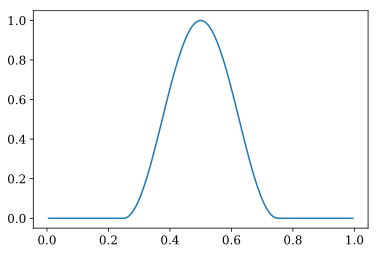

In [3]:
L = 1
r = 0.5
N = 100
dx = L/N
u_0 = 1.

phi = np.zeros(N)
F = np.zeros(N+1)
u = u_0*np.ones(N+1)
x_phi = np.linspace(dx/2.,L-dx/2.,N)
x_u = np.linspace(0.,L,N+1)

def exact_solution(t):
    global u_0,x_phi,N
    phi = np.zeros(N)
    X = x_phi - u_0*t
    X = np.mod(X,L)
    phi = (1.+np.cos(2*np.pi*(X-L/2.)/r))/2.
    xmask = np.where(np.abs(X-L/2.)/r > 1/2)
    phi[xmask] = 0.
    return phi

plt.plot(x_phi,exact_solution(0.))

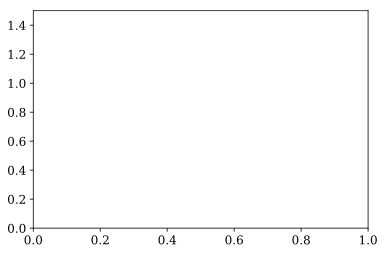

In [4]:
from matplotlib import animation, rc
from IPython.display import HTML
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, L))
ax.set_ylim((0, 1.5))

line, = ax.plot([], [], lw=2)

In [5]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [6]:
# animation function. This is called sequentially
tmax = 2.
dt = 0.01
Nt = np.int(tmax/dt)
def animate(i):
    line.set_data(x_phi, exact_solution(dt*i))
    return (line,)


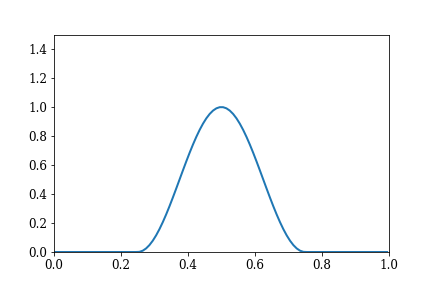
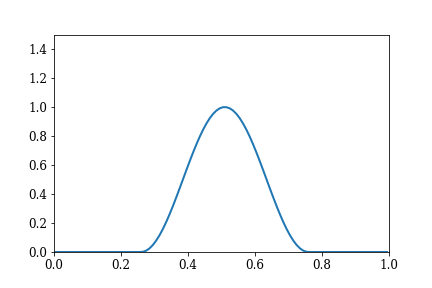
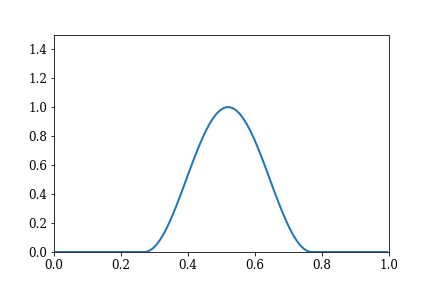
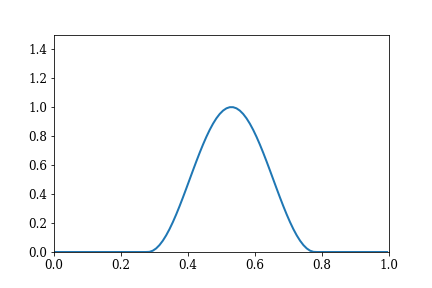
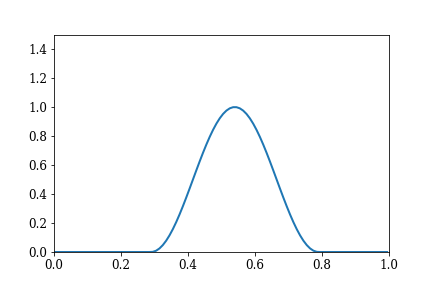
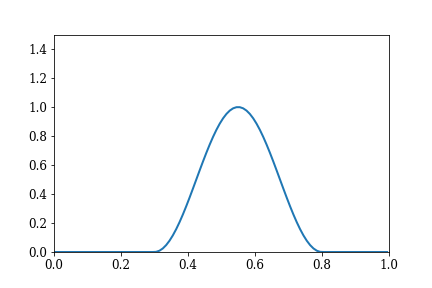
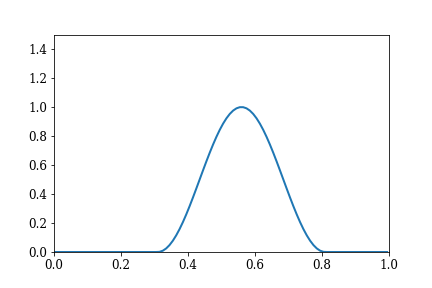
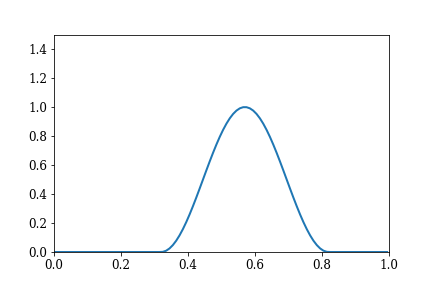
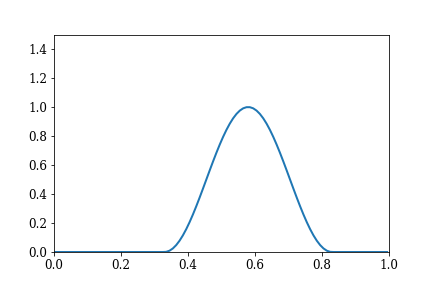
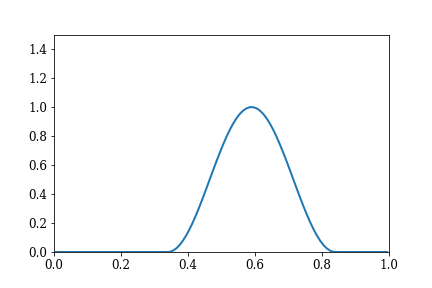
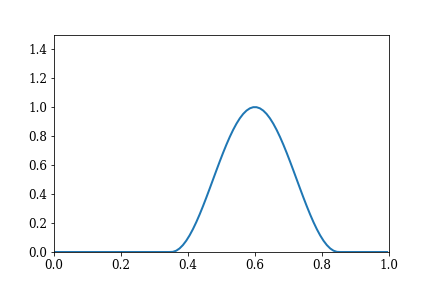
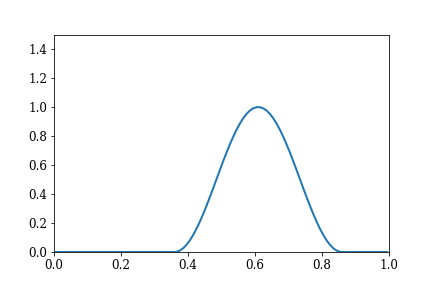
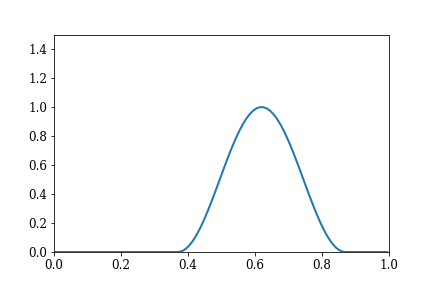
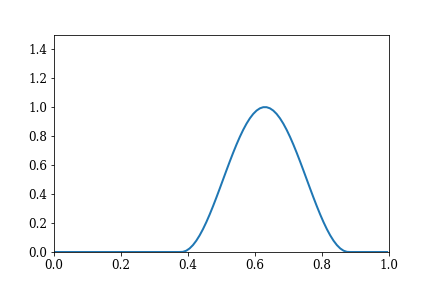
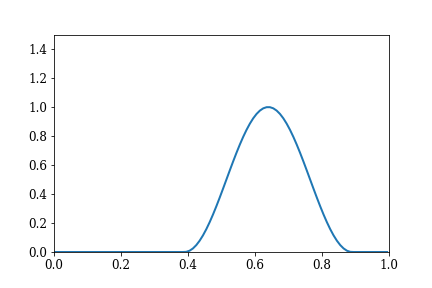
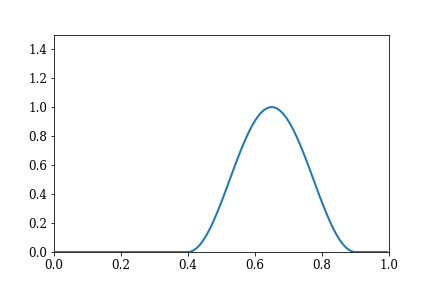
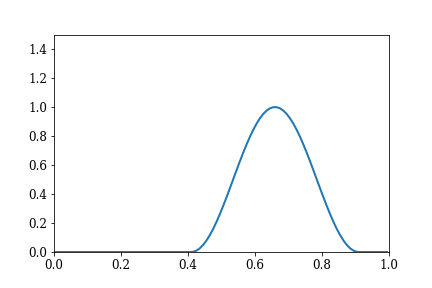
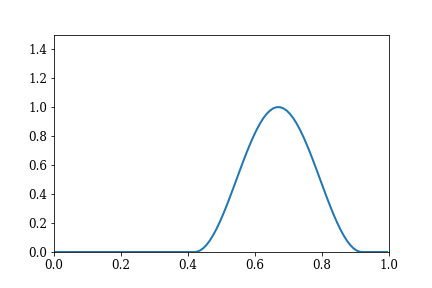
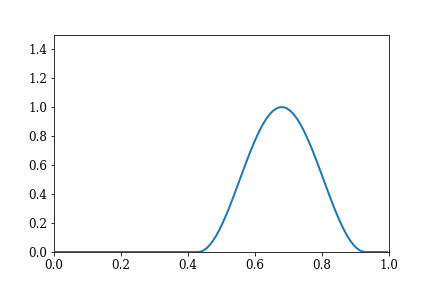
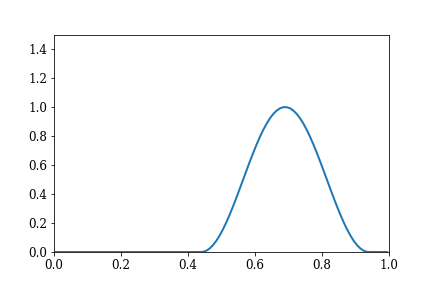
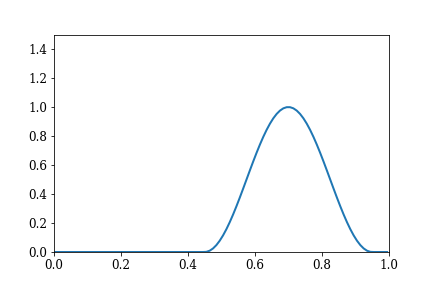
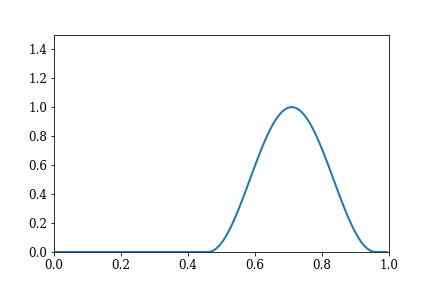
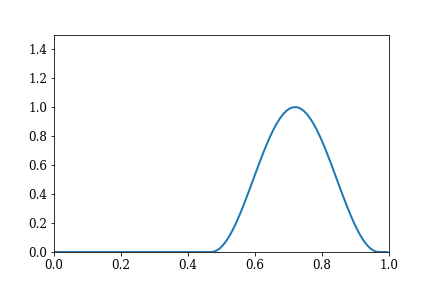
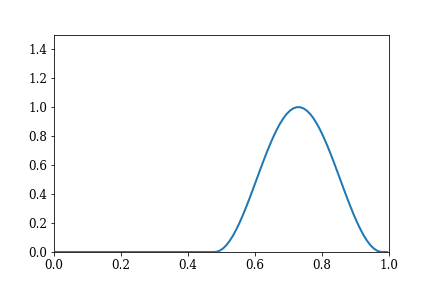
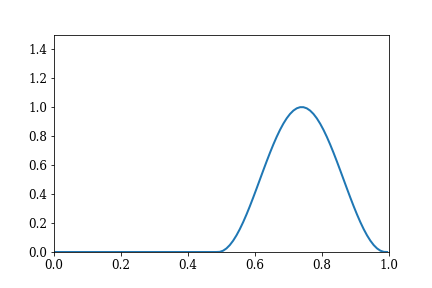
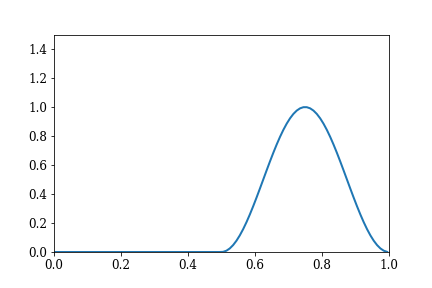
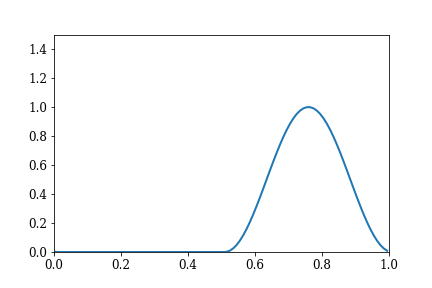
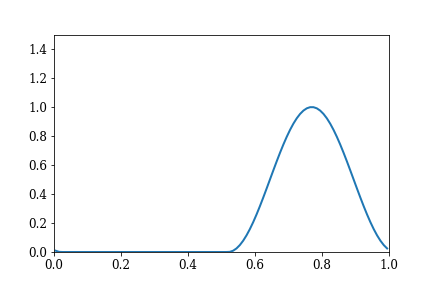
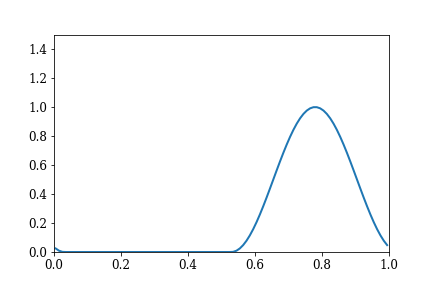
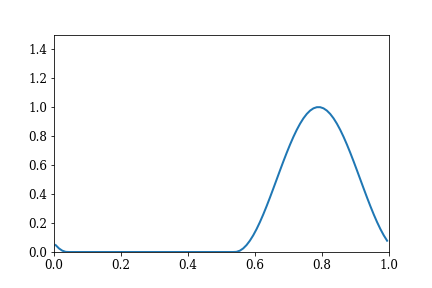
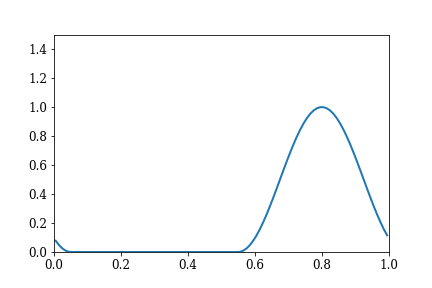
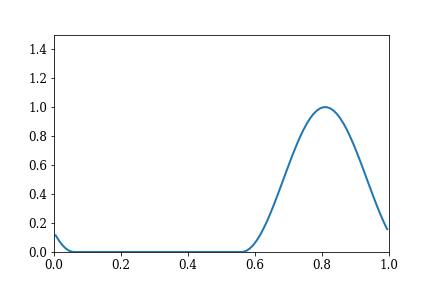
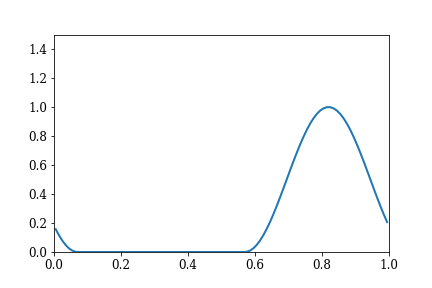
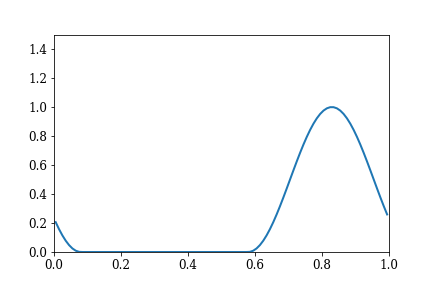
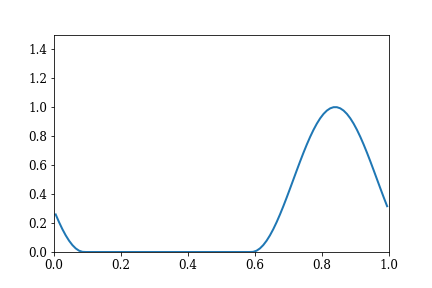
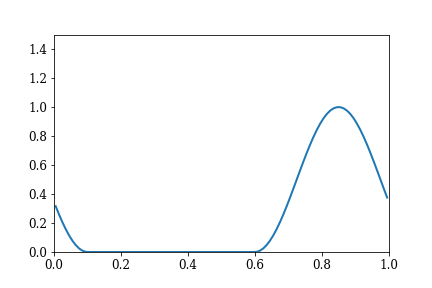
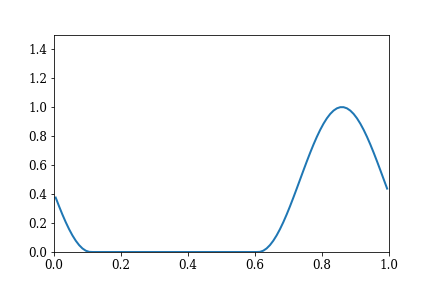
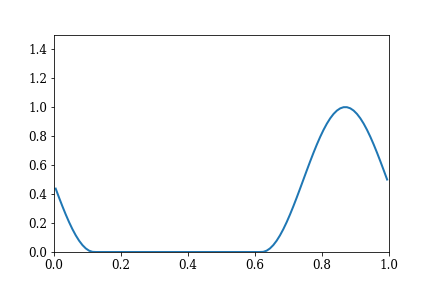
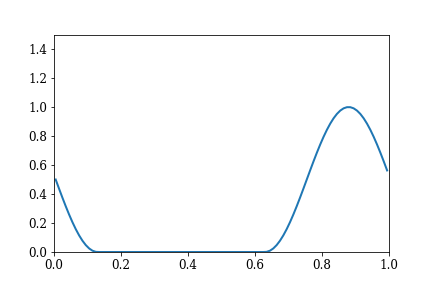
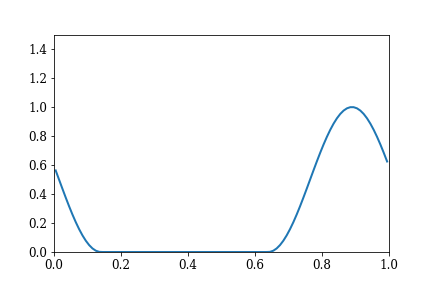
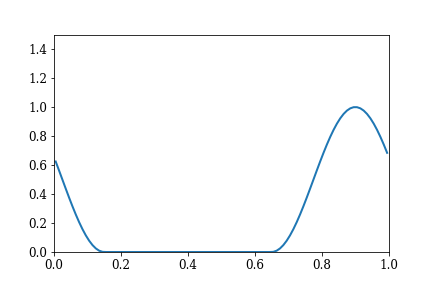
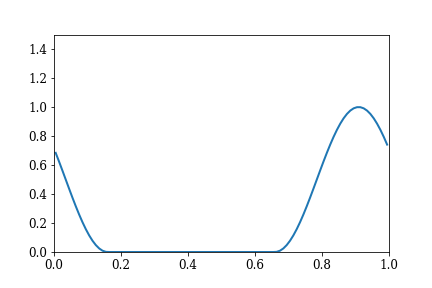
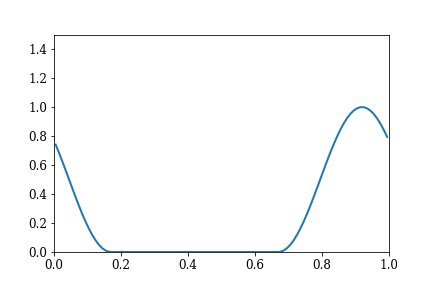
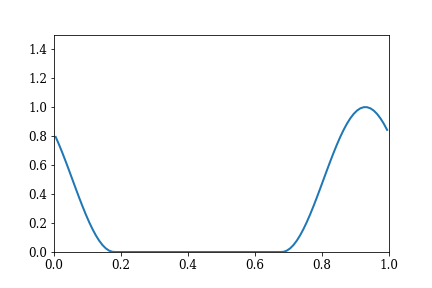
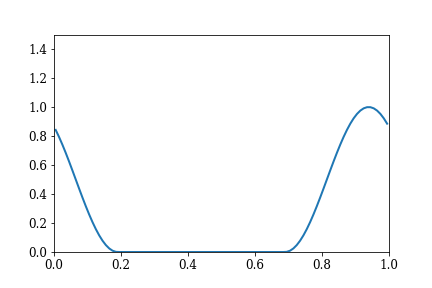
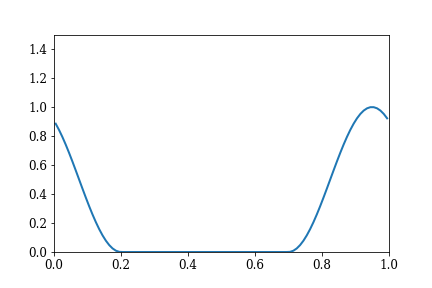
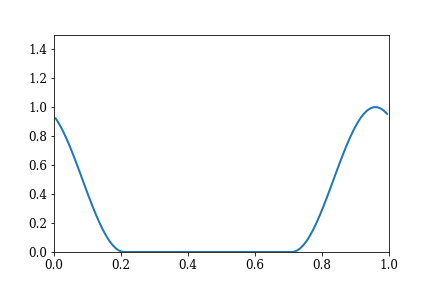
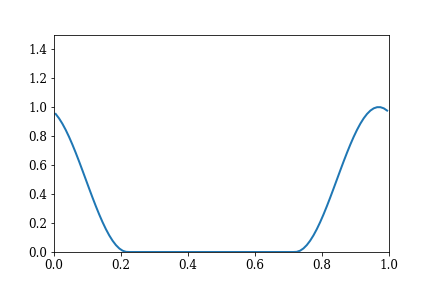
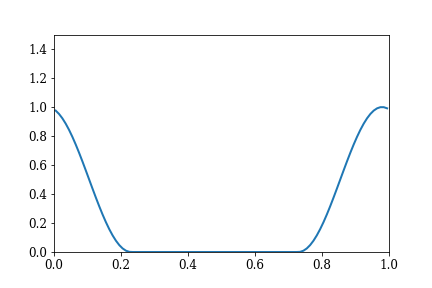
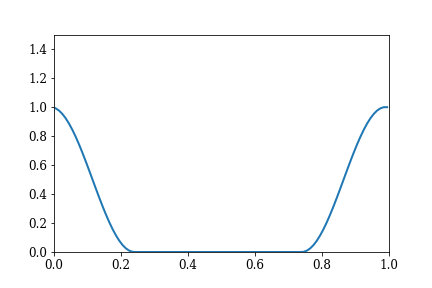
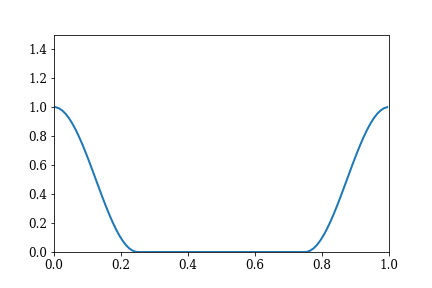
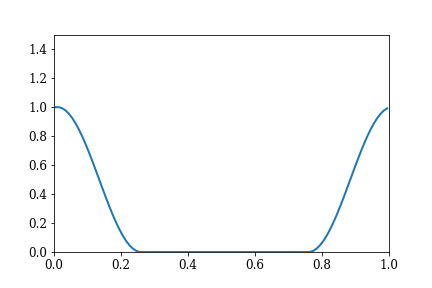
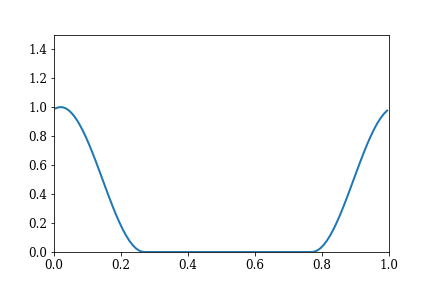
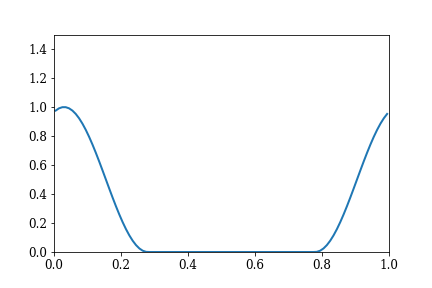
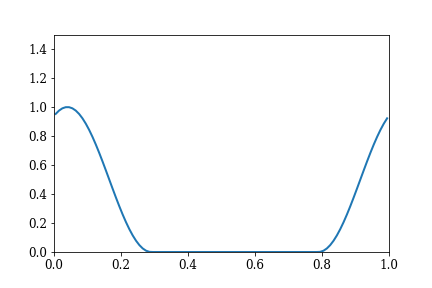
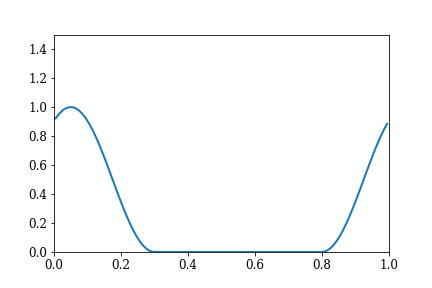
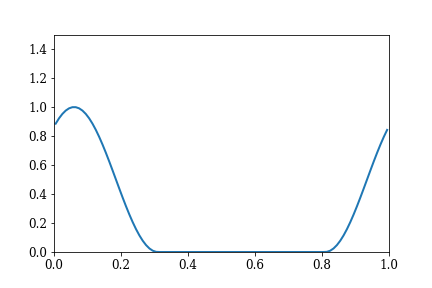
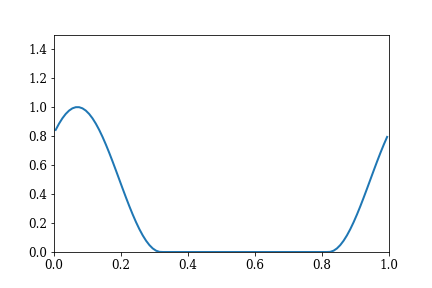
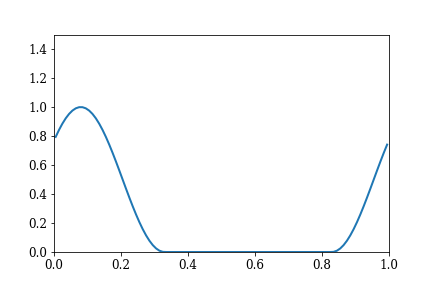
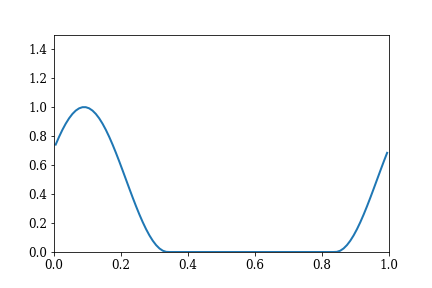
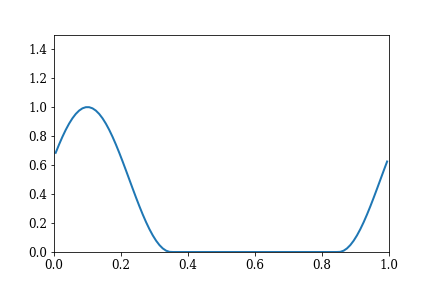
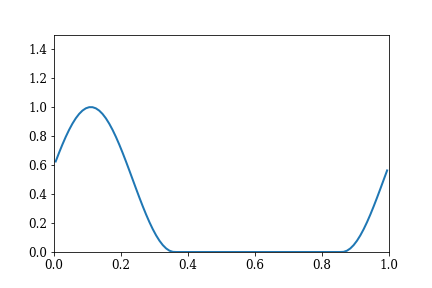
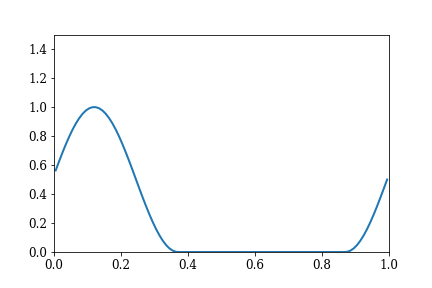
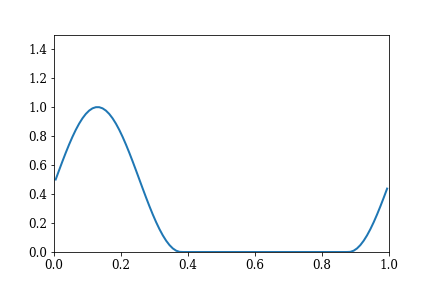
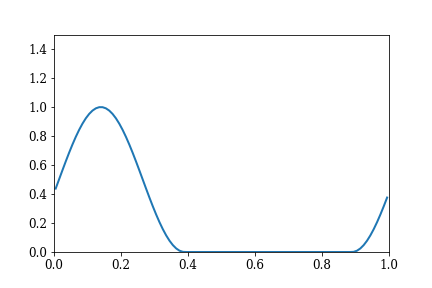
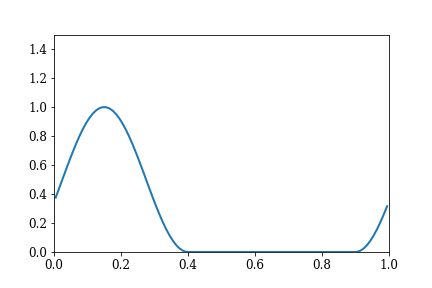
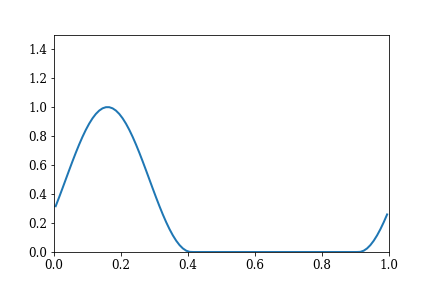
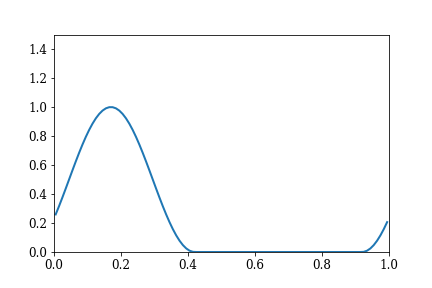
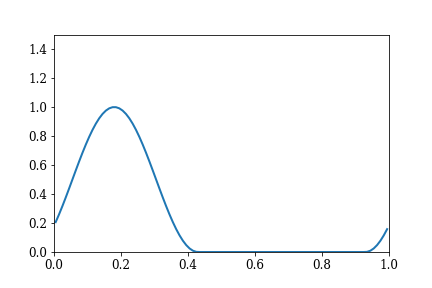
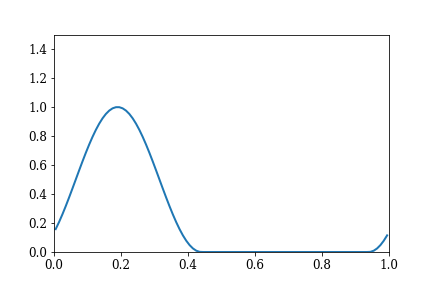
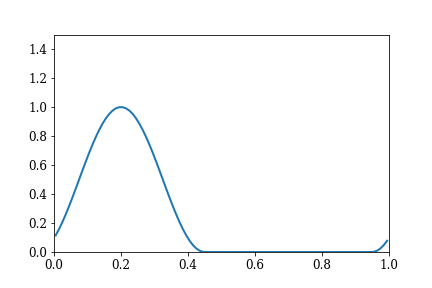
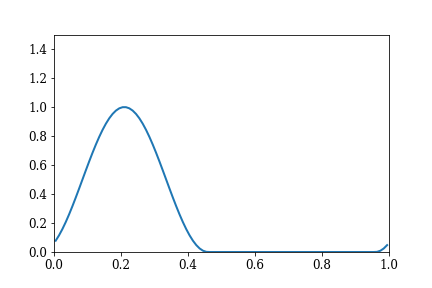
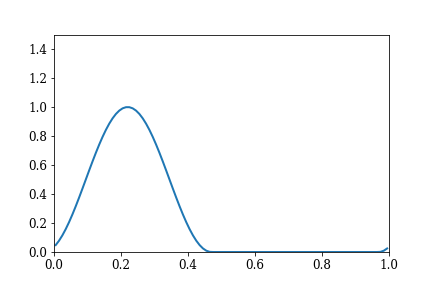
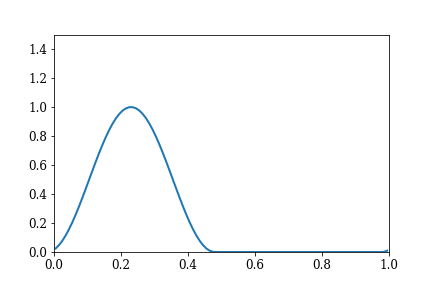
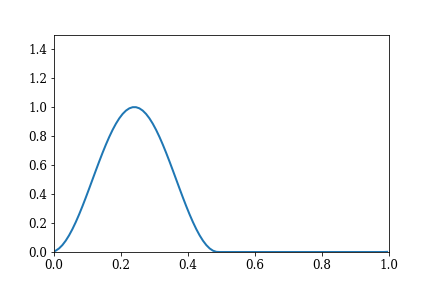
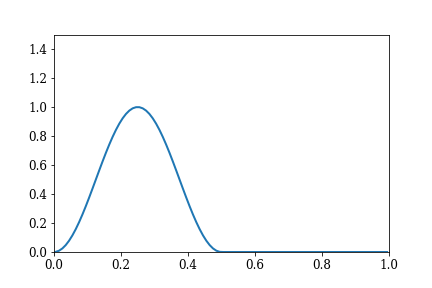
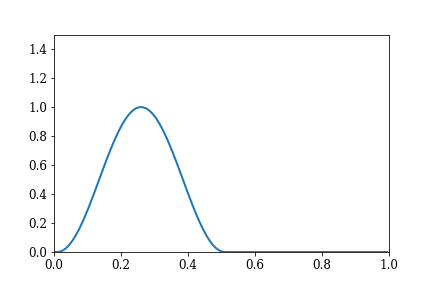
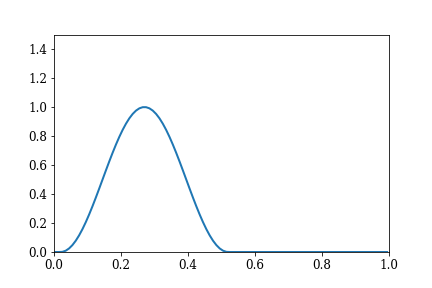
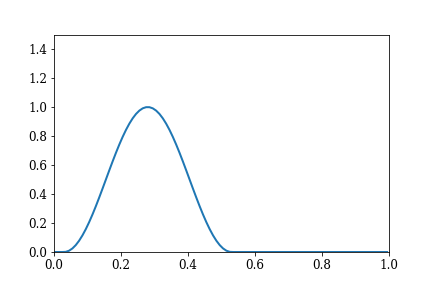
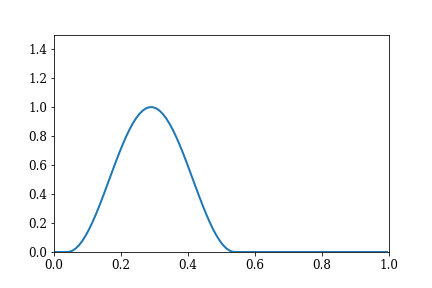
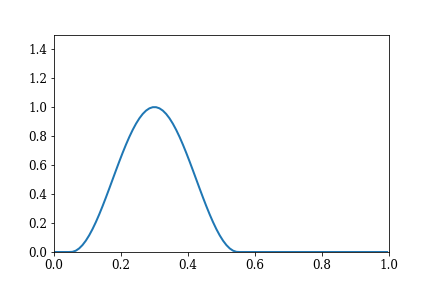
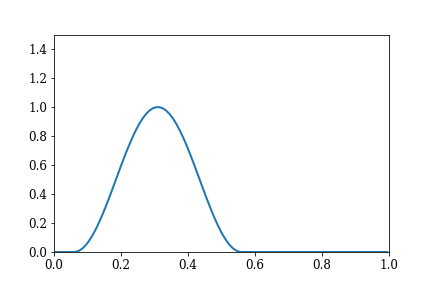
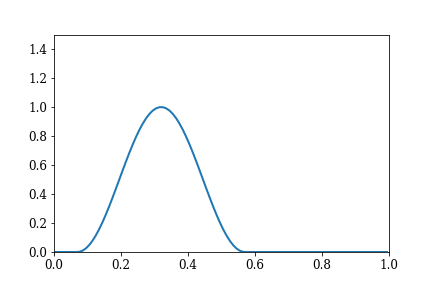
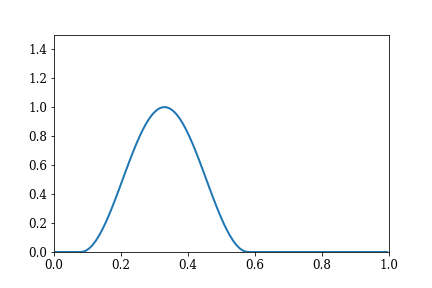
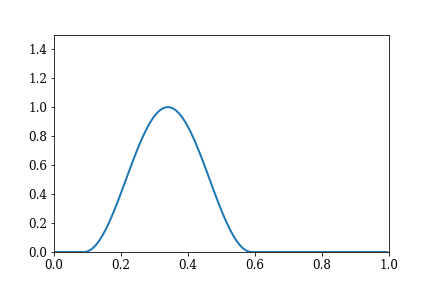
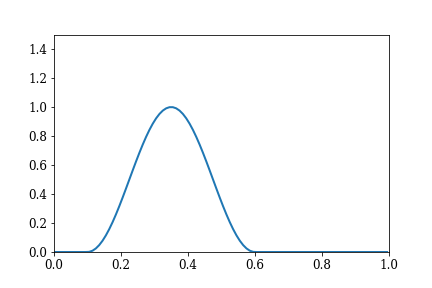
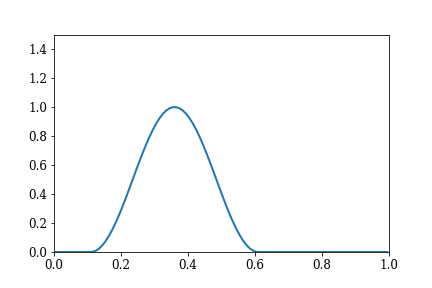
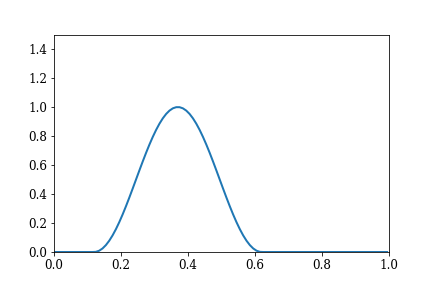
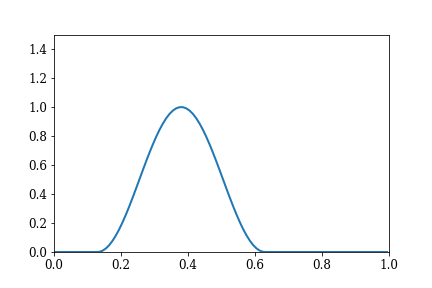
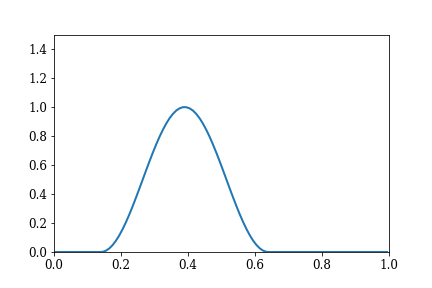
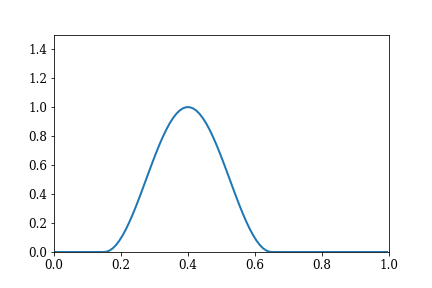
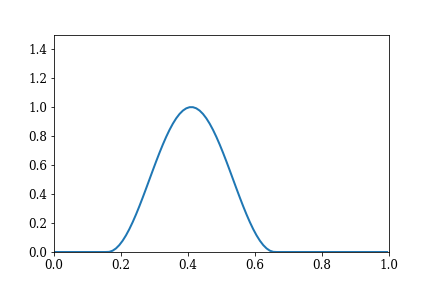
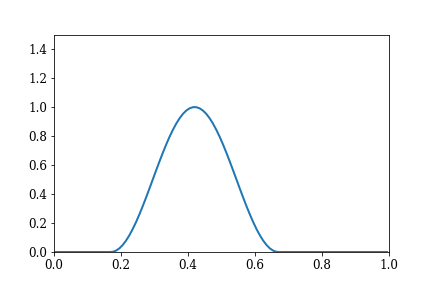
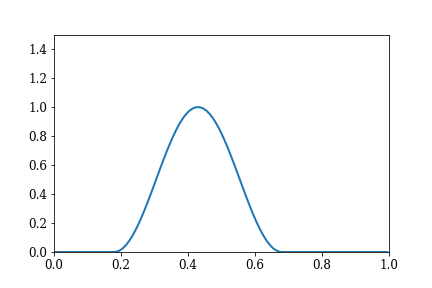
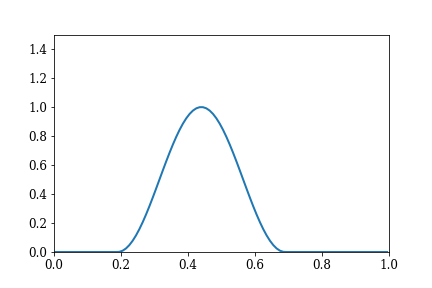
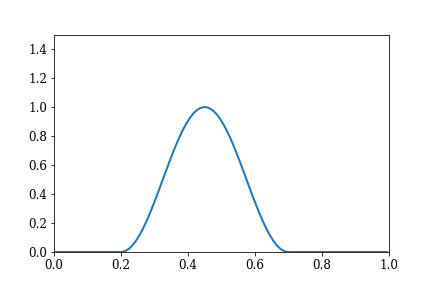
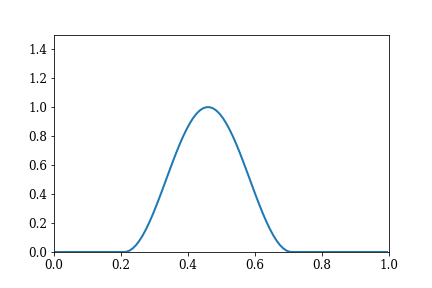
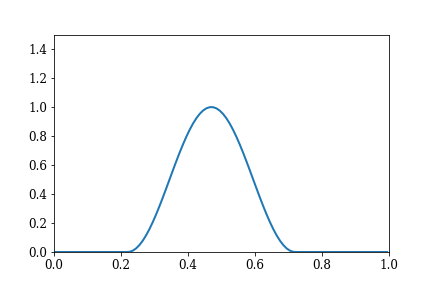
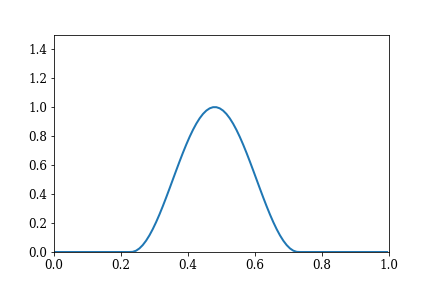
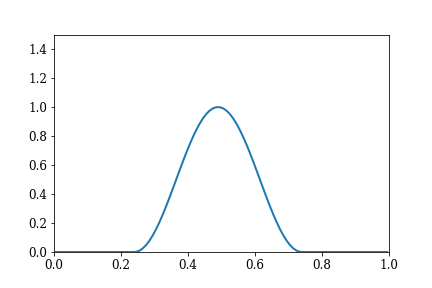
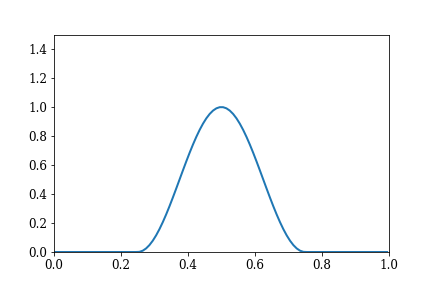
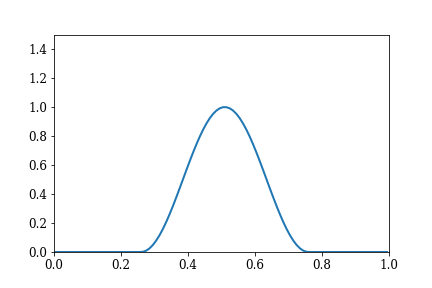
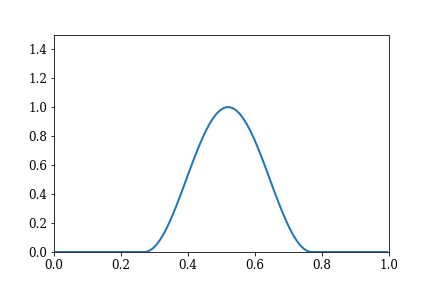
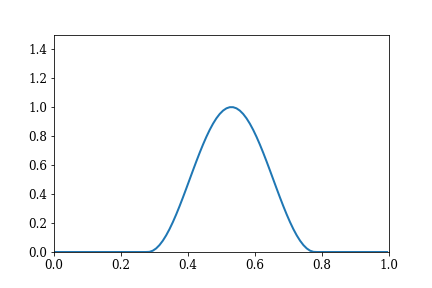
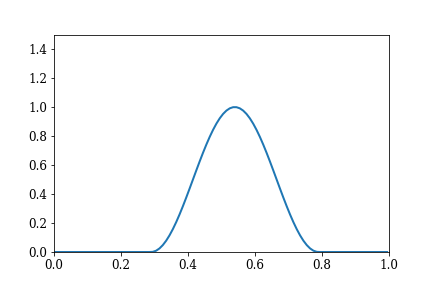
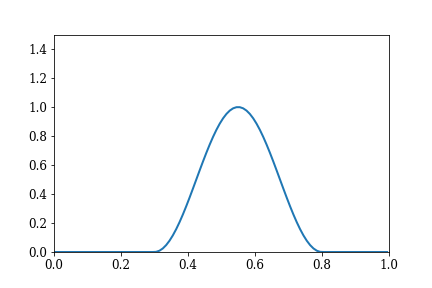
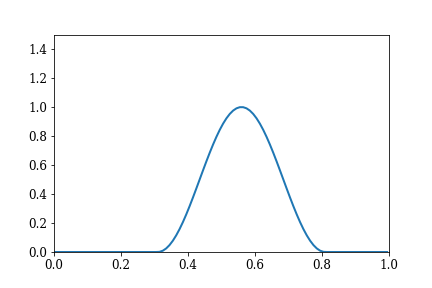
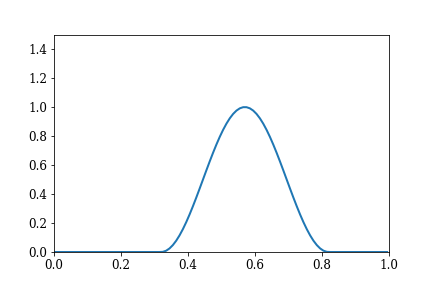
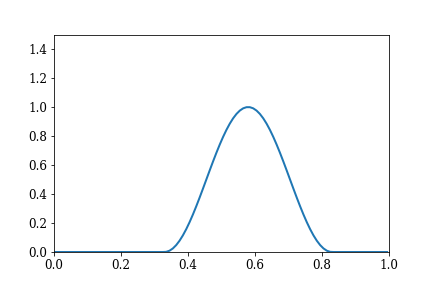
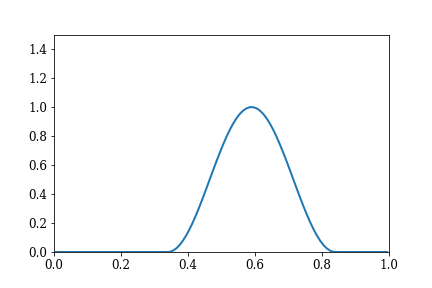
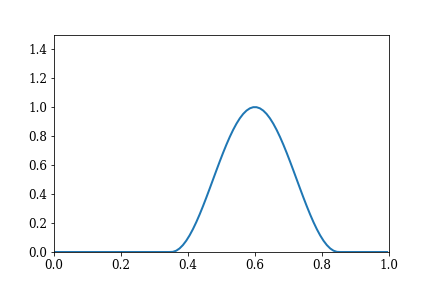
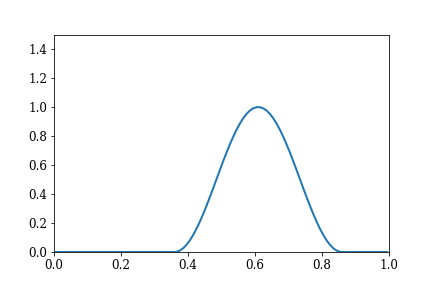
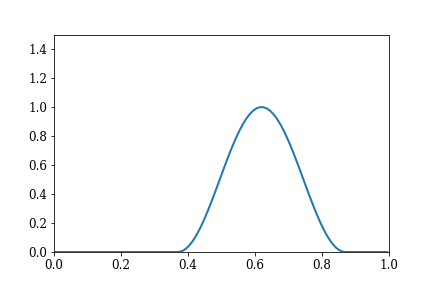
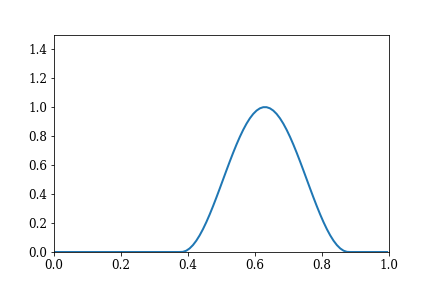
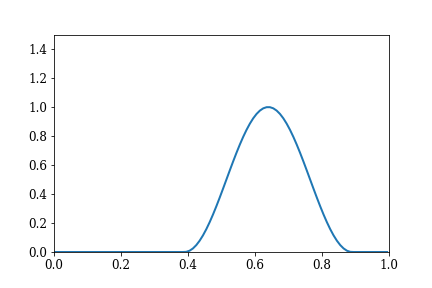
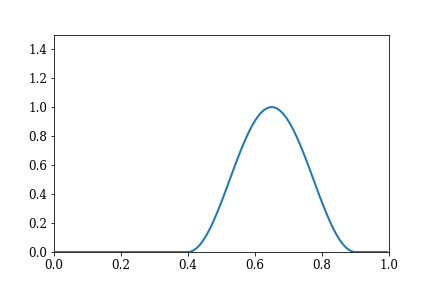
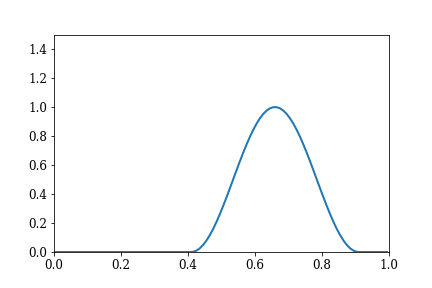
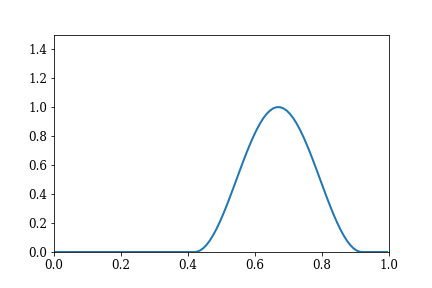
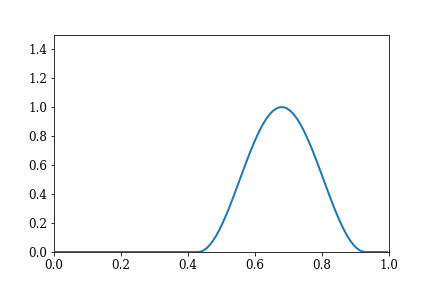
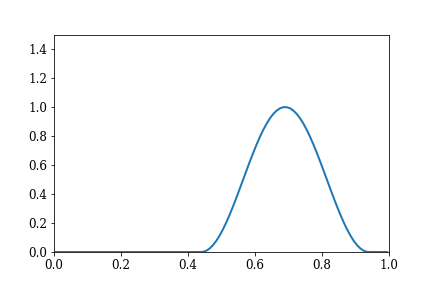
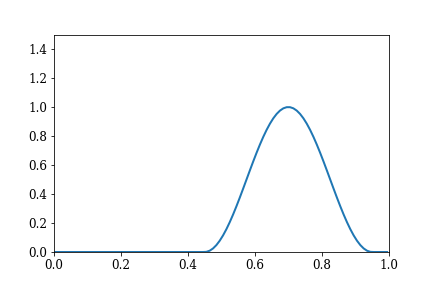
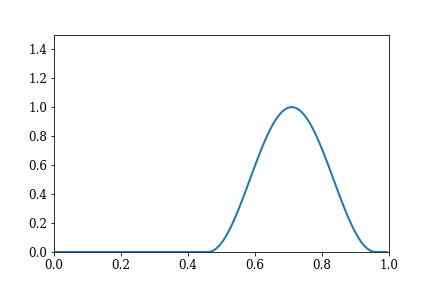
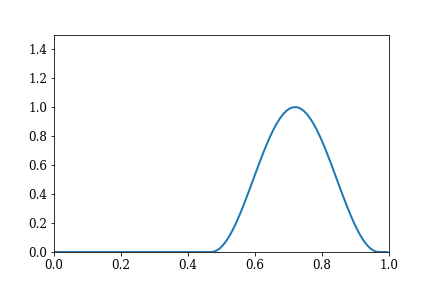
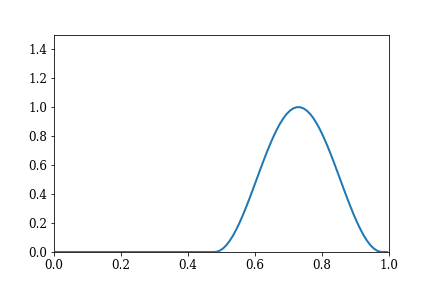
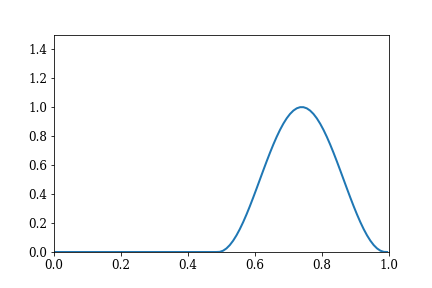
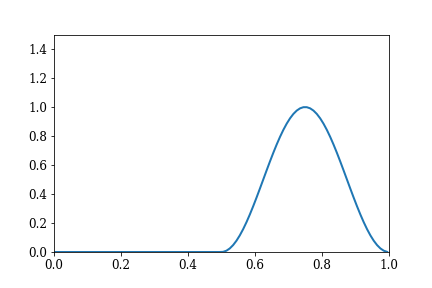
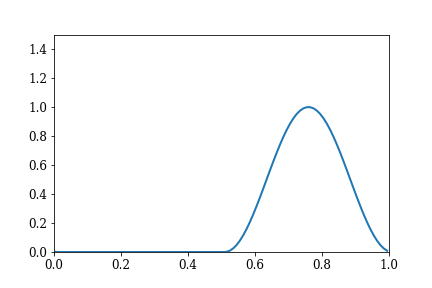
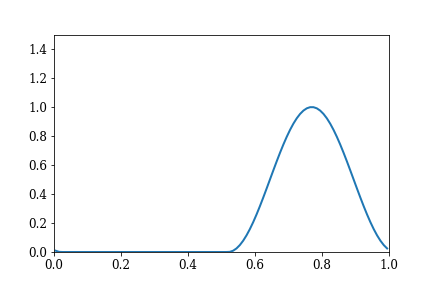
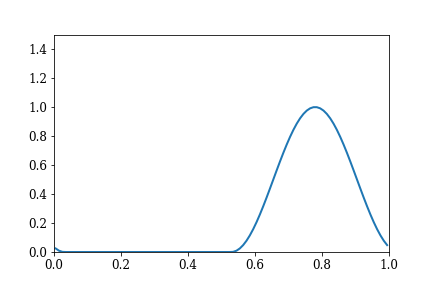
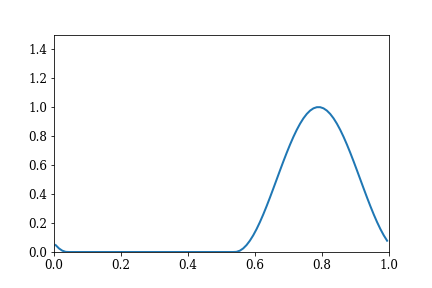
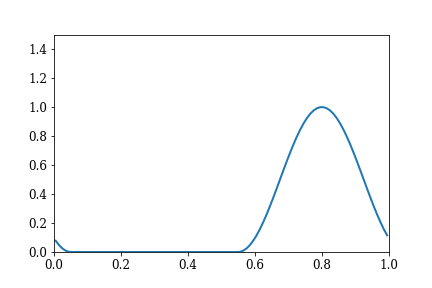
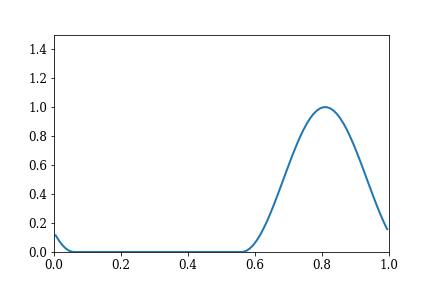
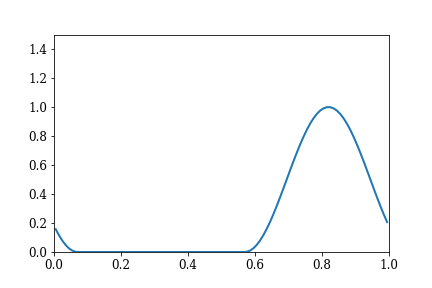
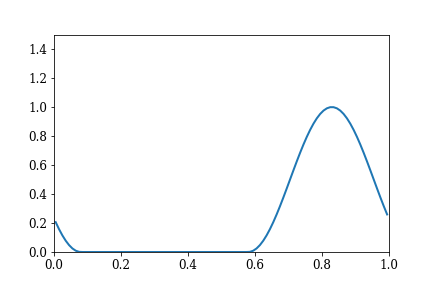
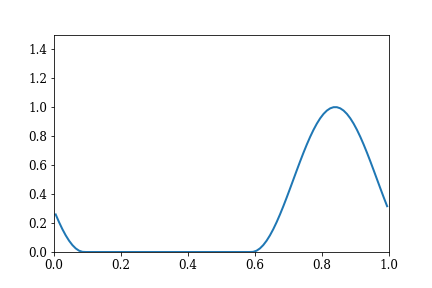
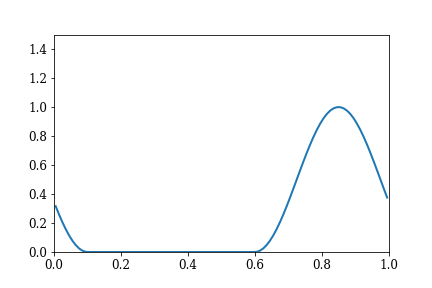
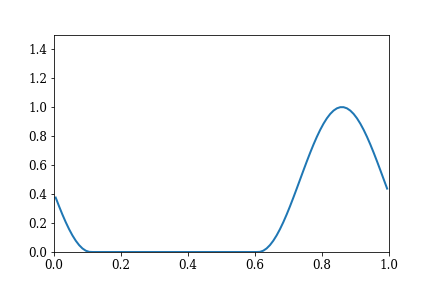
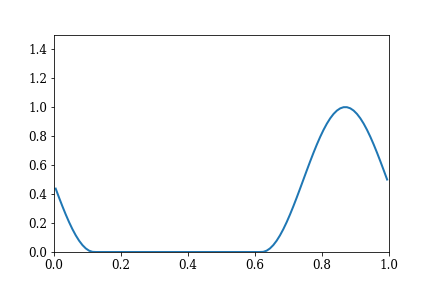
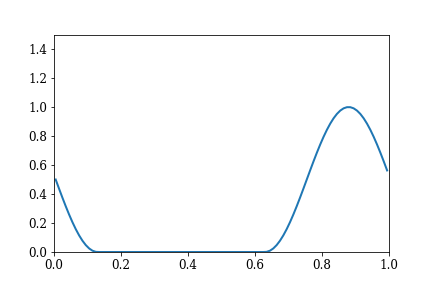
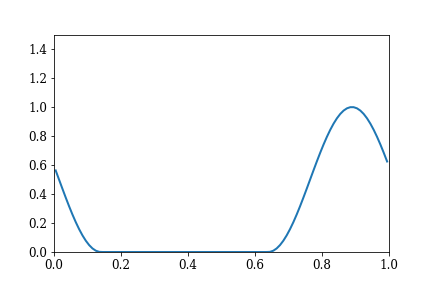
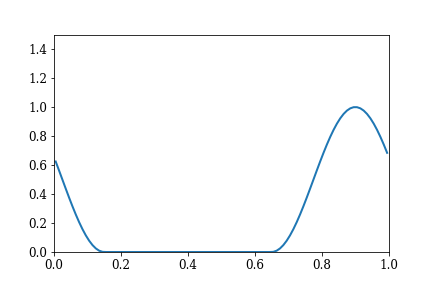
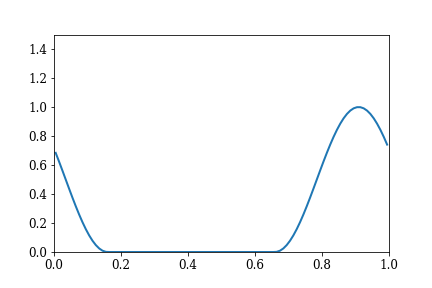
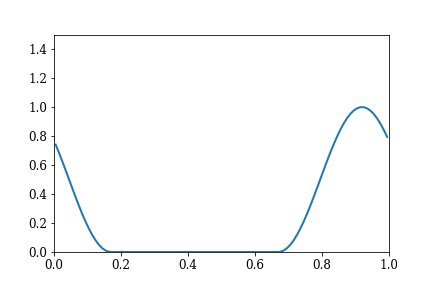
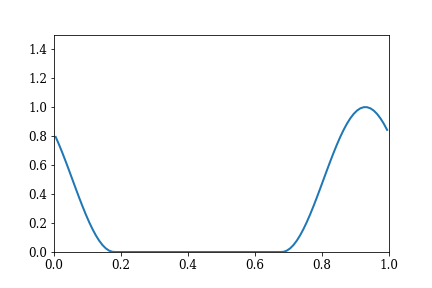
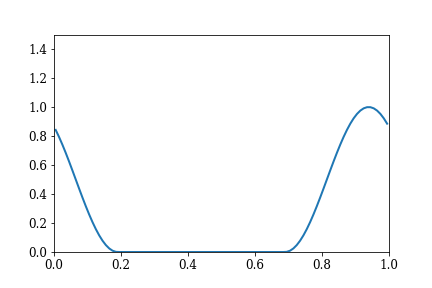
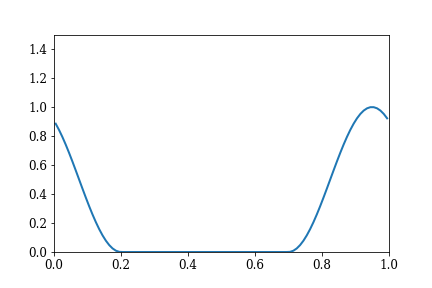
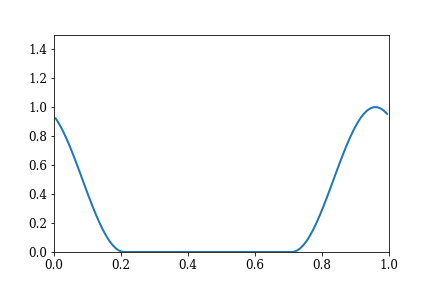
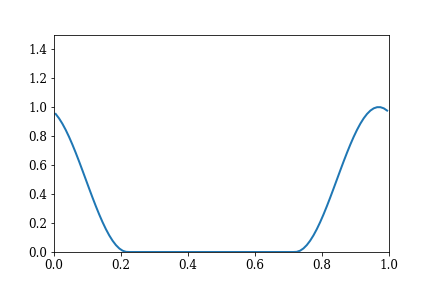
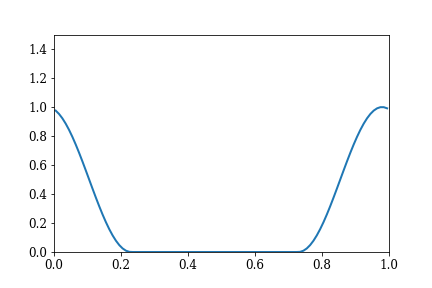
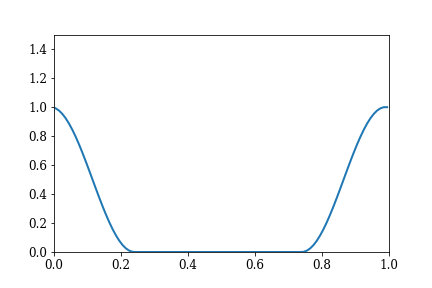
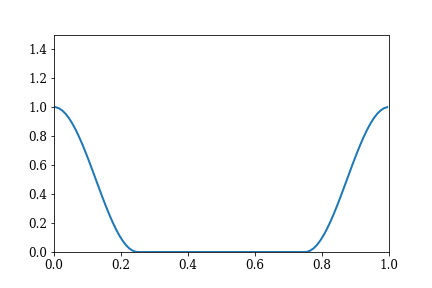
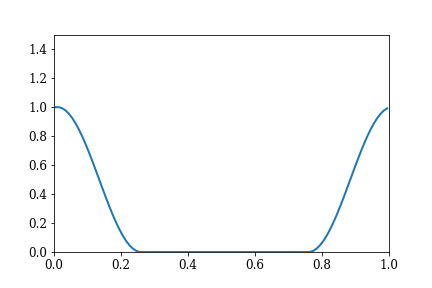
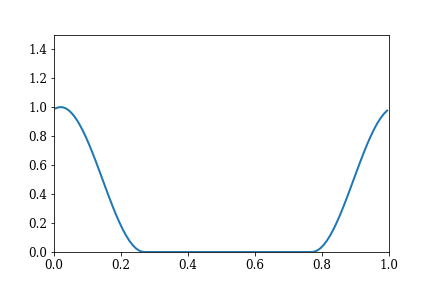
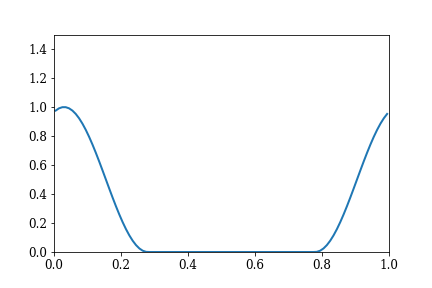
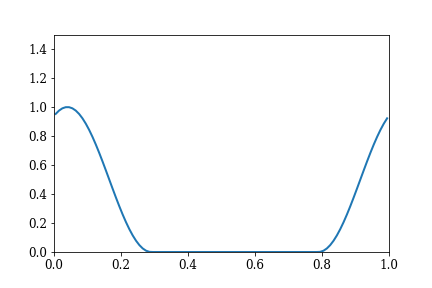
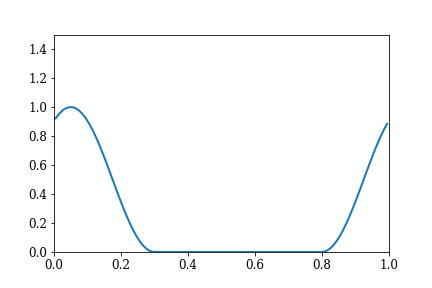
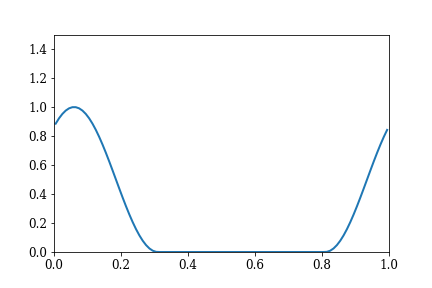
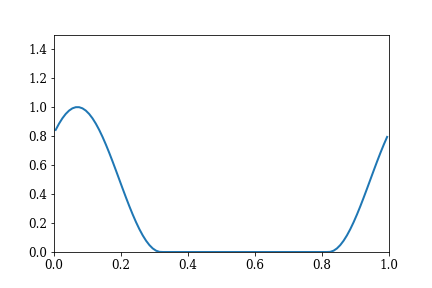
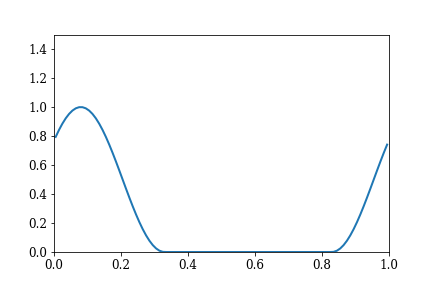
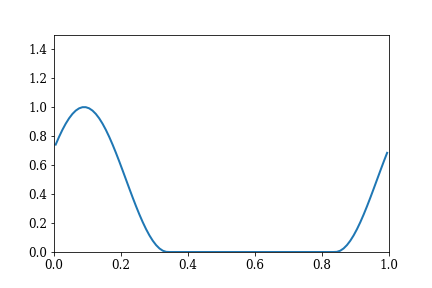
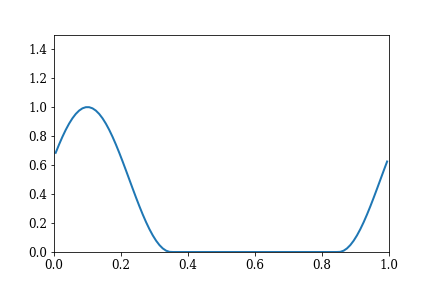
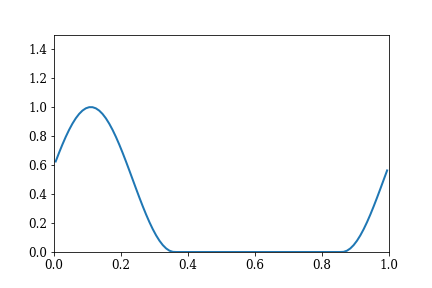
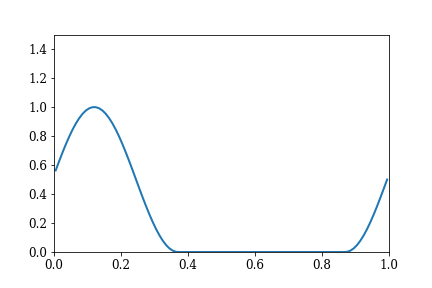
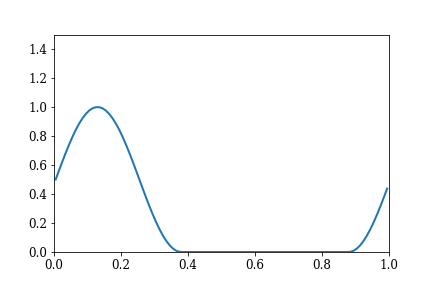
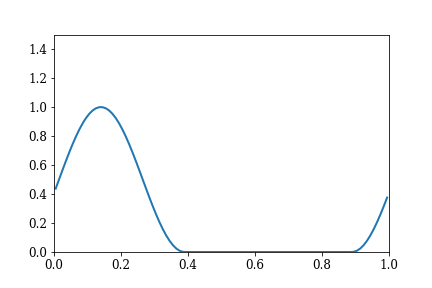
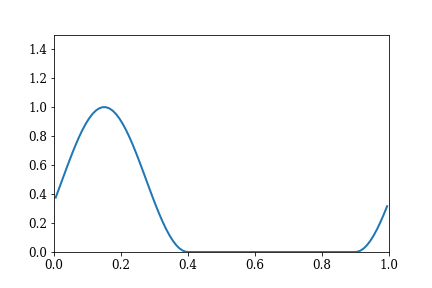
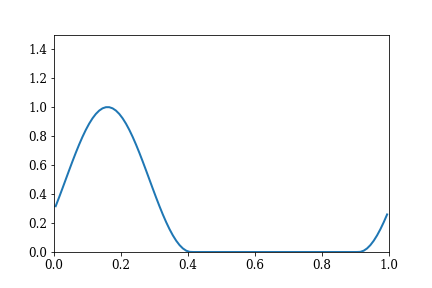
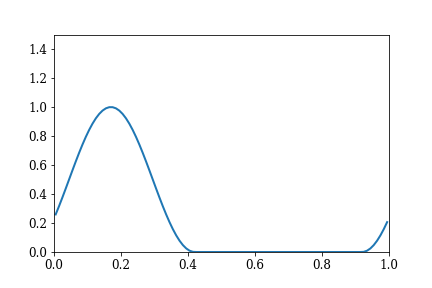
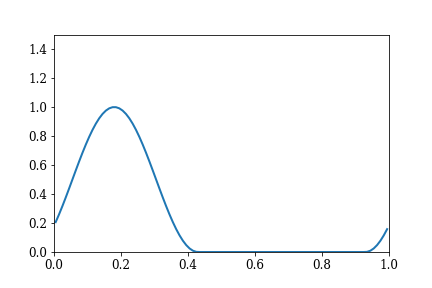
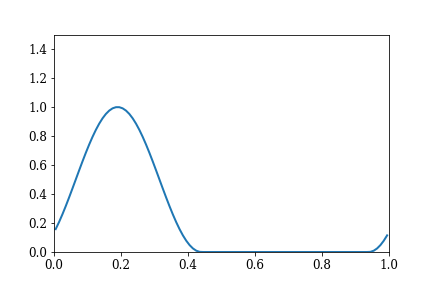
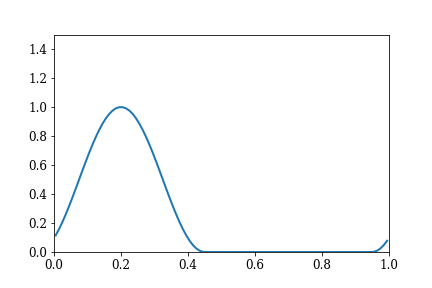
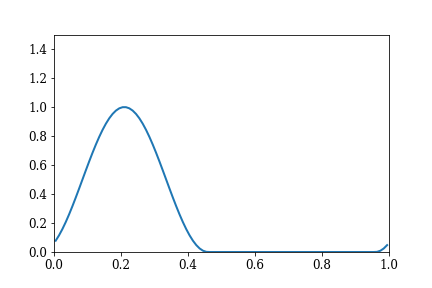
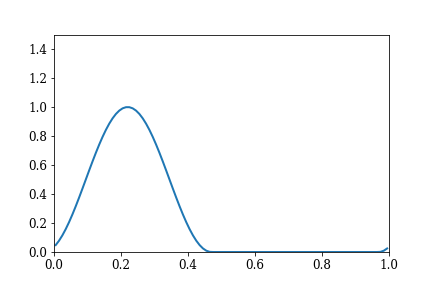
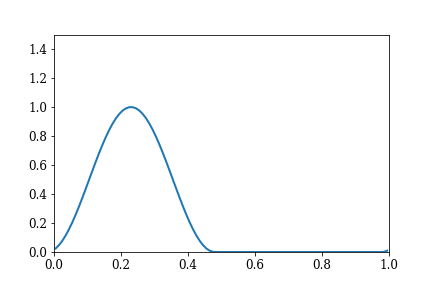
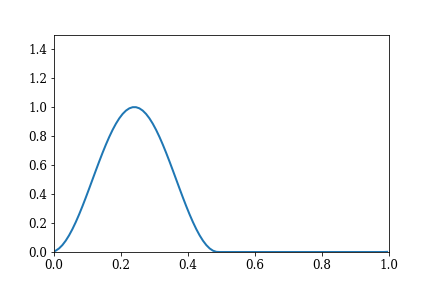
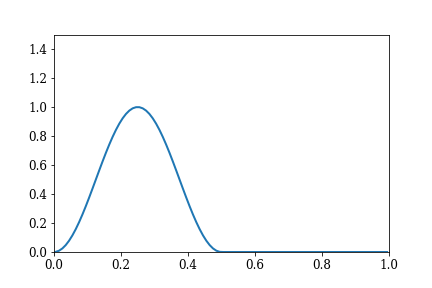
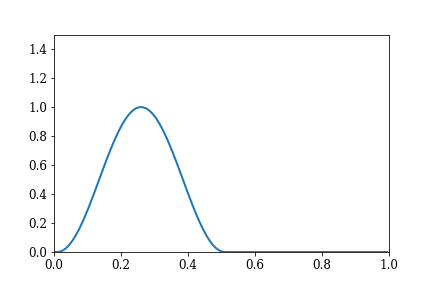
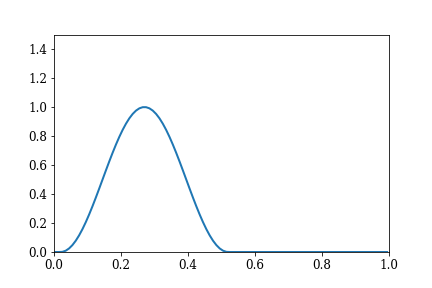
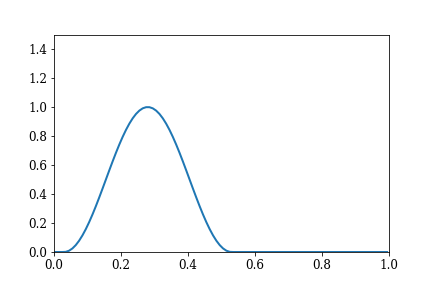
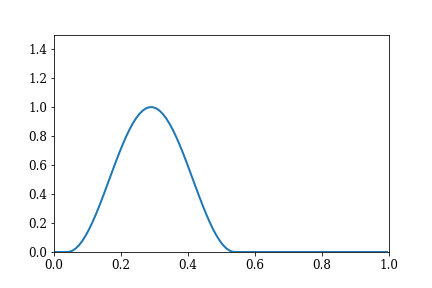
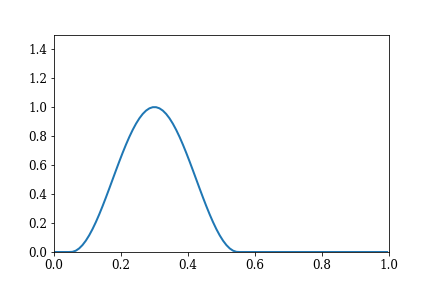
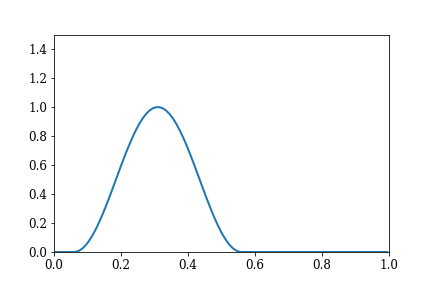
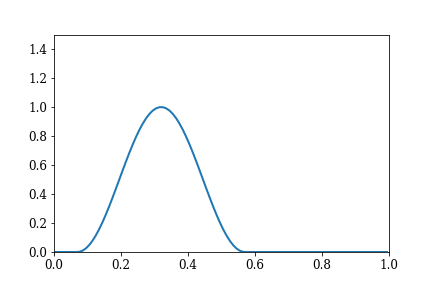
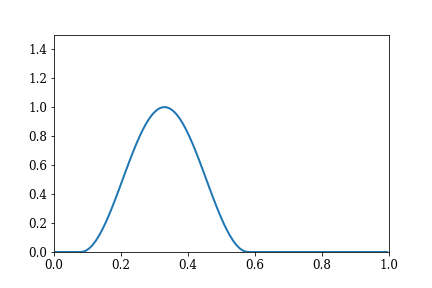
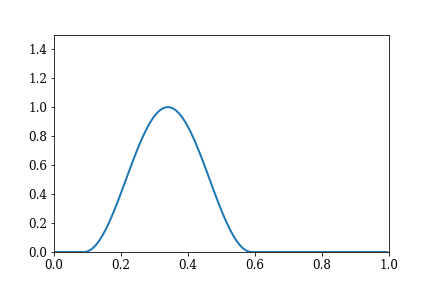
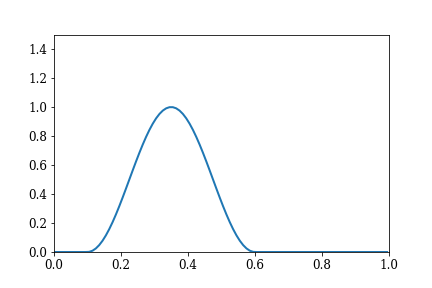
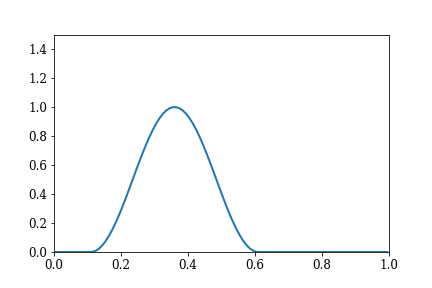
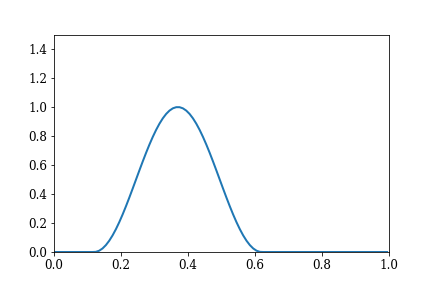
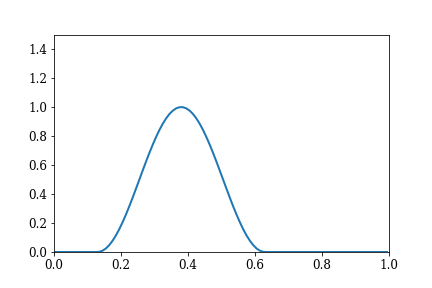
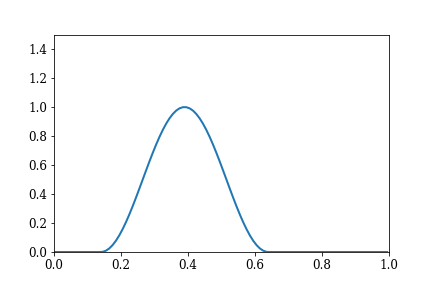
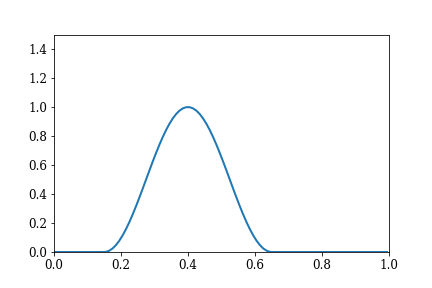
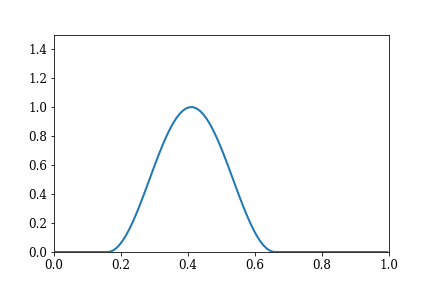
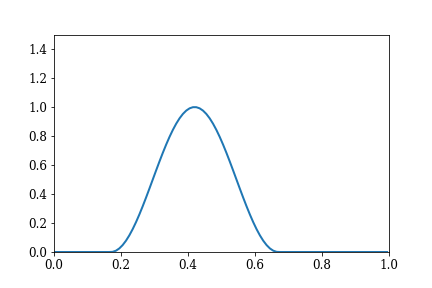
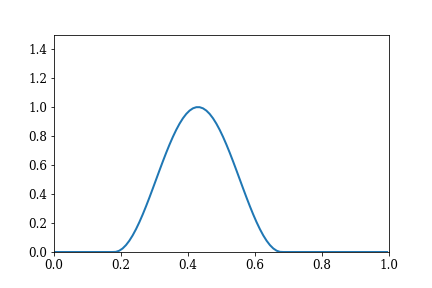
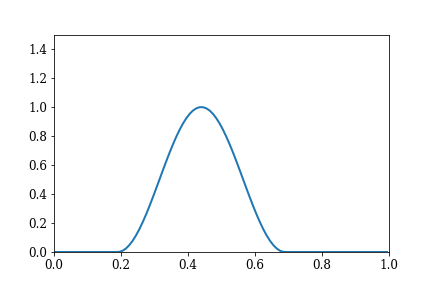
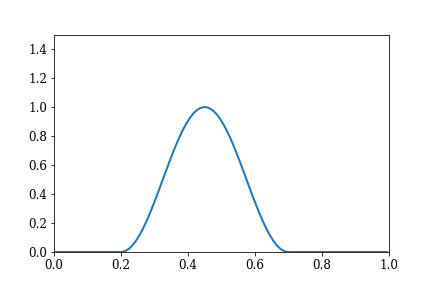
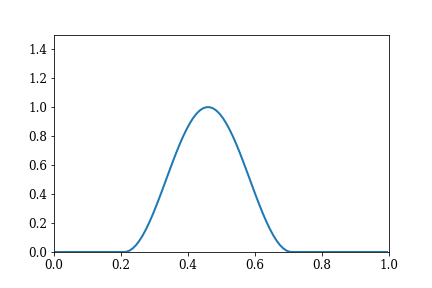
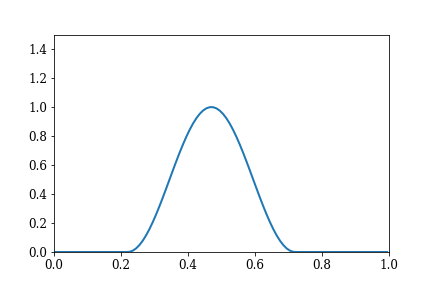
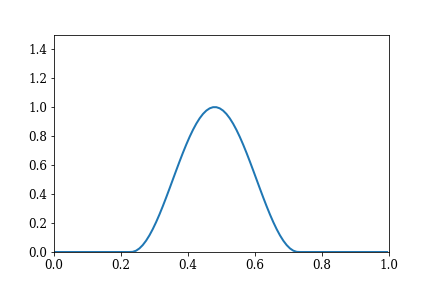
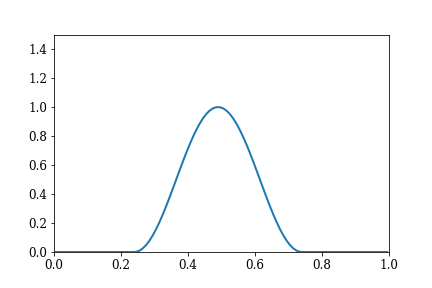
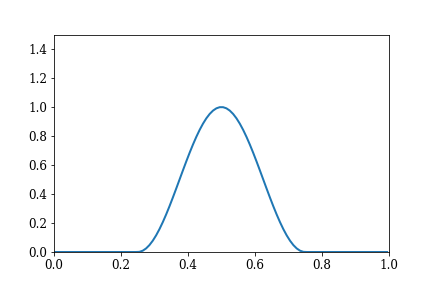

In [7]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nt+1, interval=20, blit=True)

# call our new function to display the animation
display_animation(anim)

In [8]:
def exact_solution(t):
    global u_0,x_phi,N
    phi = np.zeros(N)
    X = x_phi - u_0*t
    X = np.mod(X,L)
    phi = (1.+np.cos(2*np.pi*(X-L/2.)/r))/2.
    xmask = np.where(np.abs(X-L/2.)/r > 1/2)
    phi[xmask] = 0.
    return phi

def interpolate_central_2nd(a):
    N = len(a)
    f=np.zeros(N+1)
    f[1:-1] = 0.5*(a[0:-1]+a[1:])
    f[0] = 0.5*(a[-1] + a[0])
    f[-1] = f[0]
    return f

def interpolate_upwind_1st_left(a):
    N = len(a)
    f=np.zeros(N+1)
    f[1:-1] = a[0:-1]
    f[0] = a[-1]
    f[-1] = f[0]
    return f



In [9]:
L = 1
r = 0.5
N = 200
dx = L/N
u_0 = 1.

tmax = 4.
dt = 1e-4

phi = np.zeros(N)
F = np.zeros(N+1)
u = u_0*np.ones(N+1)
x_phi = np.linspace(dx/2.,L-dx/2.,N)
x_u = np.linspace(0.,L,N+1)

phi = exact_solution(0.)
alpha = u_0*dt/dx
dt_frame = 0.01
Nframes = np.int(tmax/dt_frame) + 1
phiframe = np.zeros((N,Nframes))
dtf = 0.
iframe = 0
phiframe[:,iframe] = np.copy(phi)

t = 0.
while t < tmax:
    t += dt
    f = interpolate_upwind_1st_left(phi)
    phi -= alpha*(f[1:N+1]-f[0:N])
    dtf += dt
    if dtf >= dt_frame:
        iframe += 1
        dtf = 0
        phiframe[:,iframe] = np.copy(phi)
    
if iframe < Nframes:
    phiframe[:,Nframes-1] = np.copy(phi)
# plt.plot(x_phi,phi)

def animate(i):
    global dt
    line.set_data(x_phi, phiframe[:,i])
    return (line,)


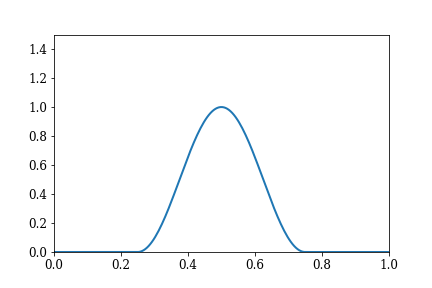
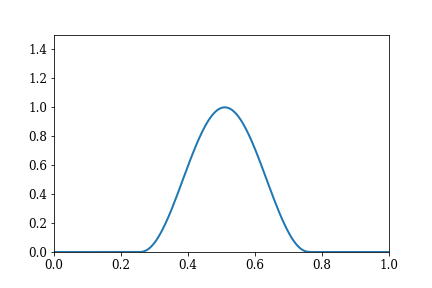
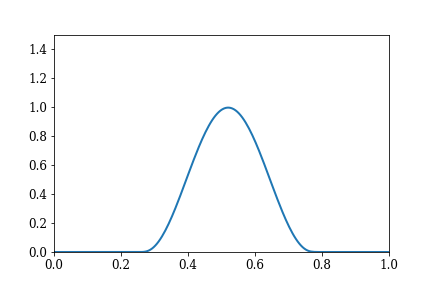
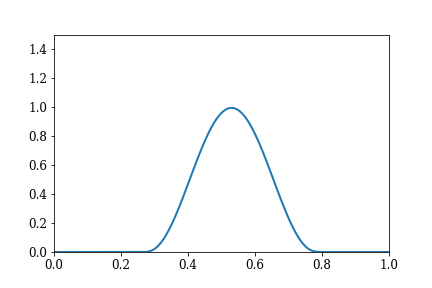
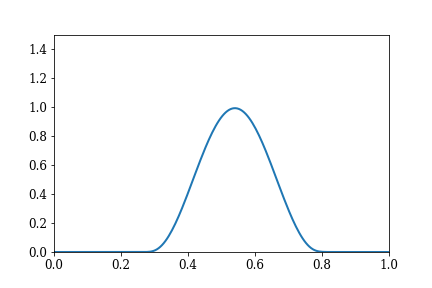
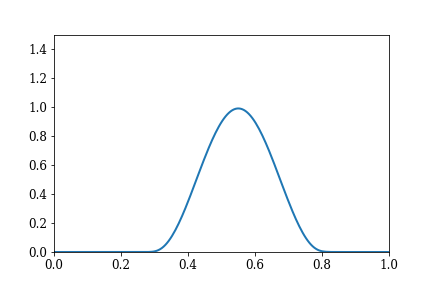
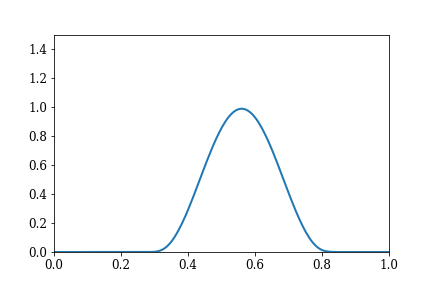
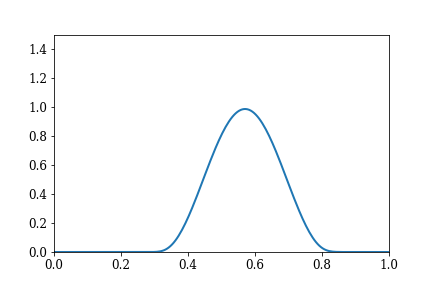
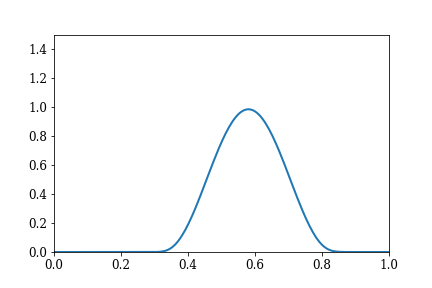
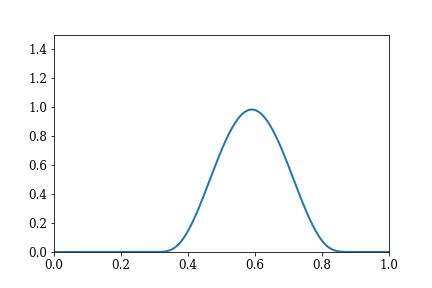
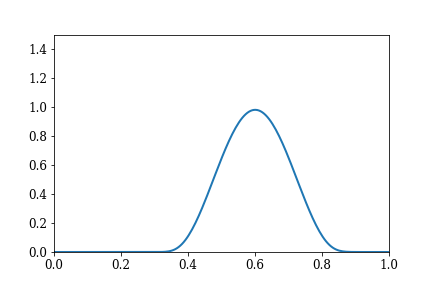
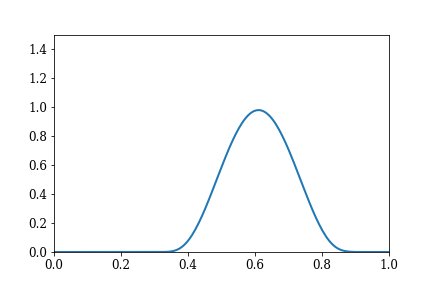
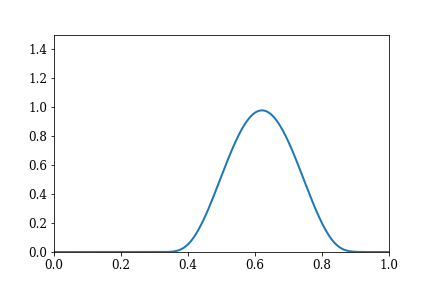
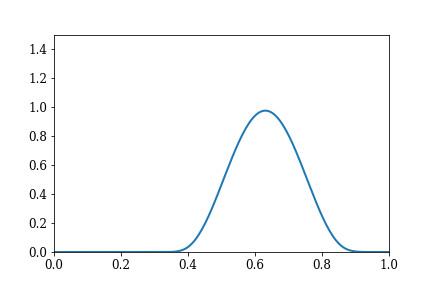
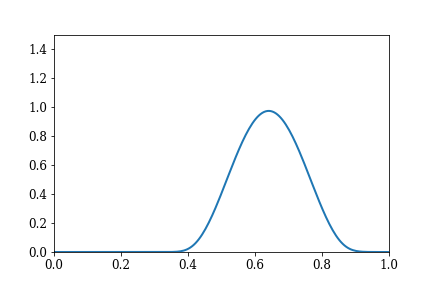
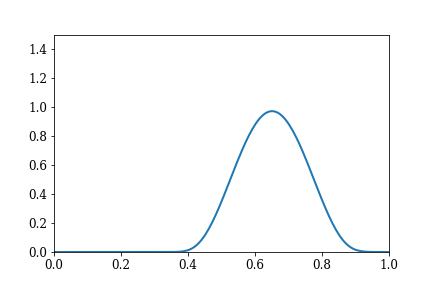
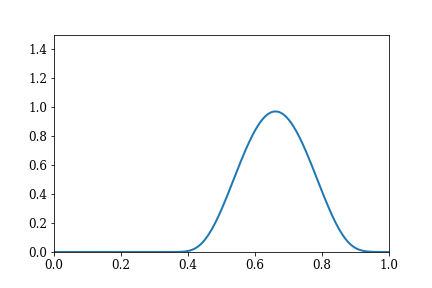
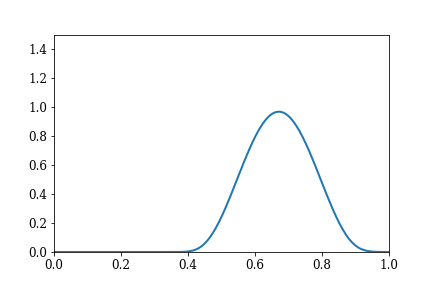
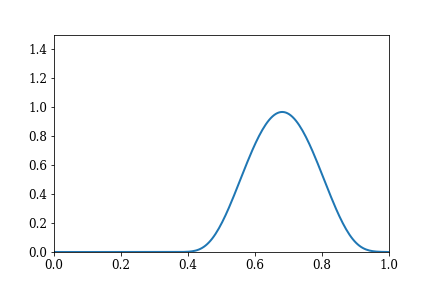
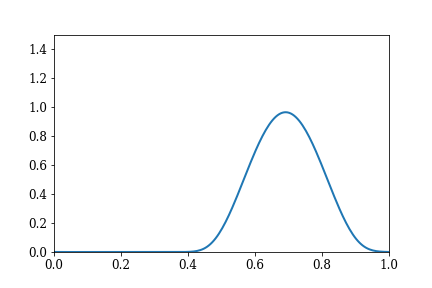
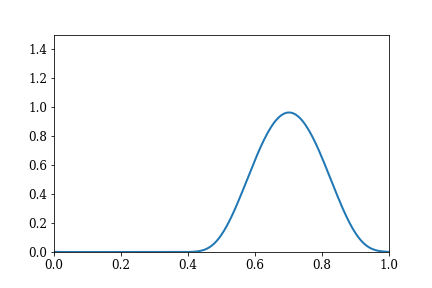
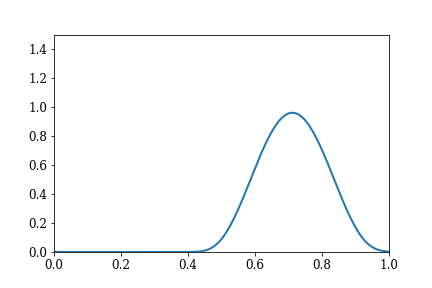
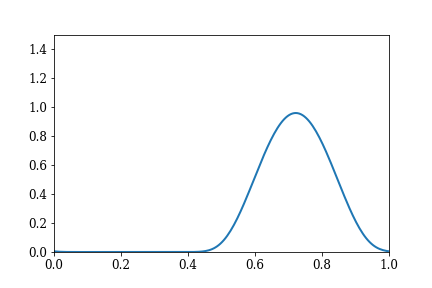
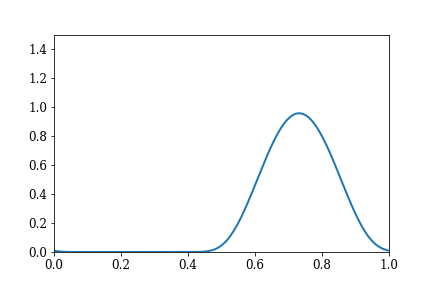
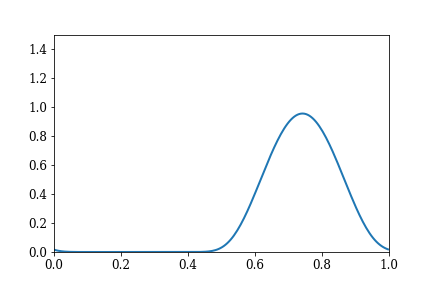
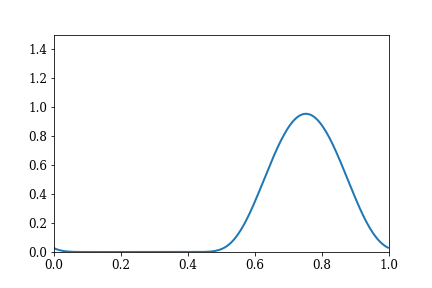
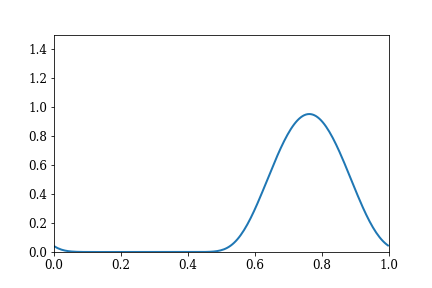
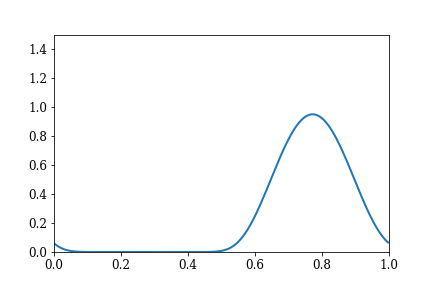
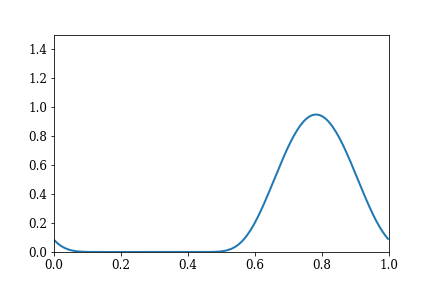
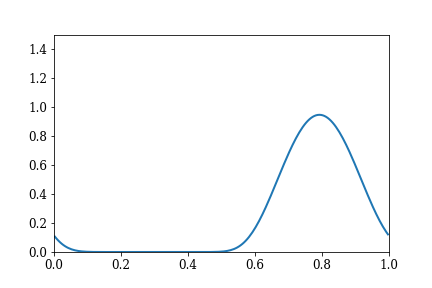
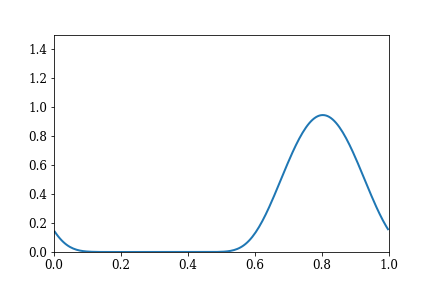
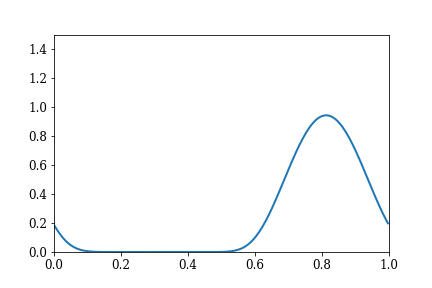
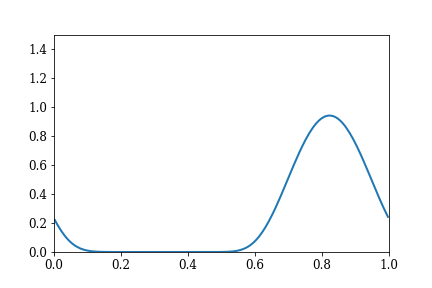
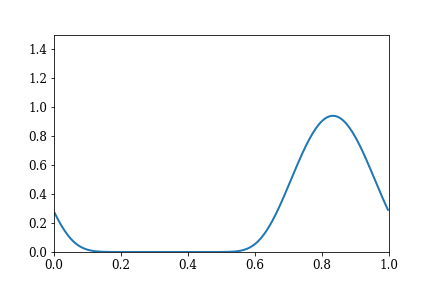
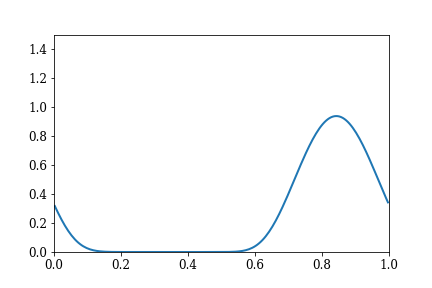
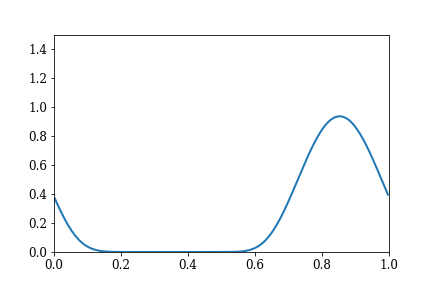
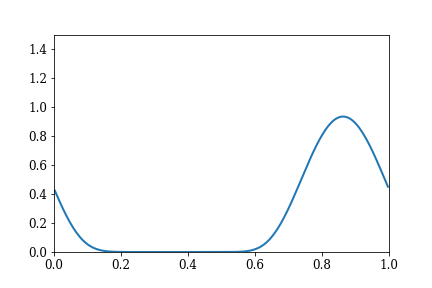
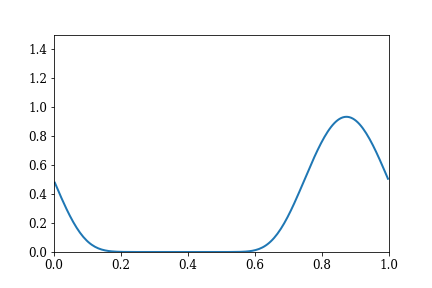
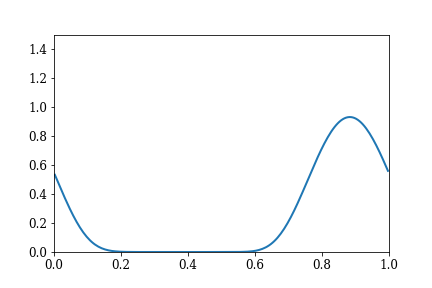
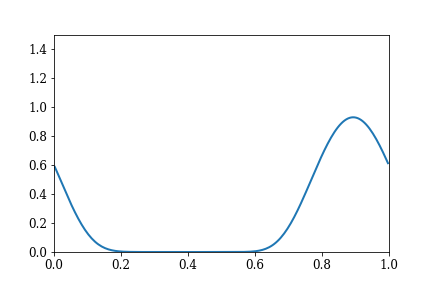
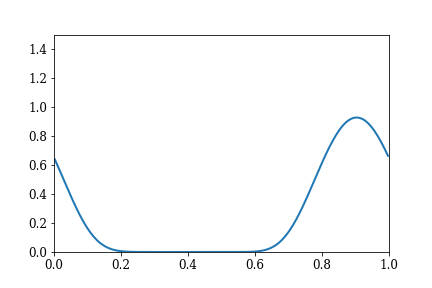
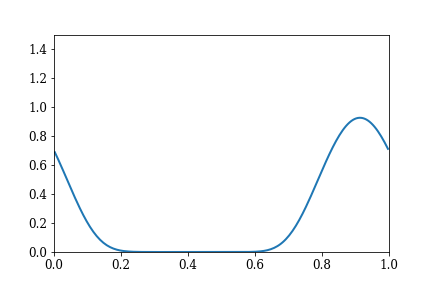
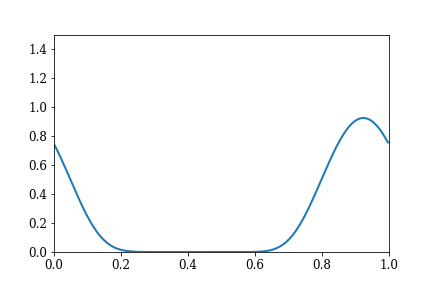
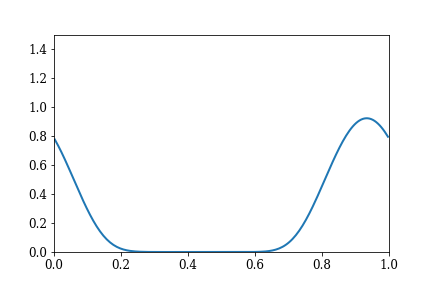
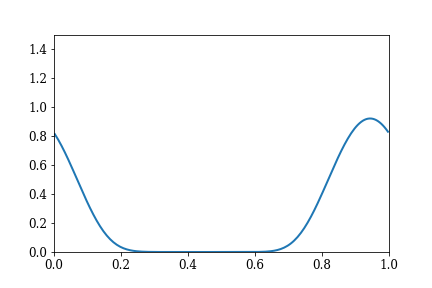
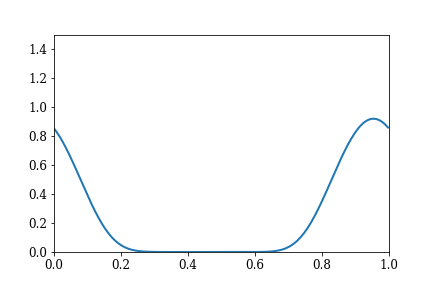
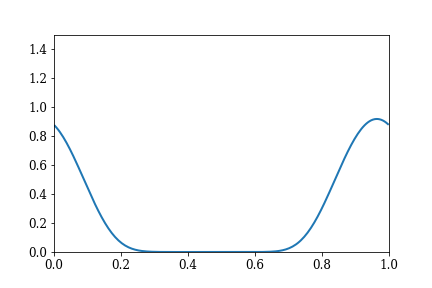
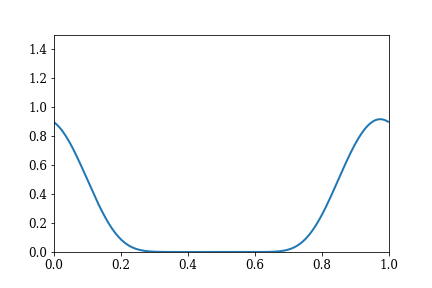
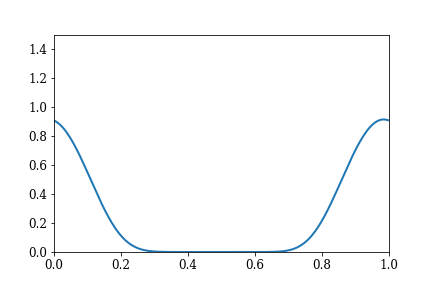
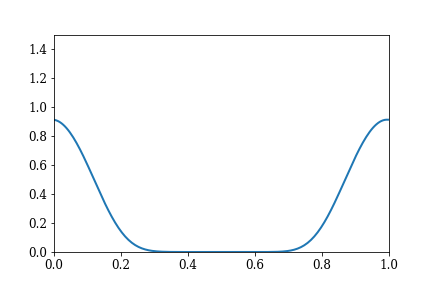
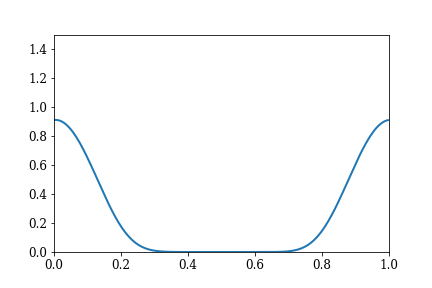
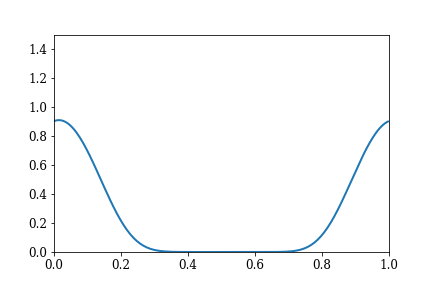
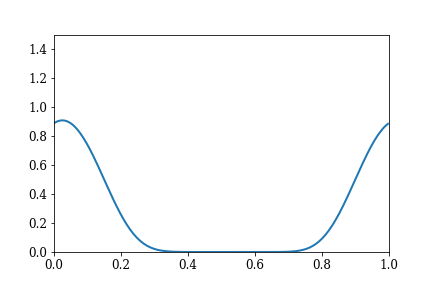
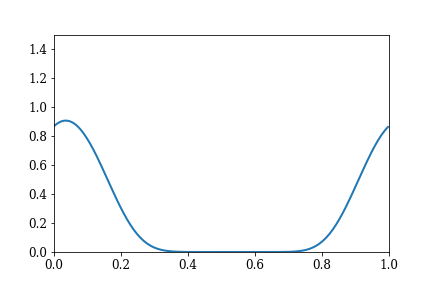
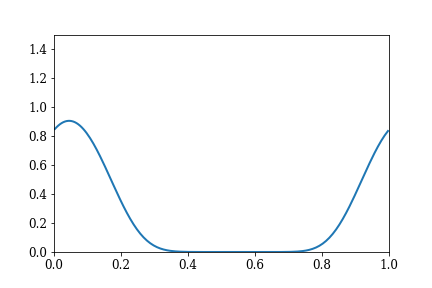
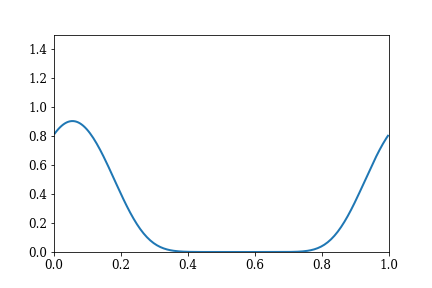
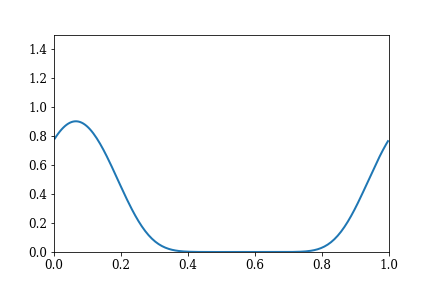
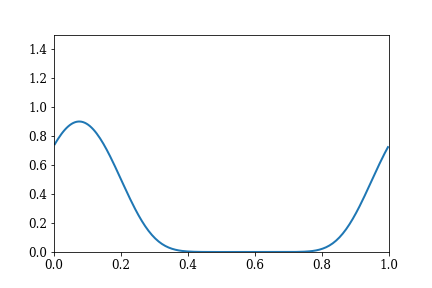
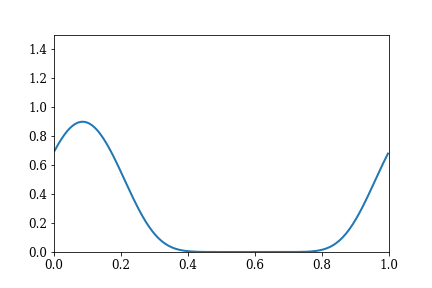
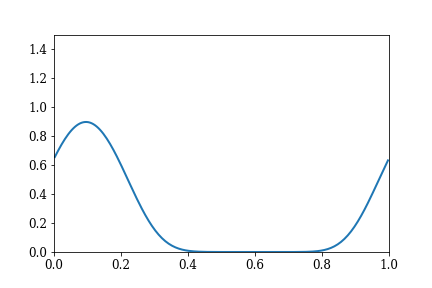
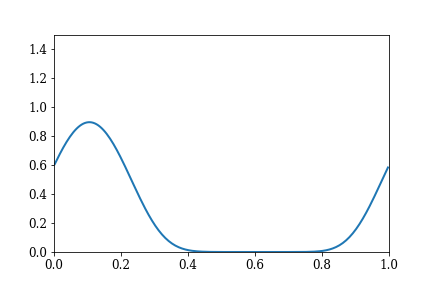
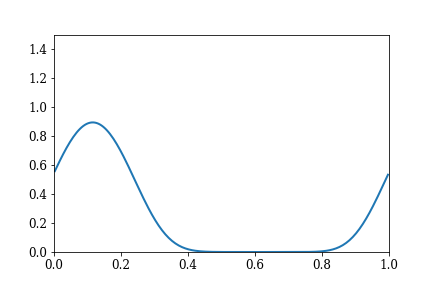
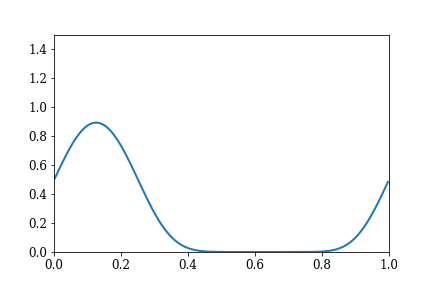
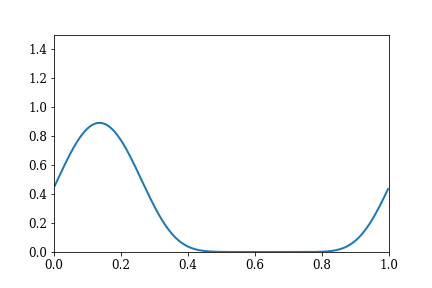
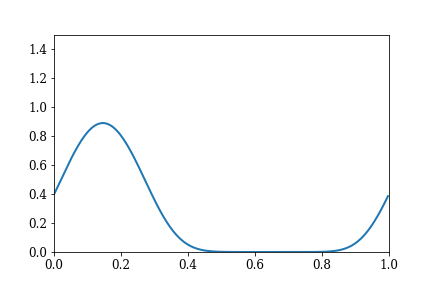
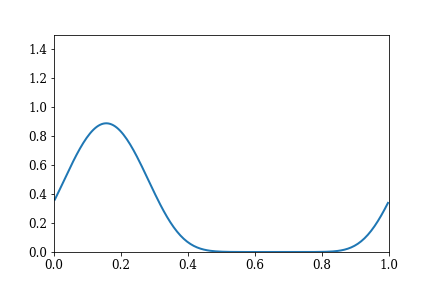
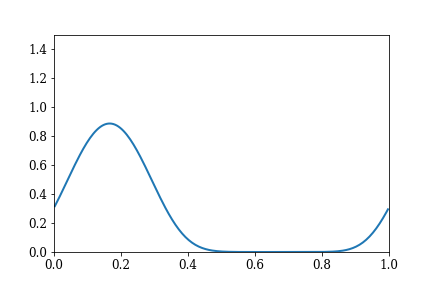
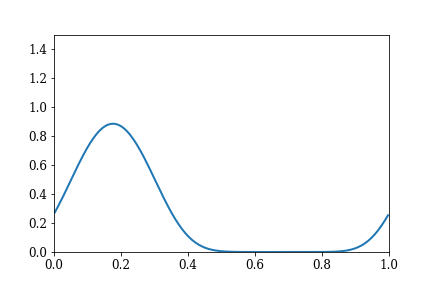
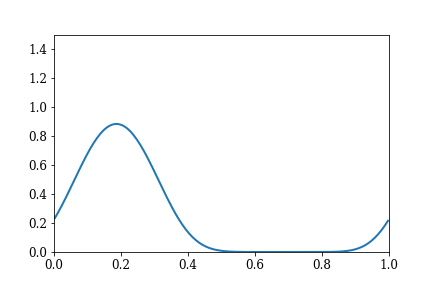
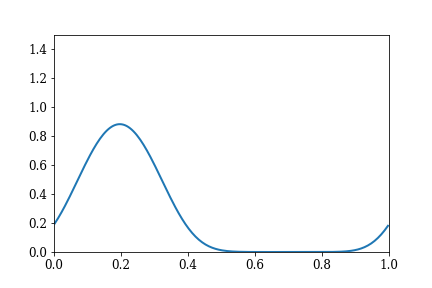
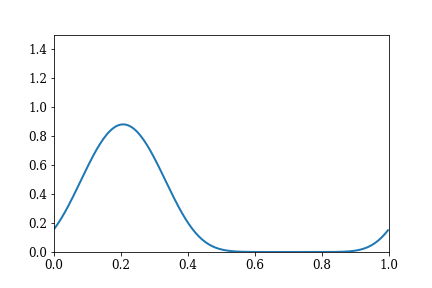
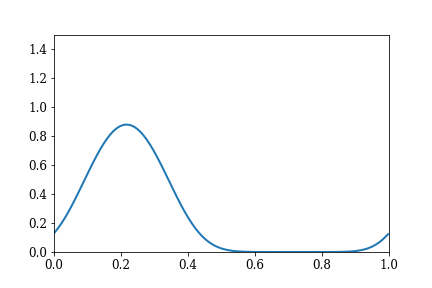
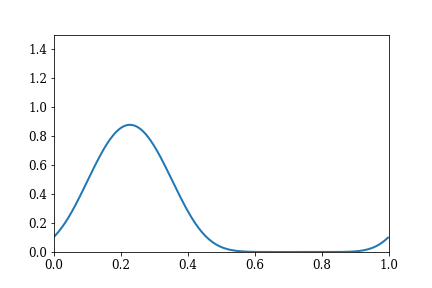
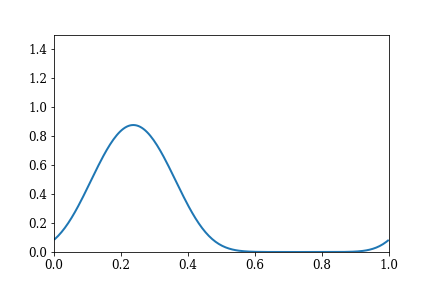
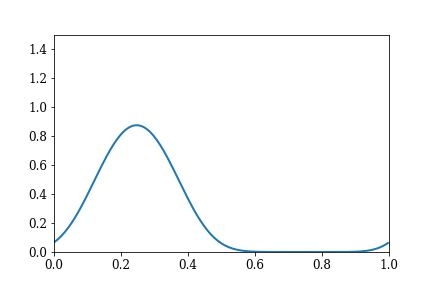
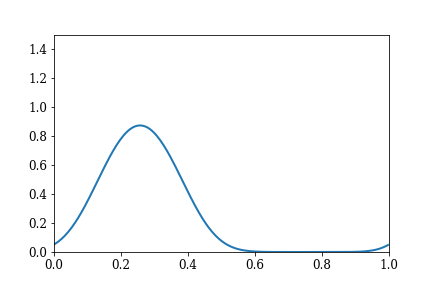
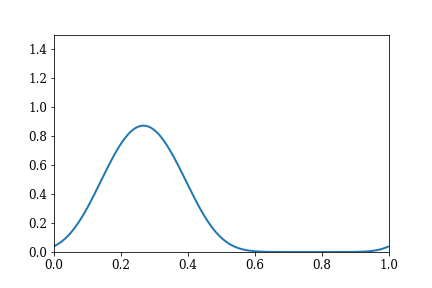
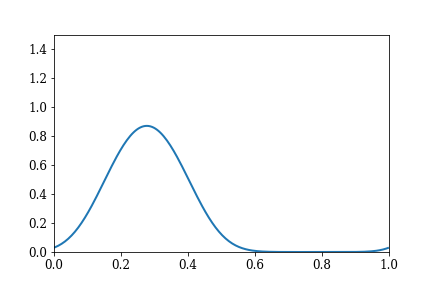
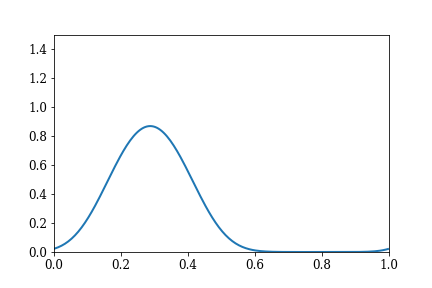
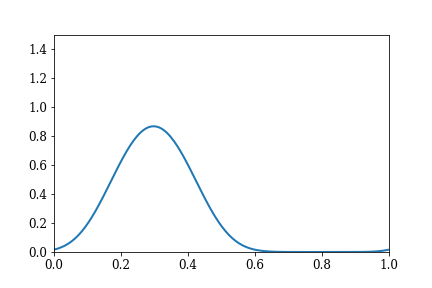
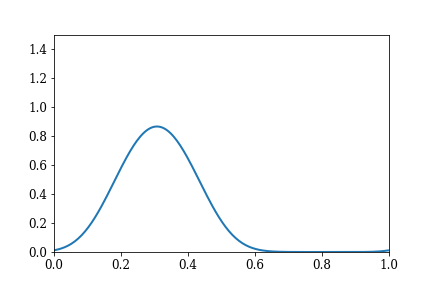
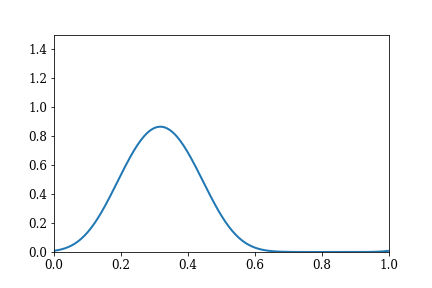
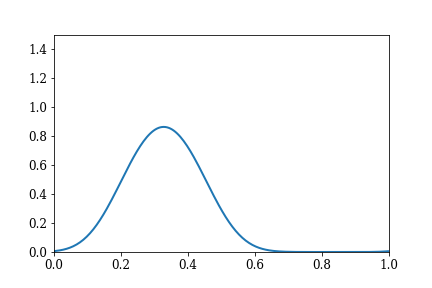
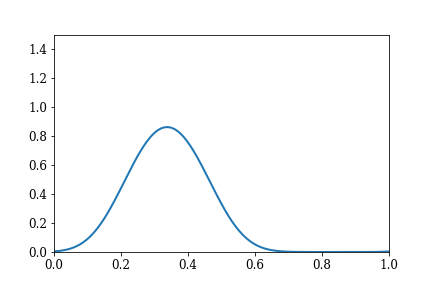
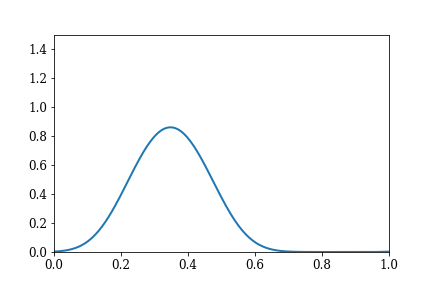
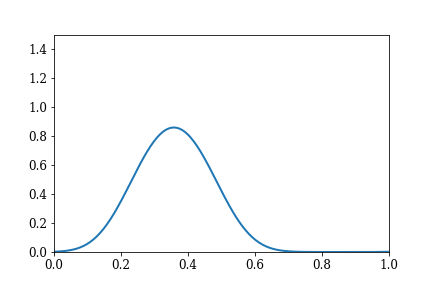
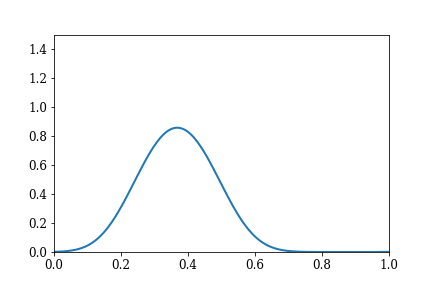
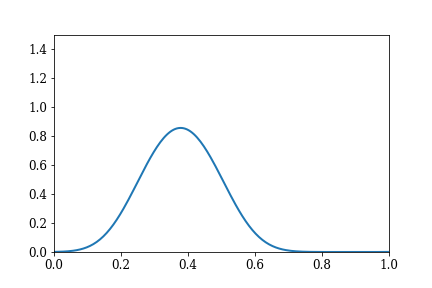
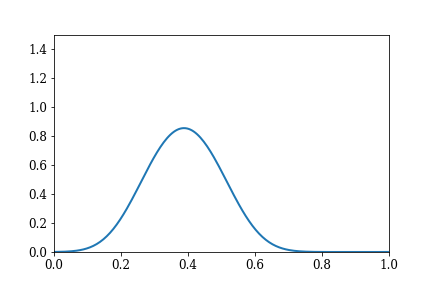
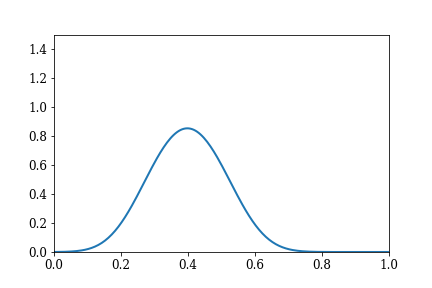
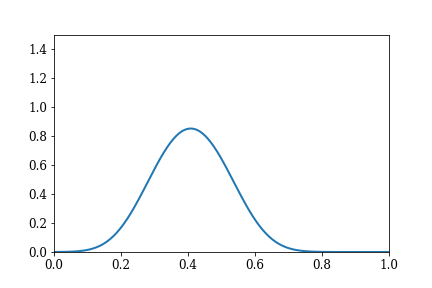
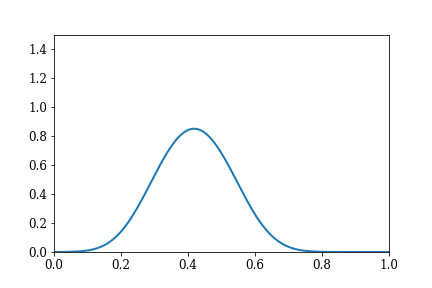
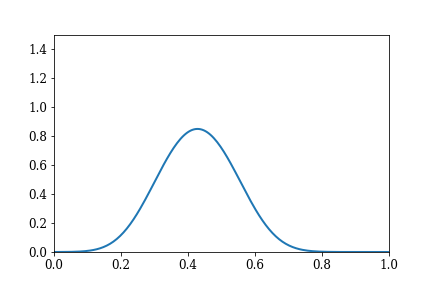
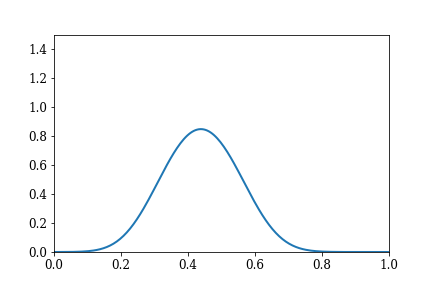
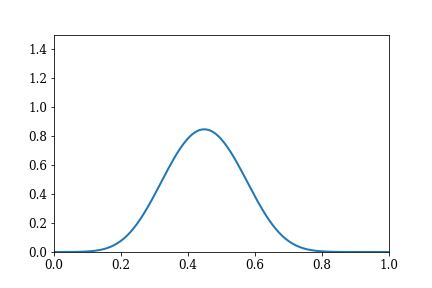
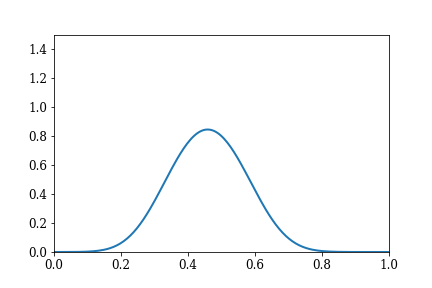
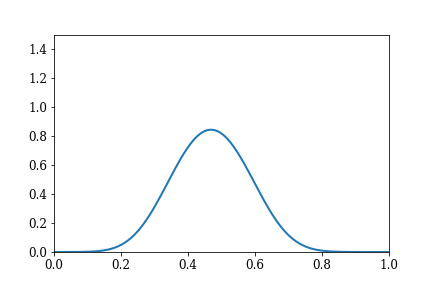
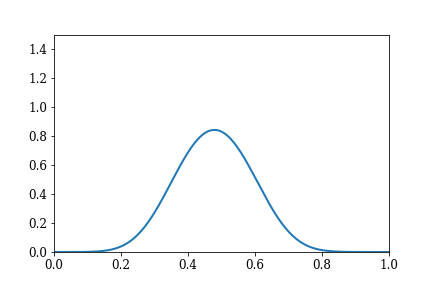
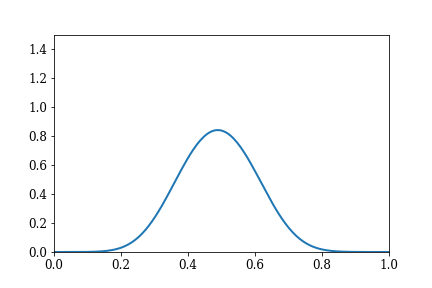
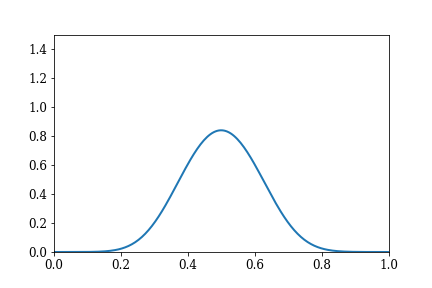
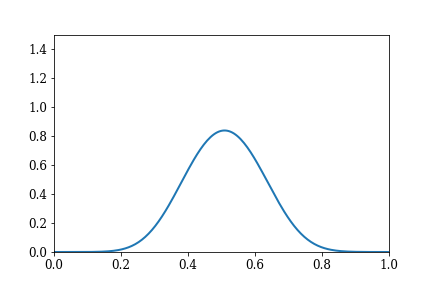
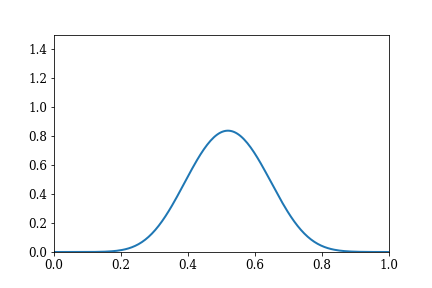
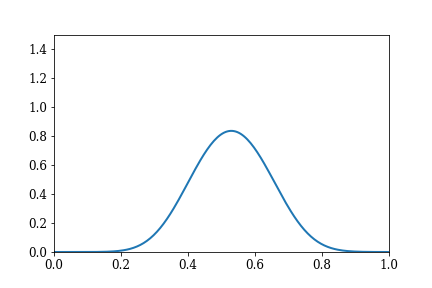
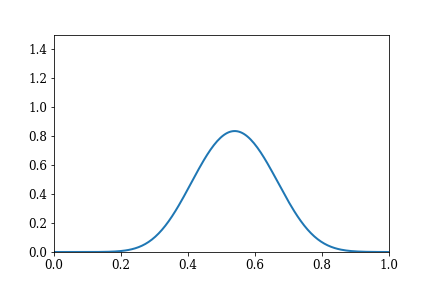
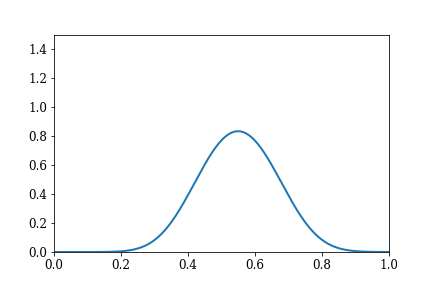
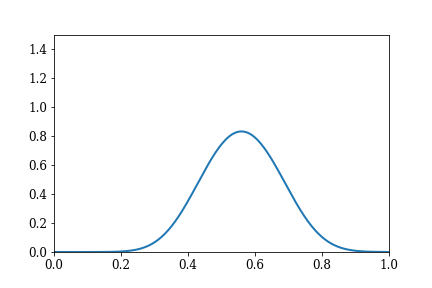
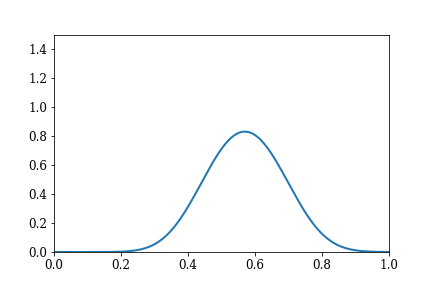
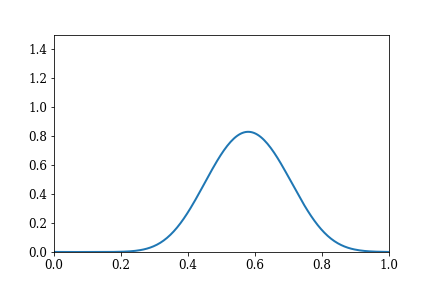
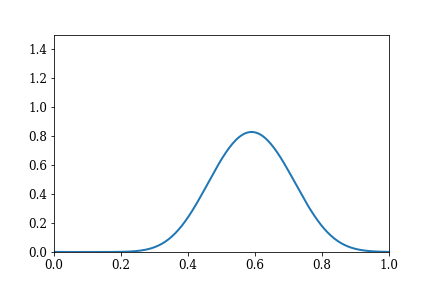
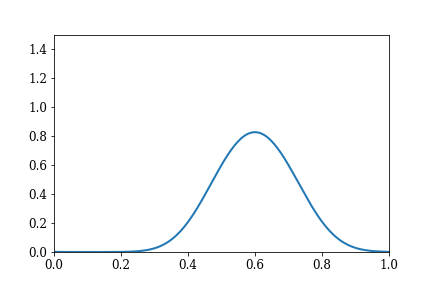
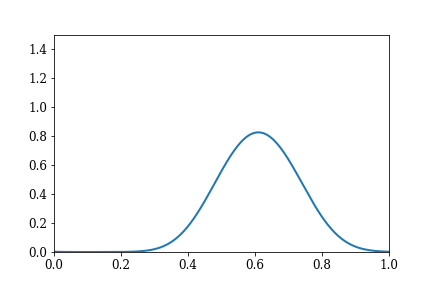
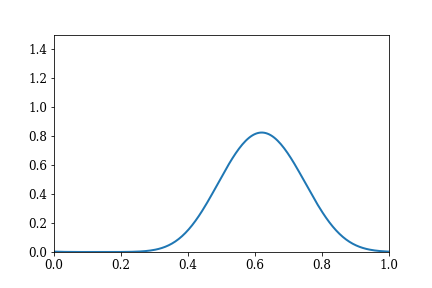
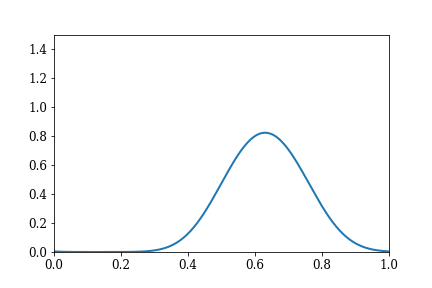
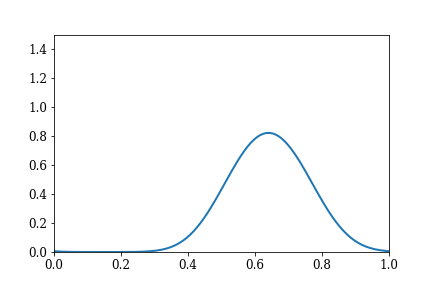
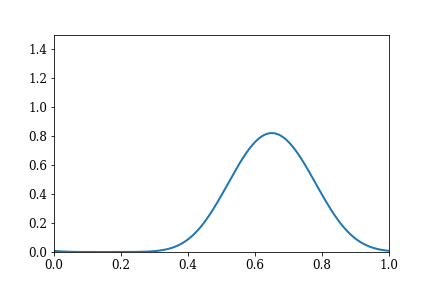
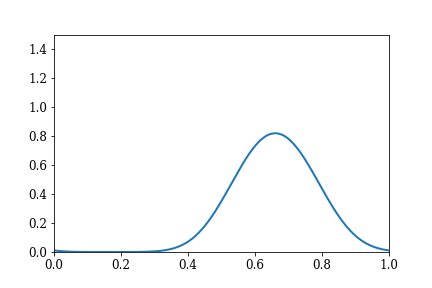
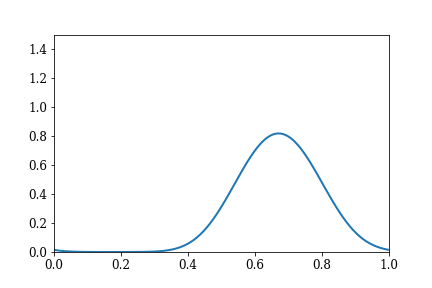
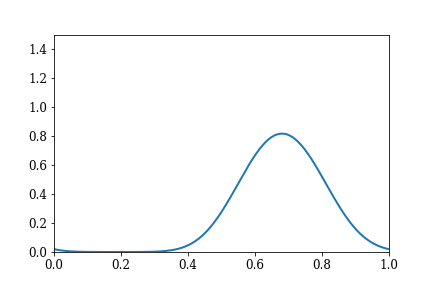
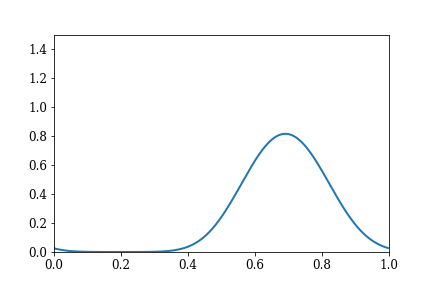
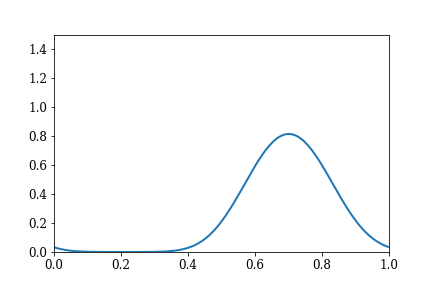
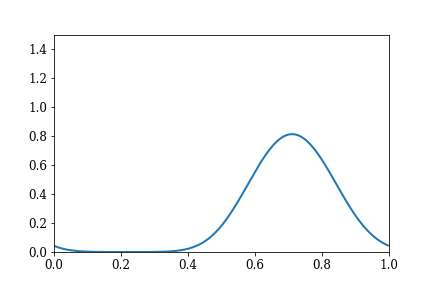
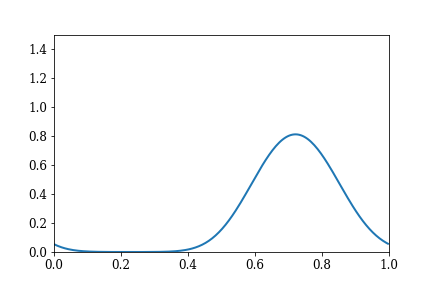
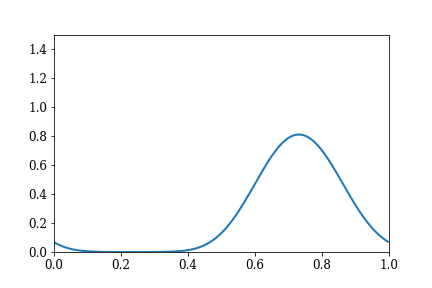
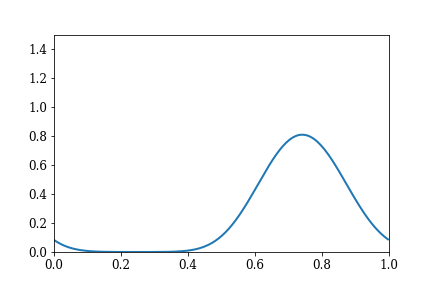
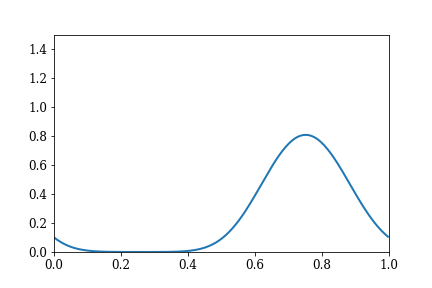
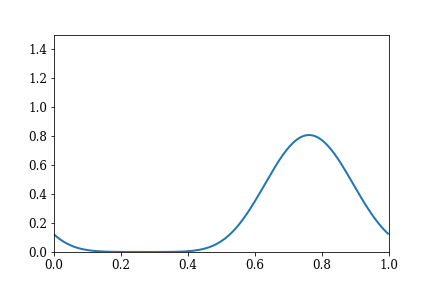
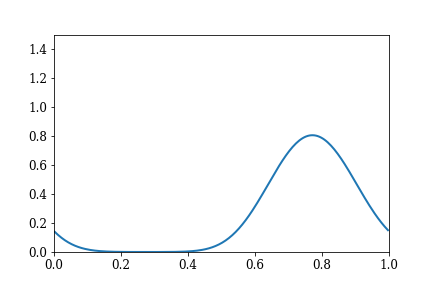
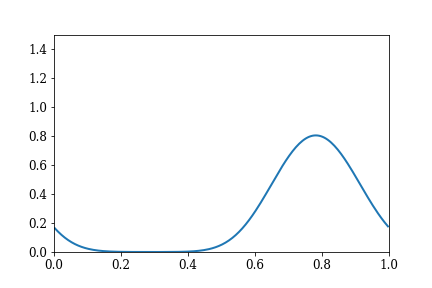
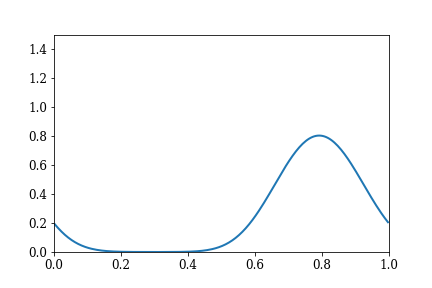
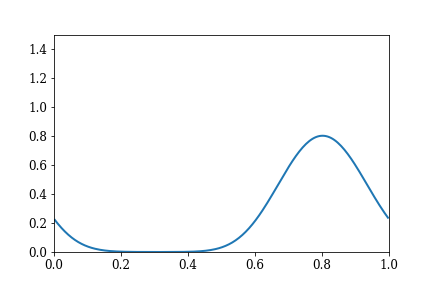
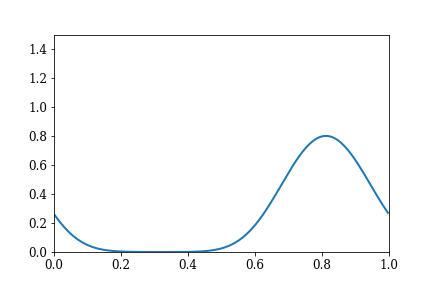
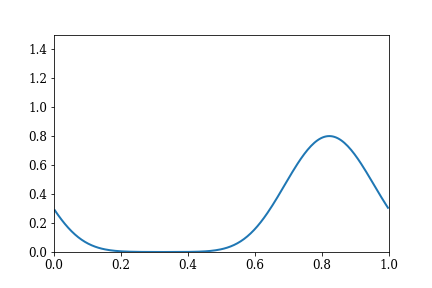
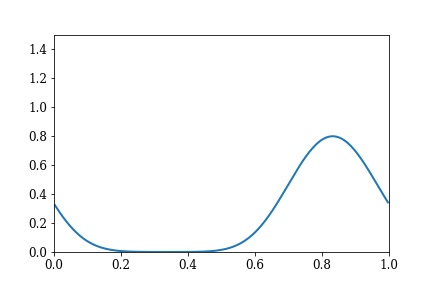
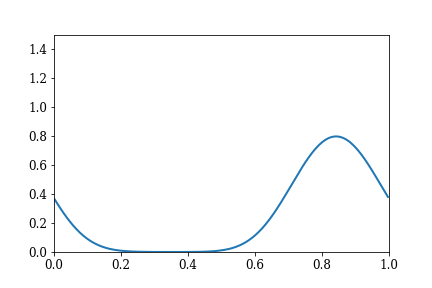
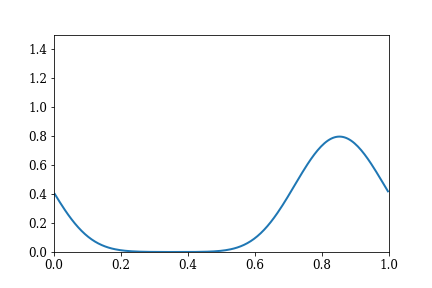
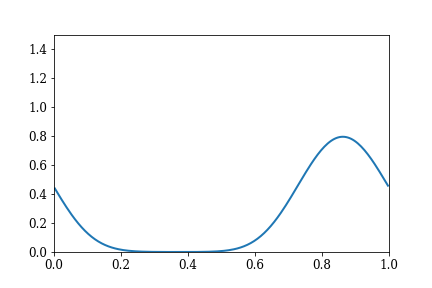
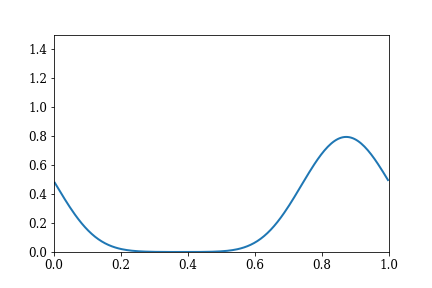
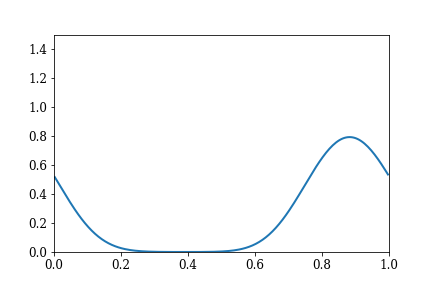
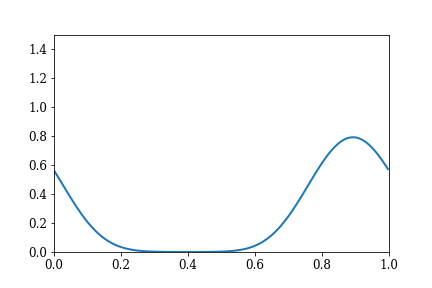
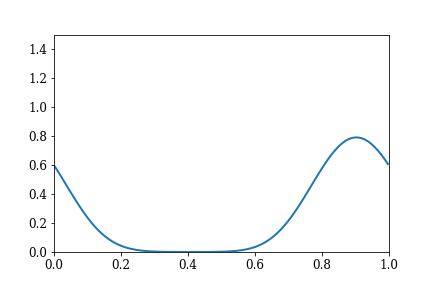
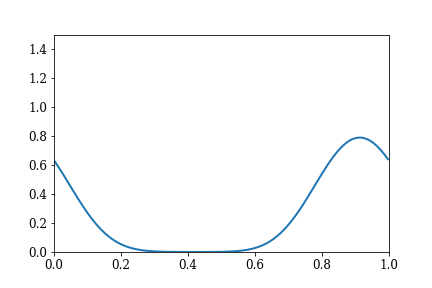
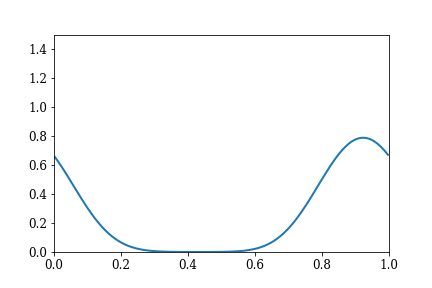
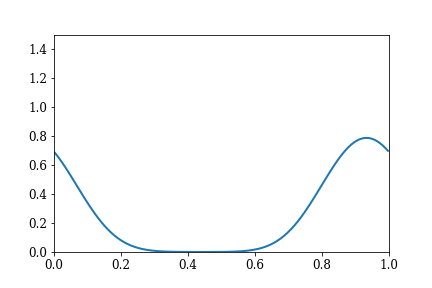
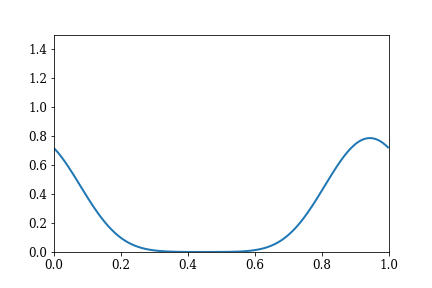
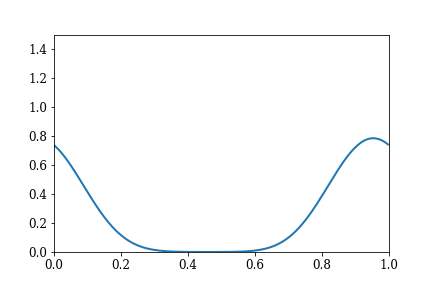
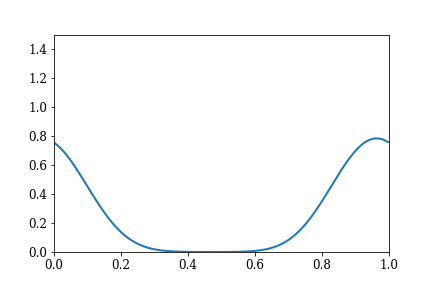
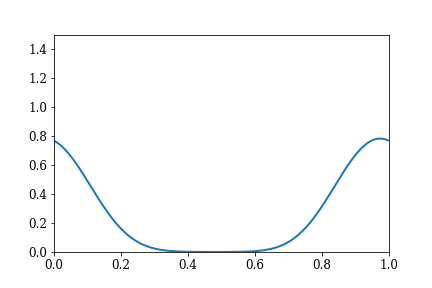
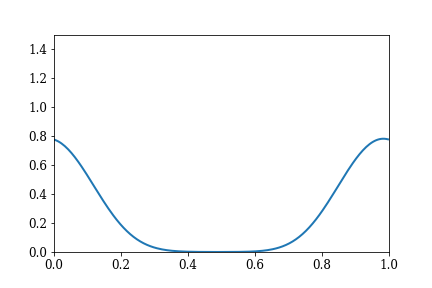
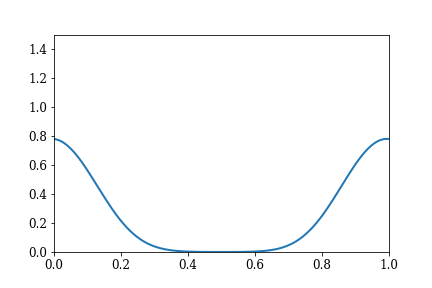
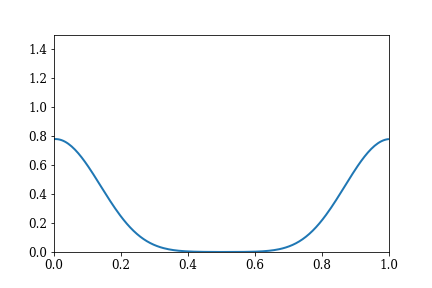
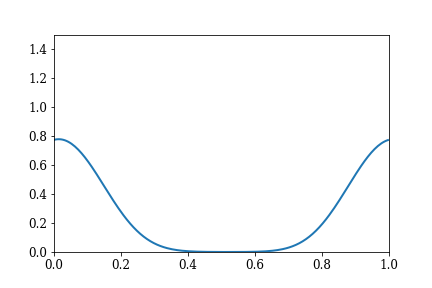
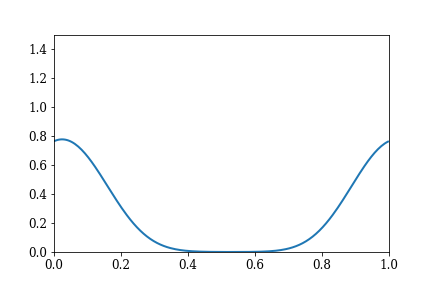
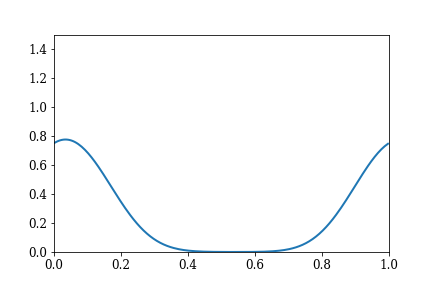
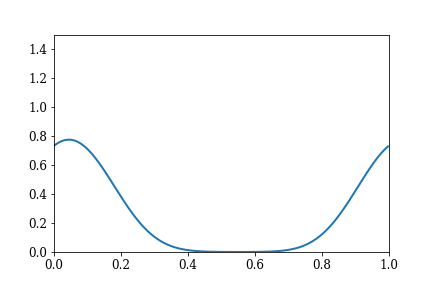
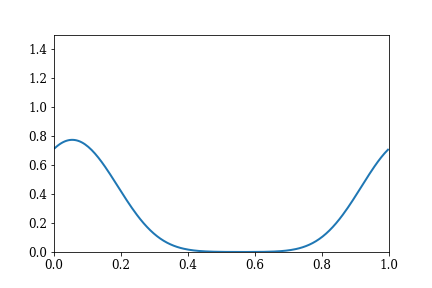
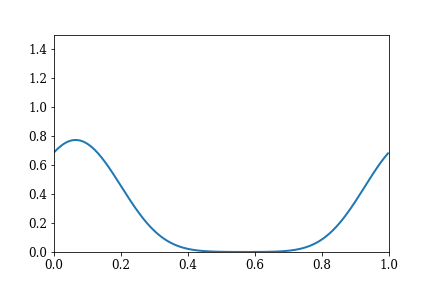
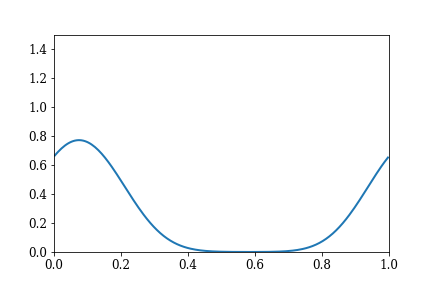
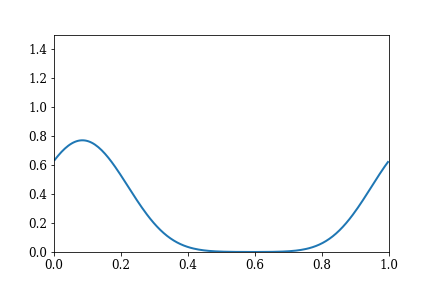
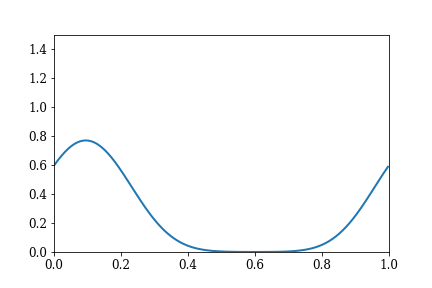
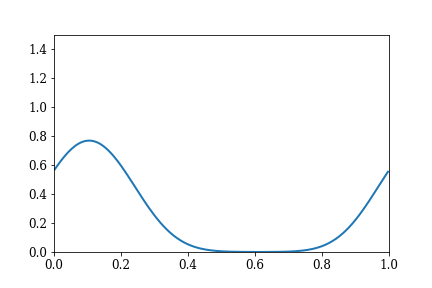
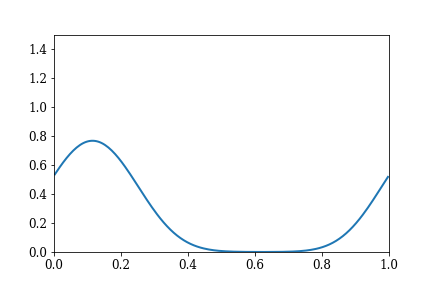
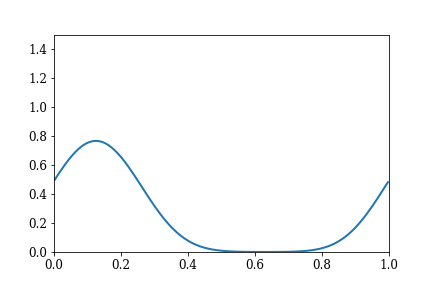
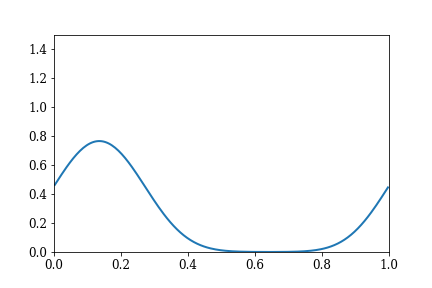
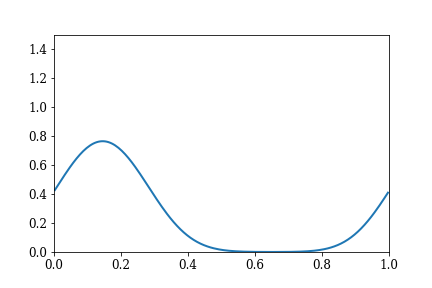
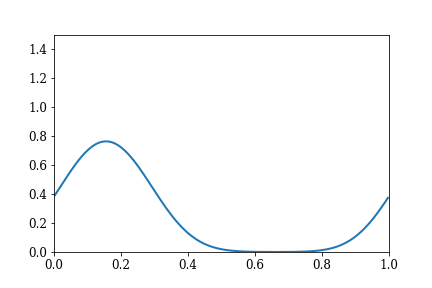
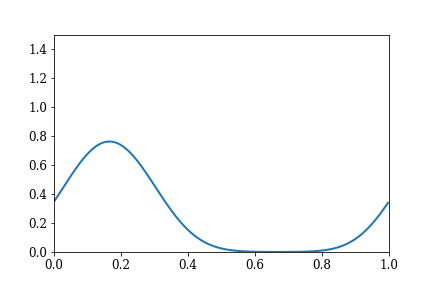
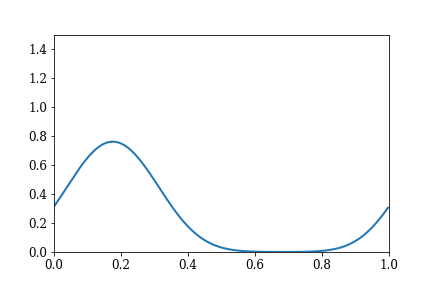
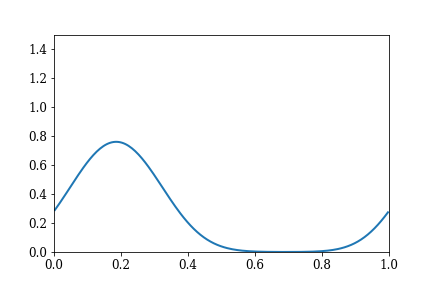
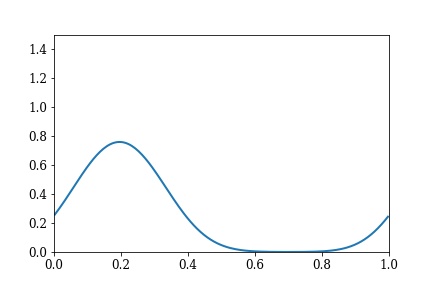
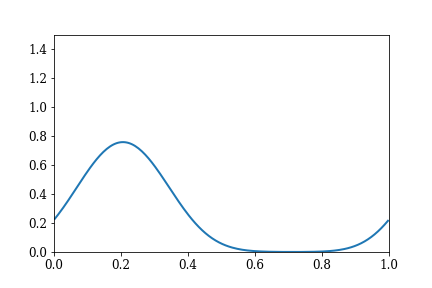
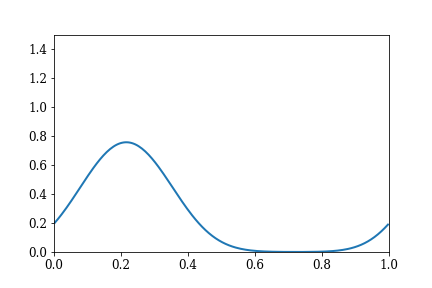
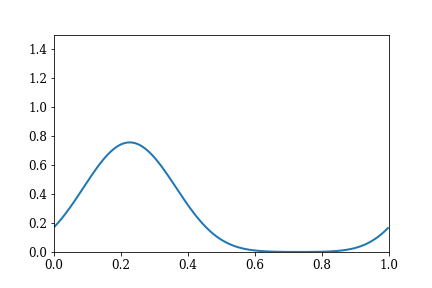
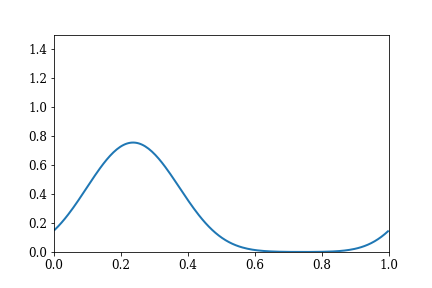
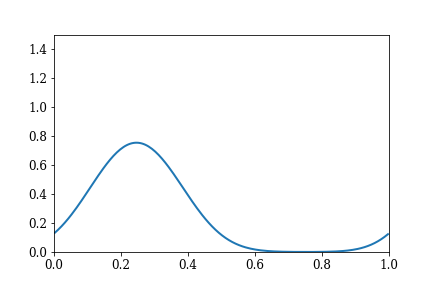
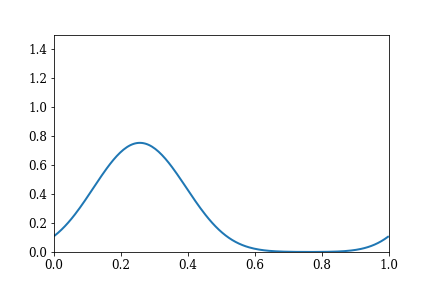
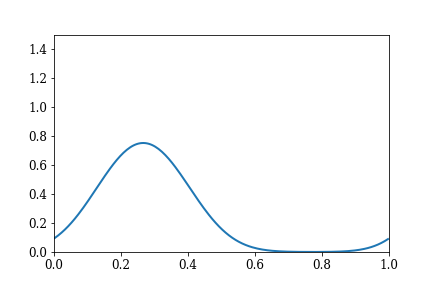
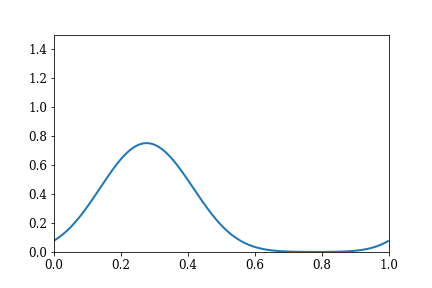
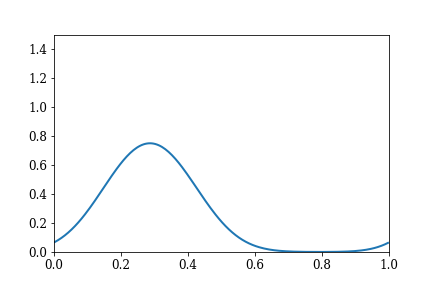
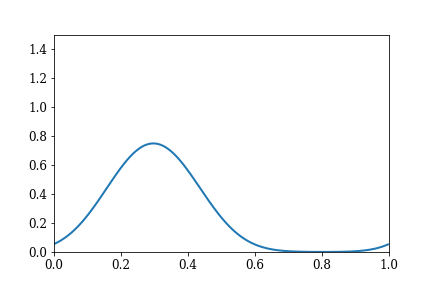
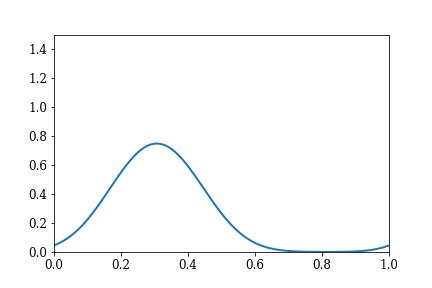
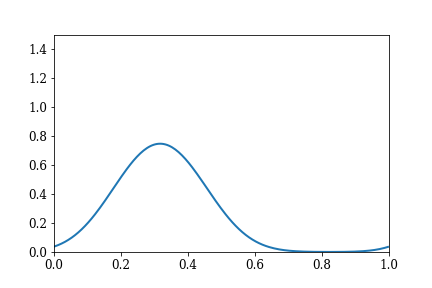
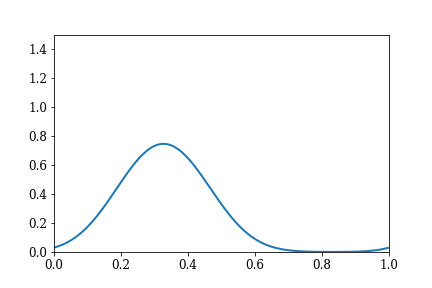
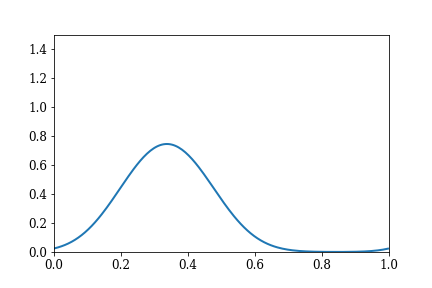
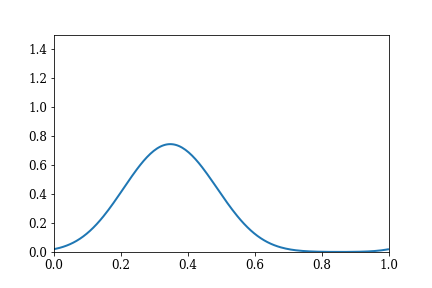
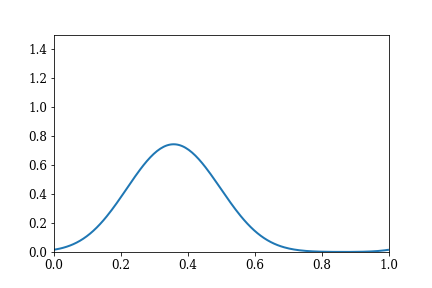
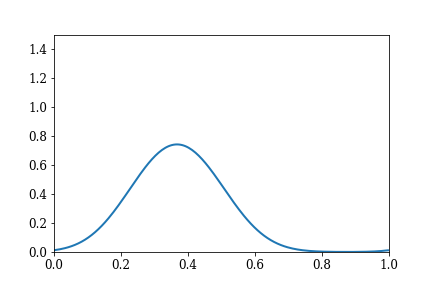
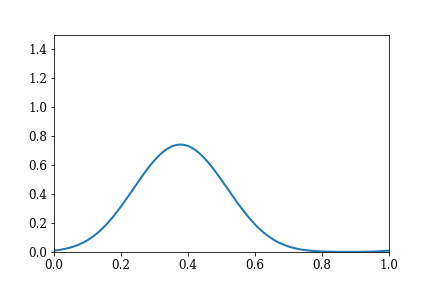
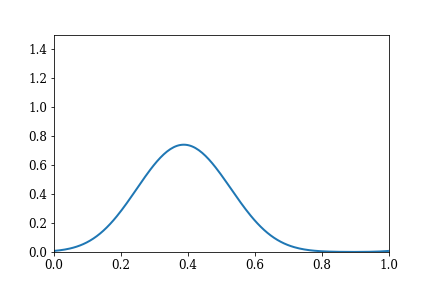
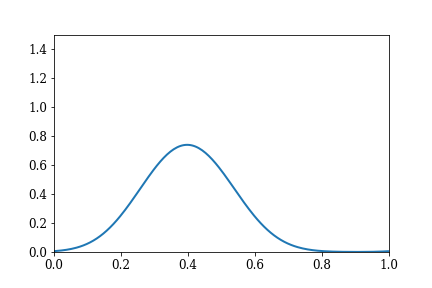
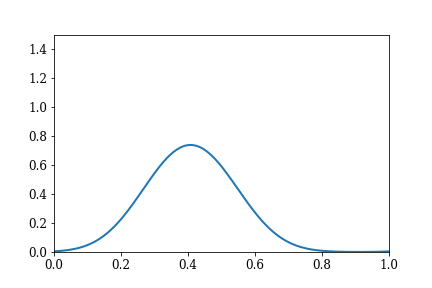
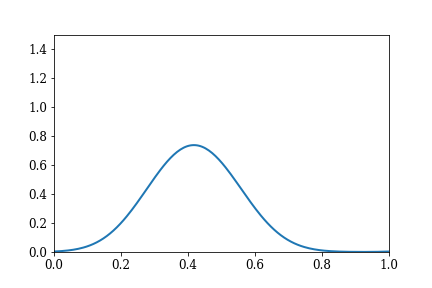
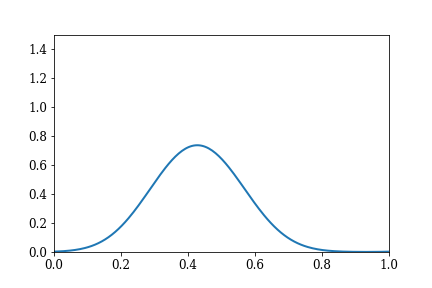
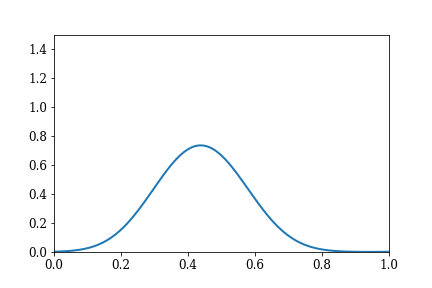
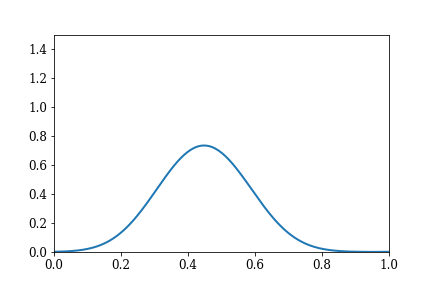
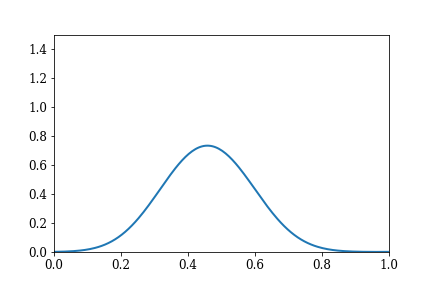
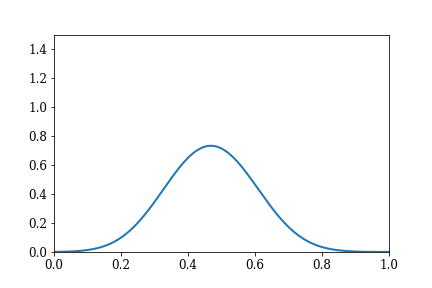
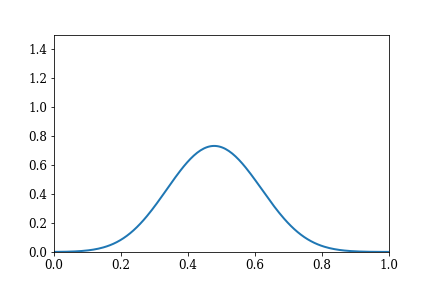
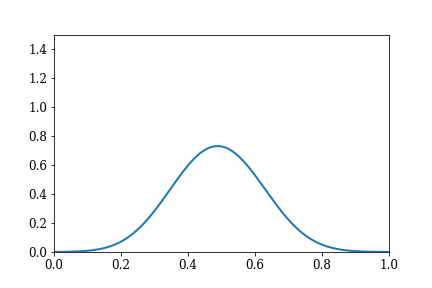
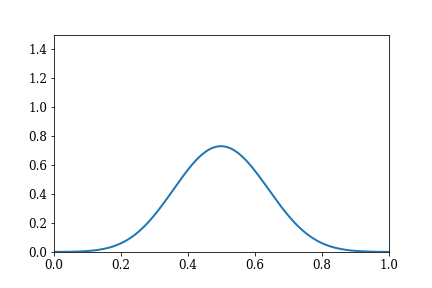
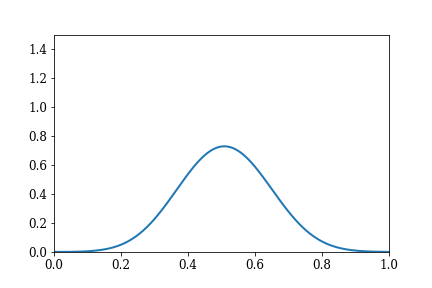
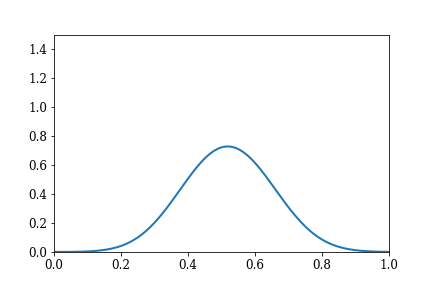
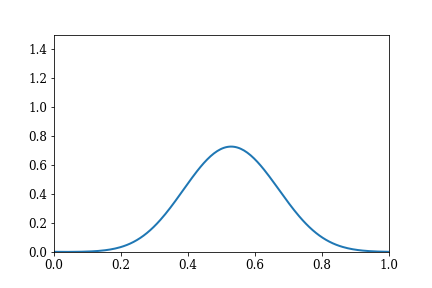
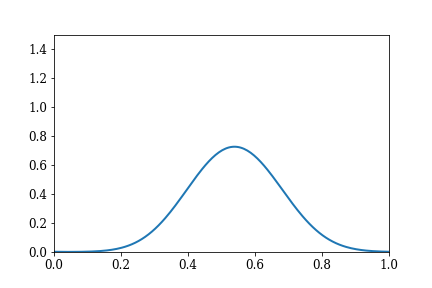
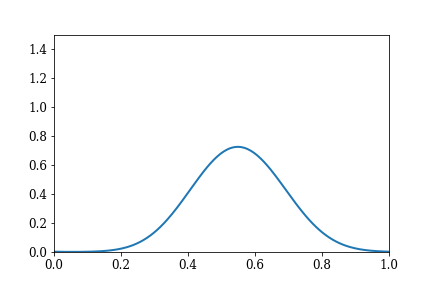
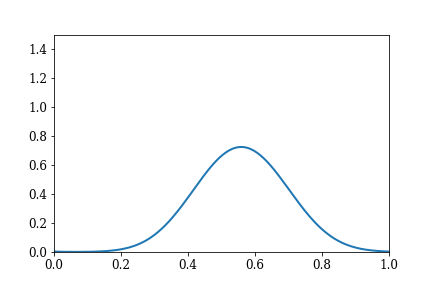
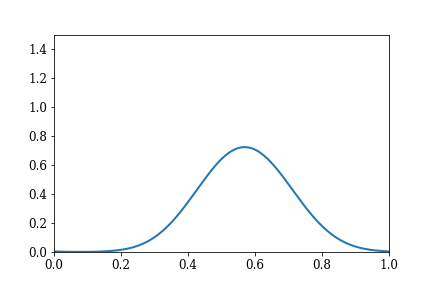
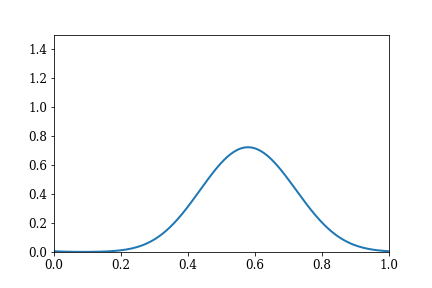
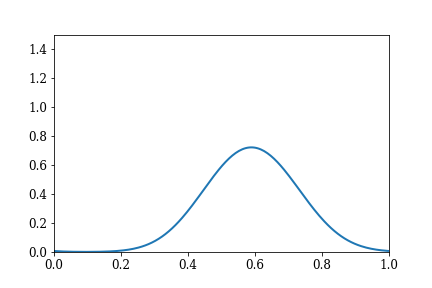
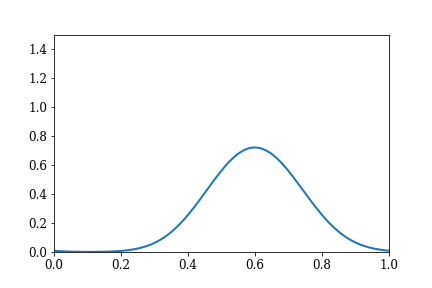
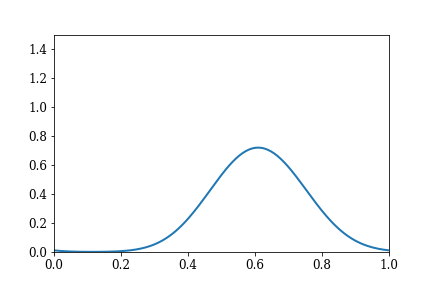
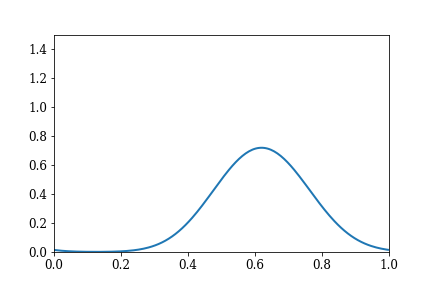
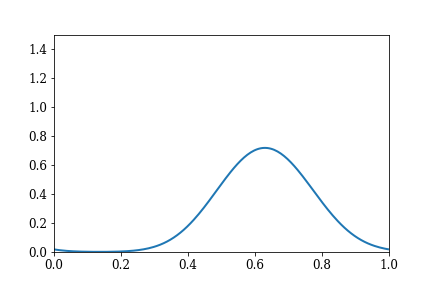
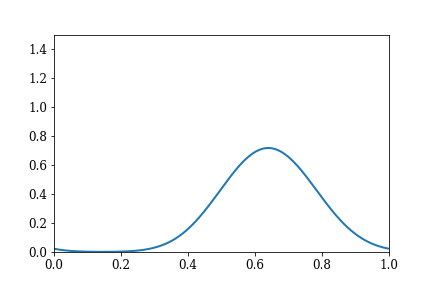
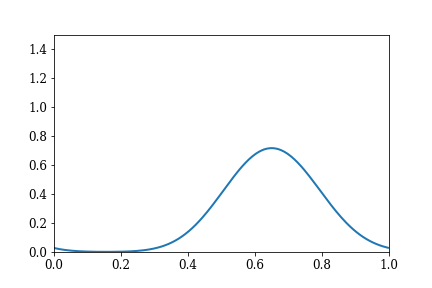
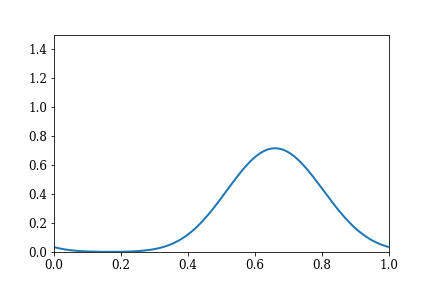
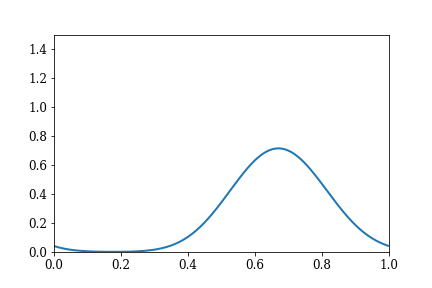
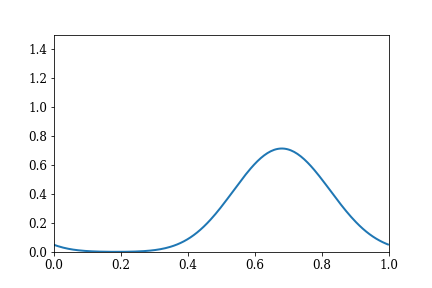
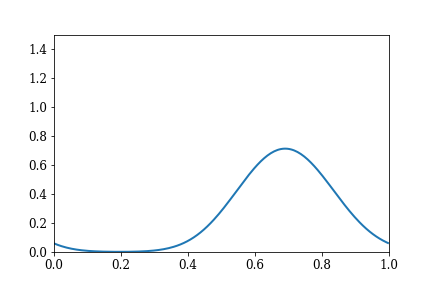
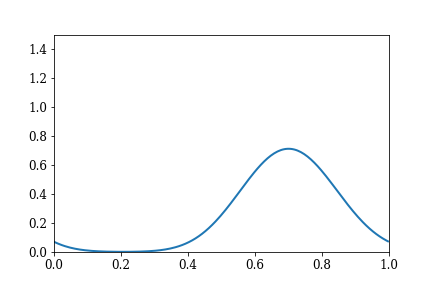
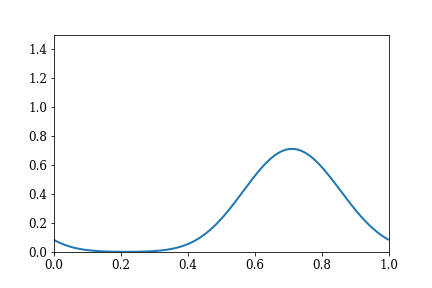
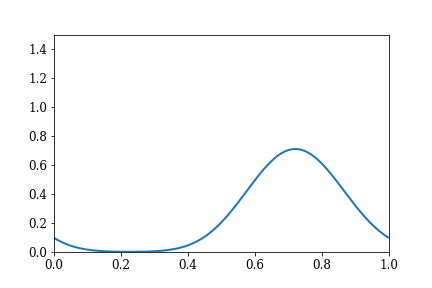
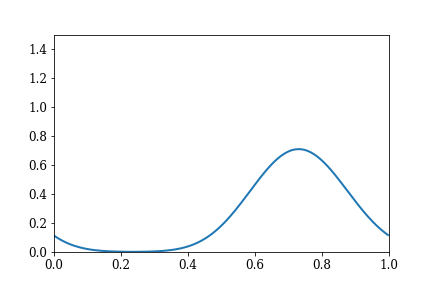
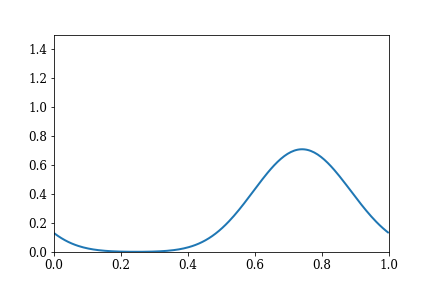
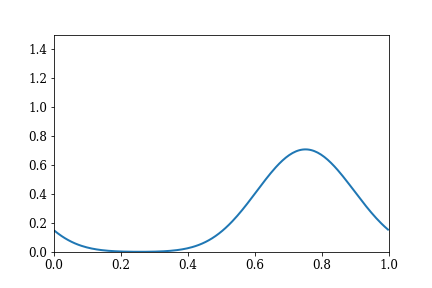
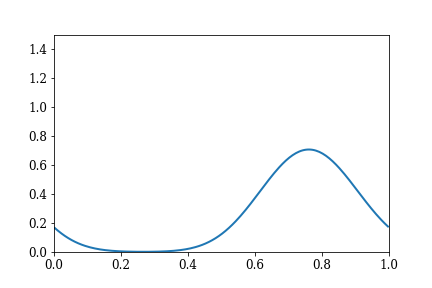
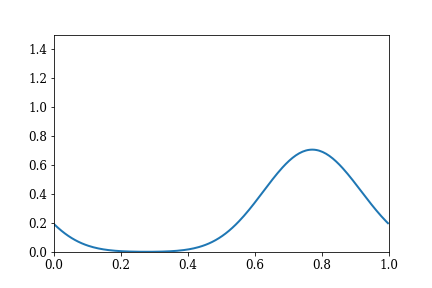
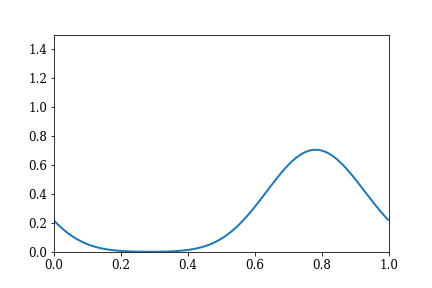
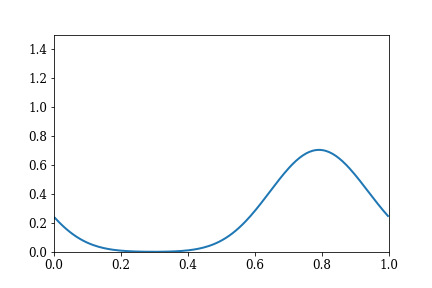
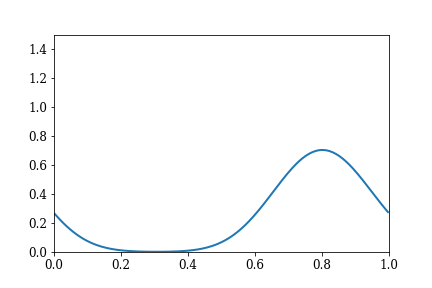
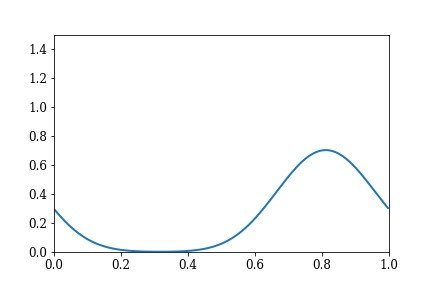
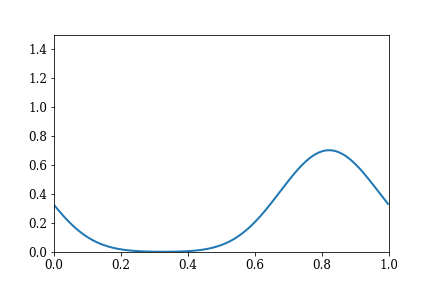
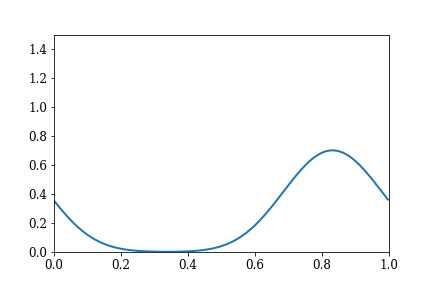
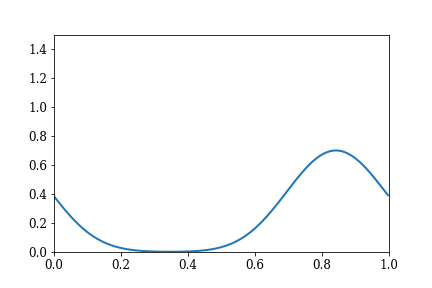
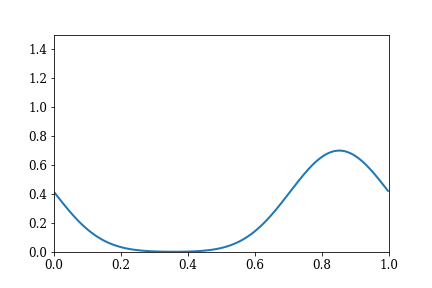
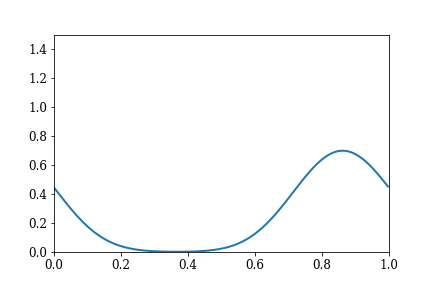
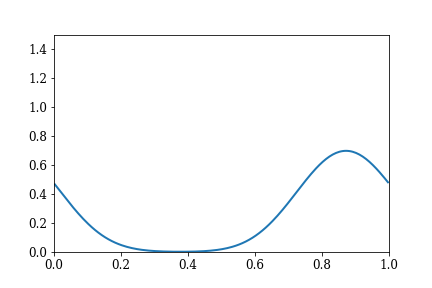
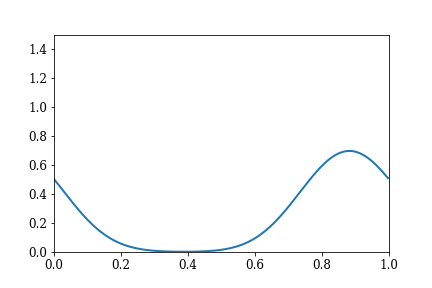
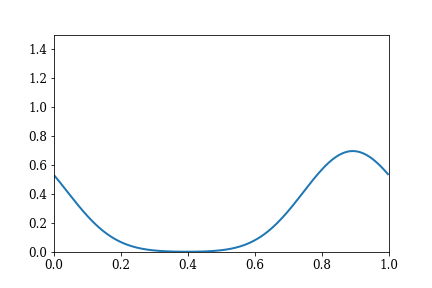
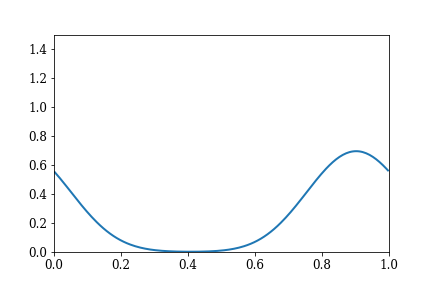
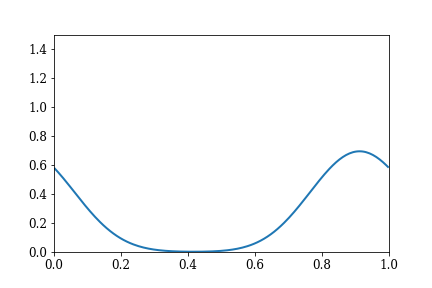
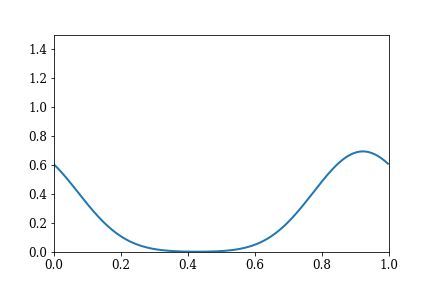
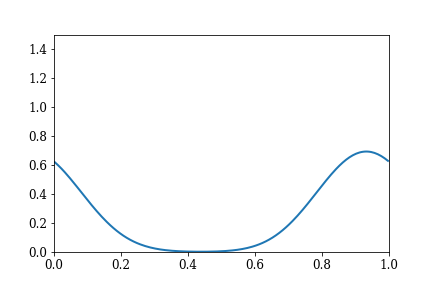
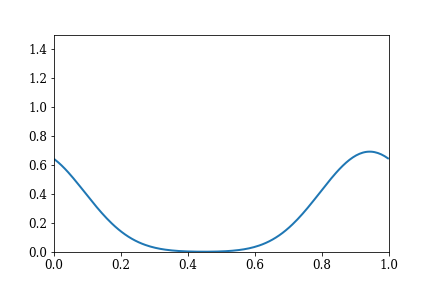
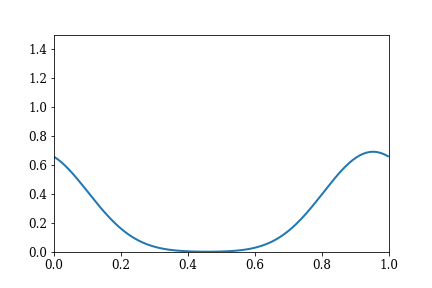
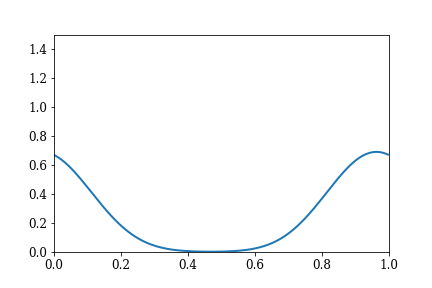
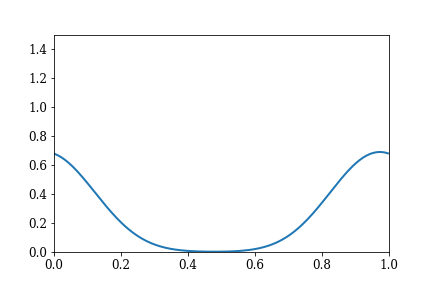
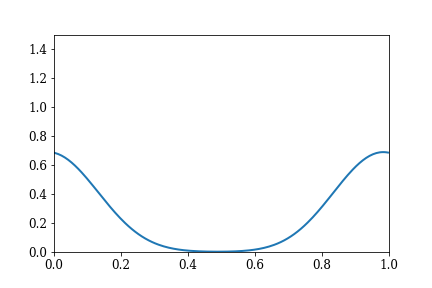
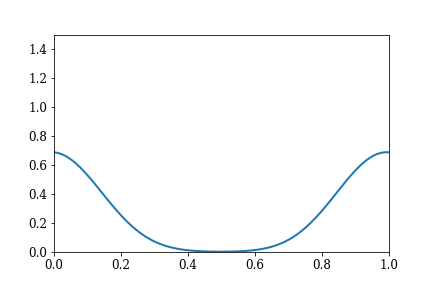
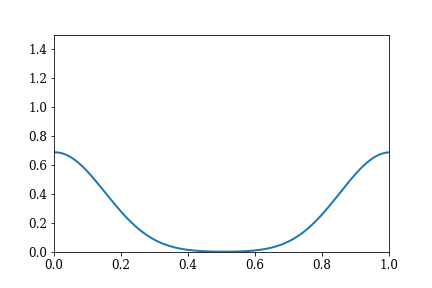
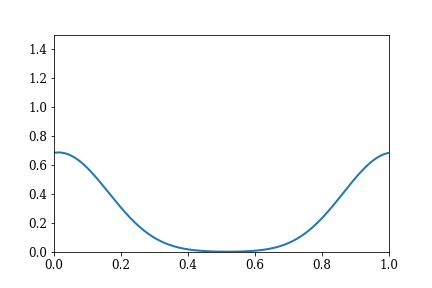
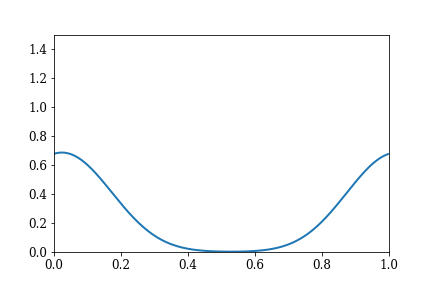
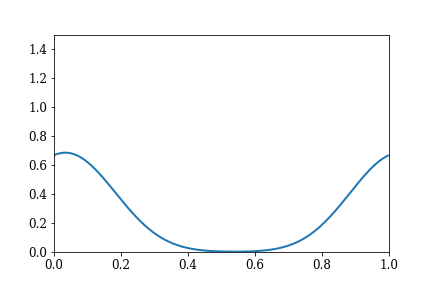
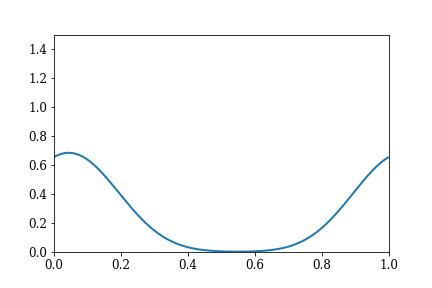
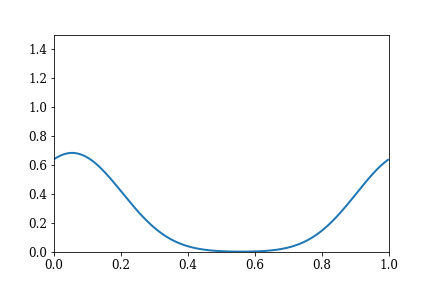
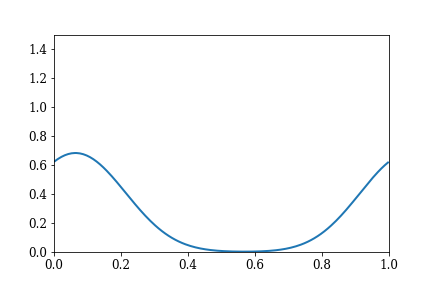
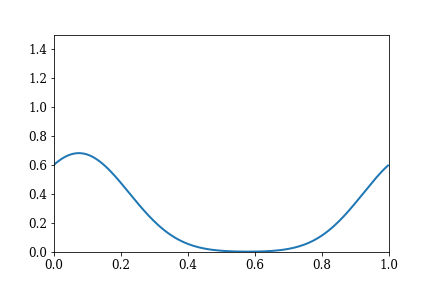
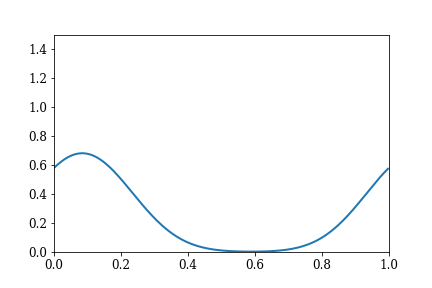
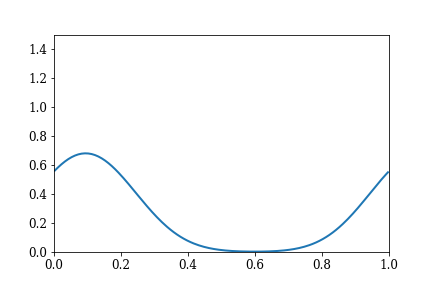
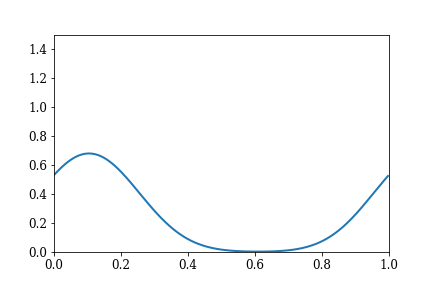
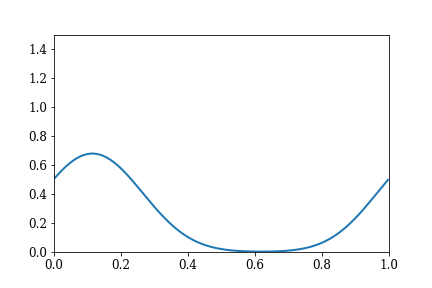
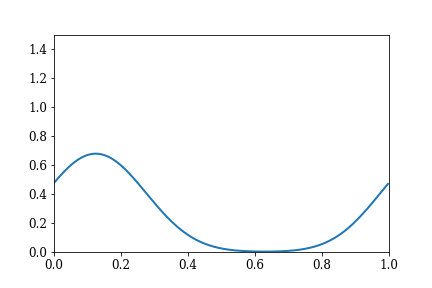
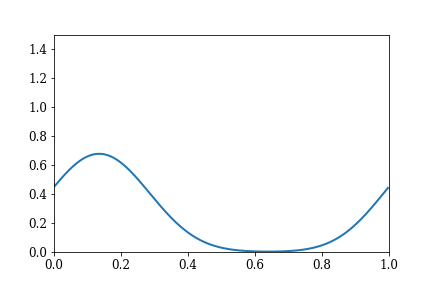
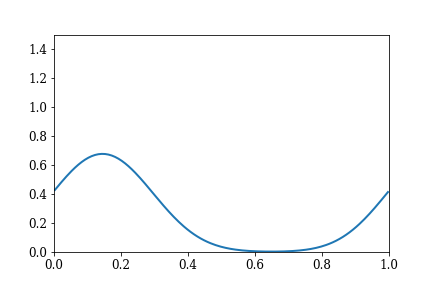
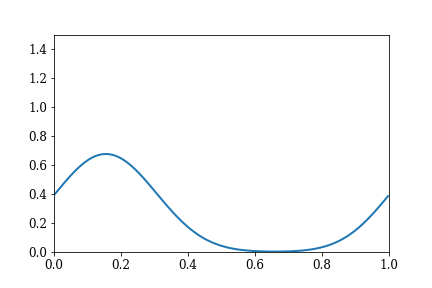
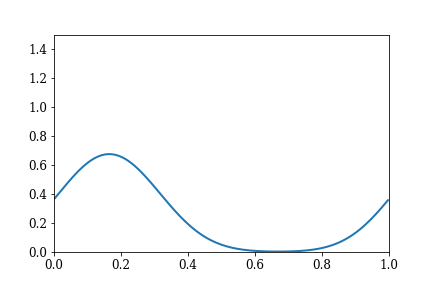
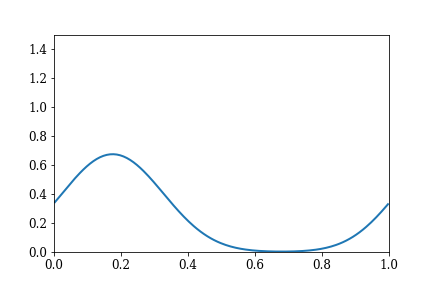
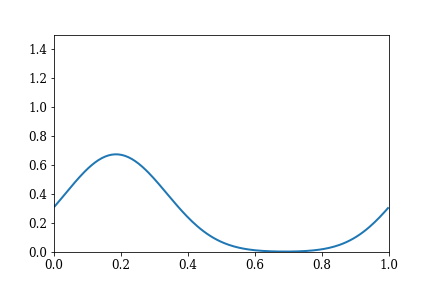
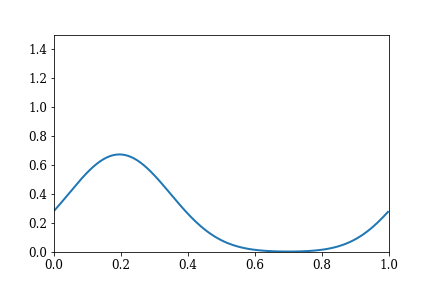
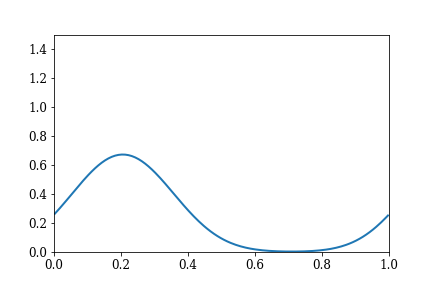
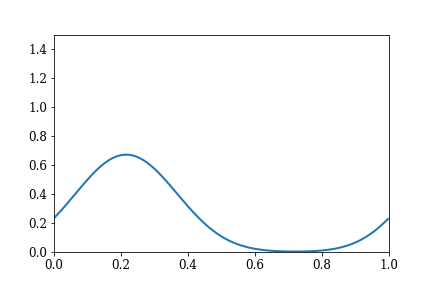
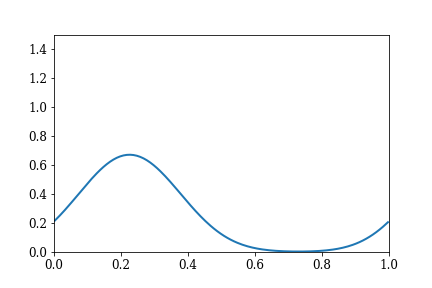
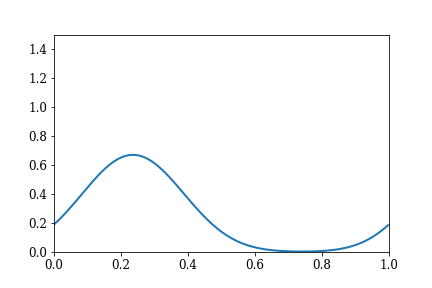
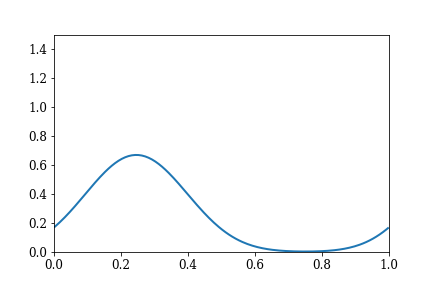
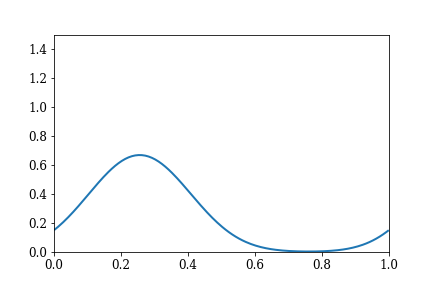
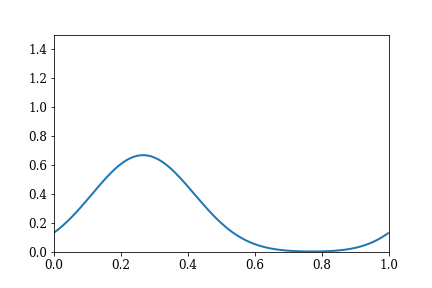
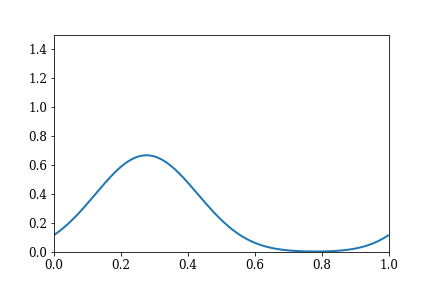
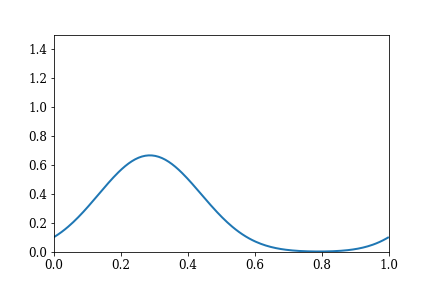
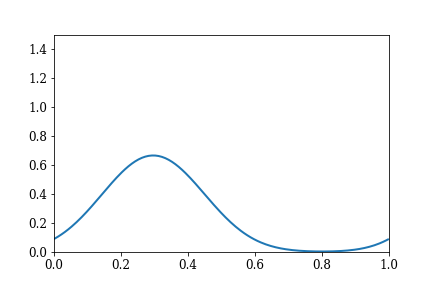
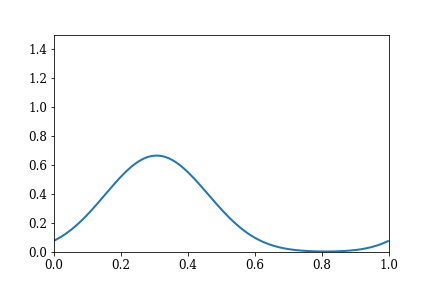
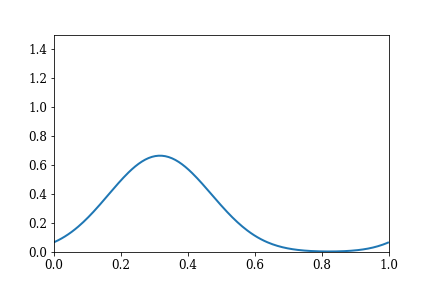
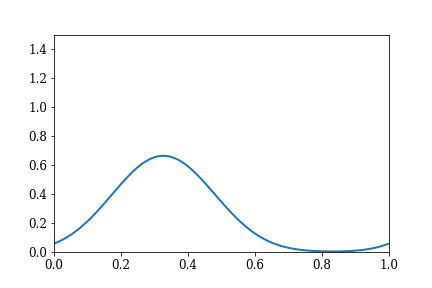
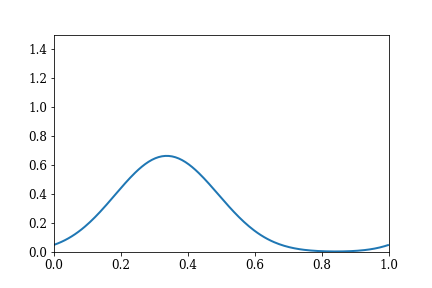
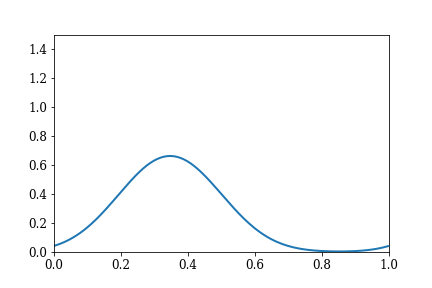
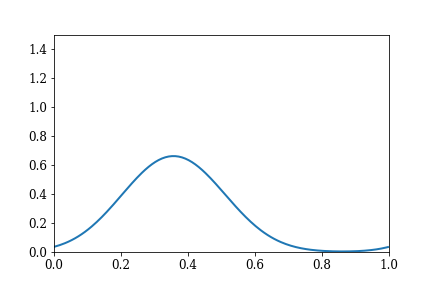
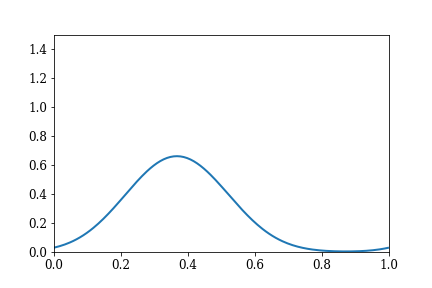
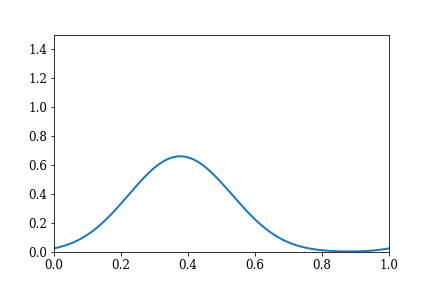
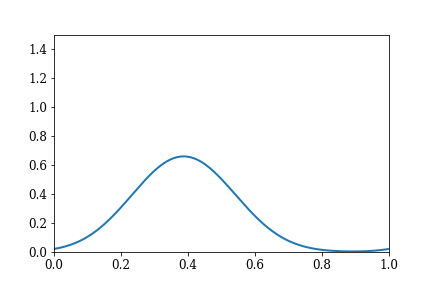
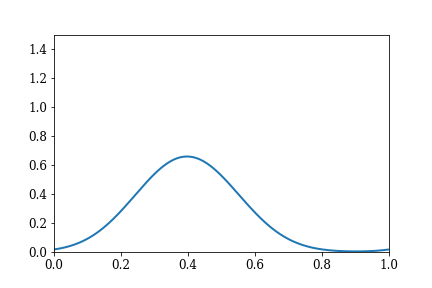
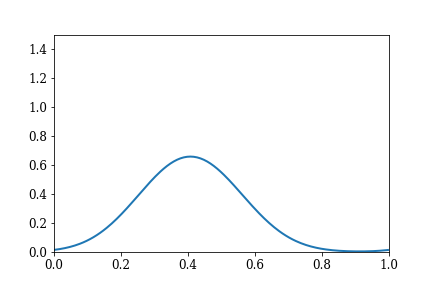
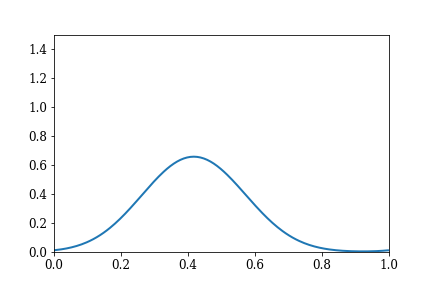
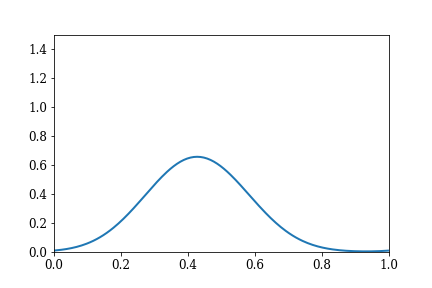
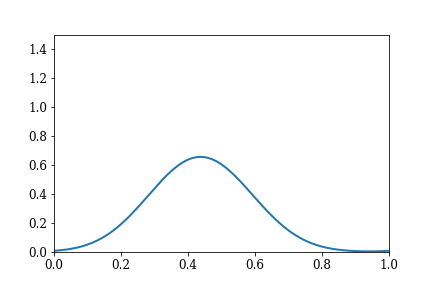
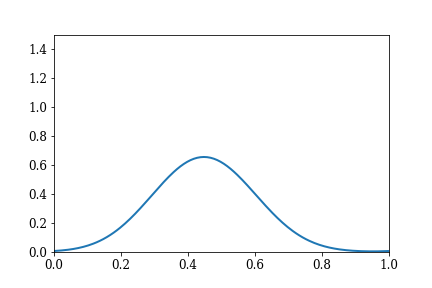
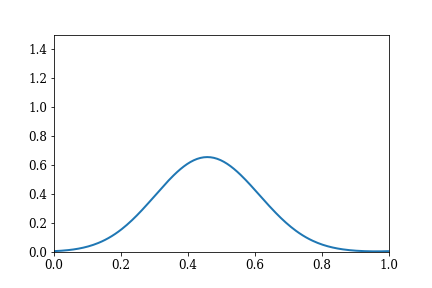
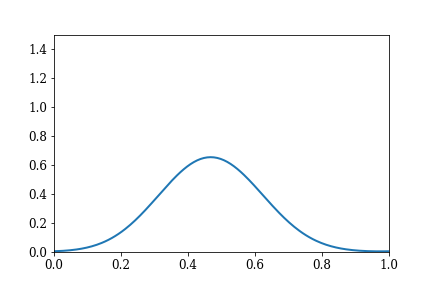
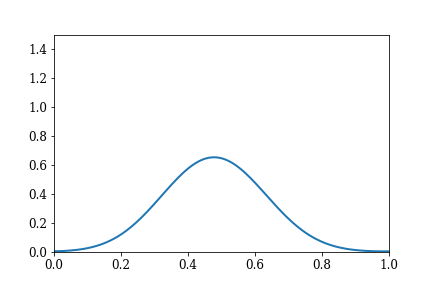
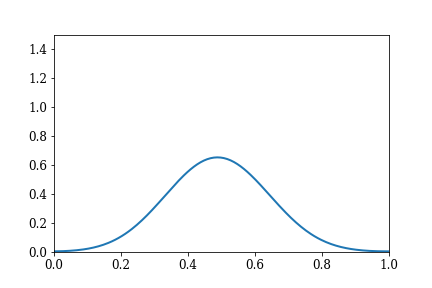
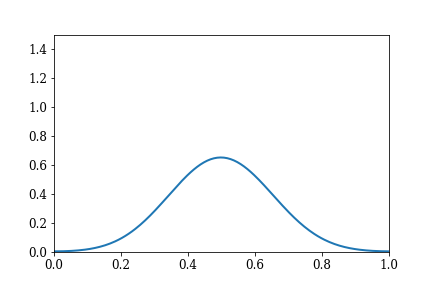
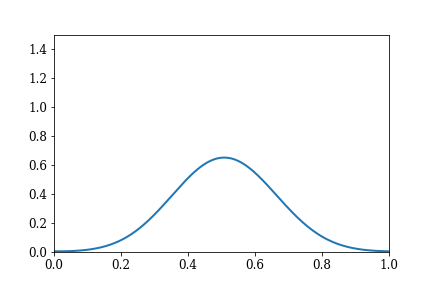
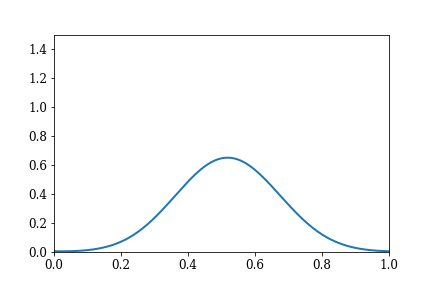
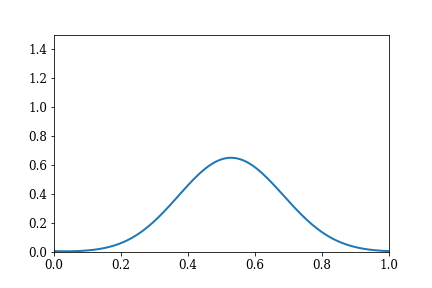
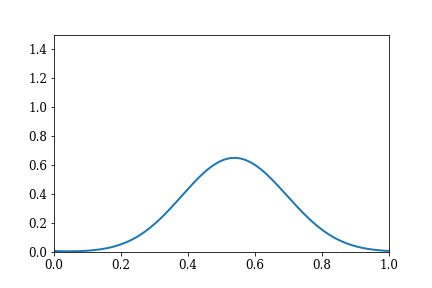
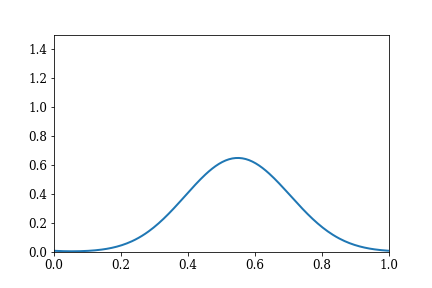
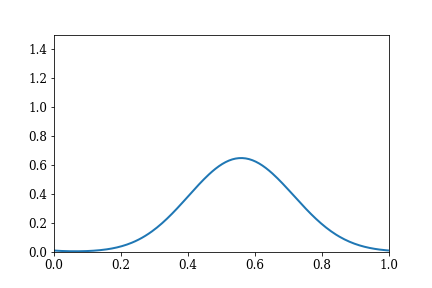
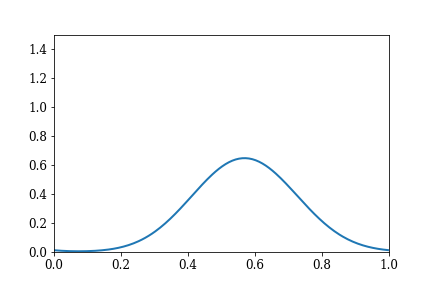
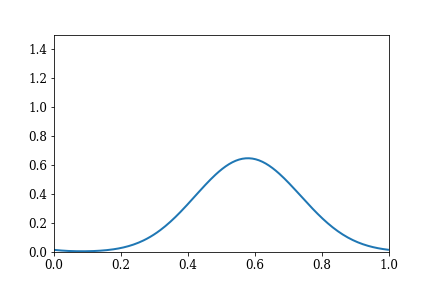
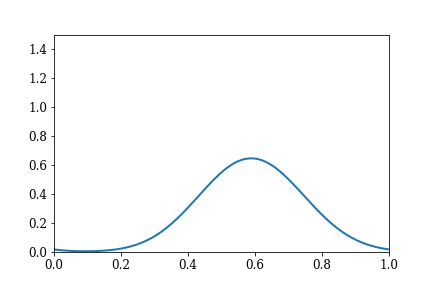
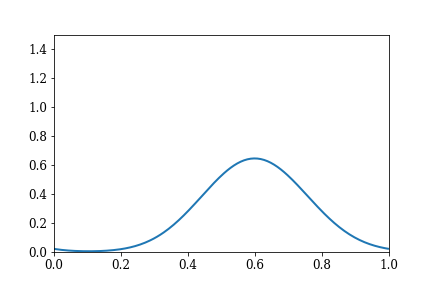
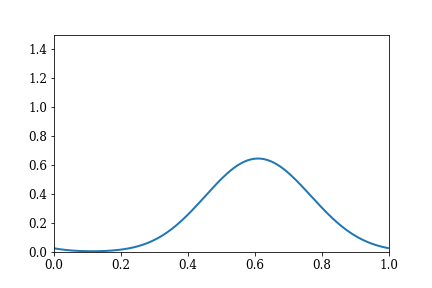
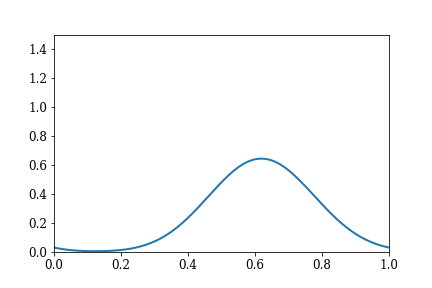
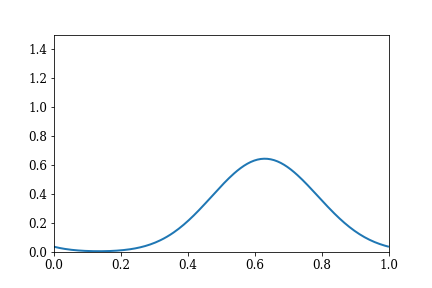
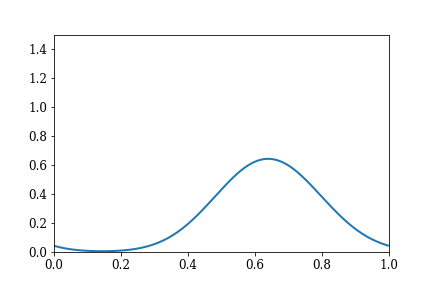
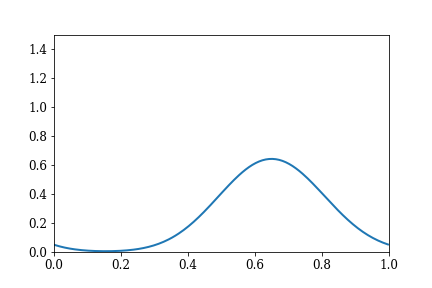
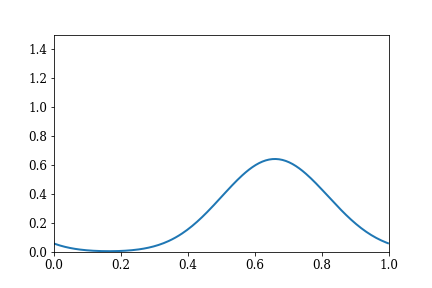
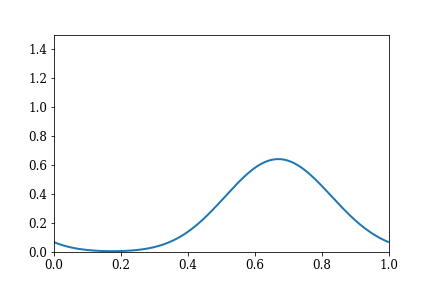
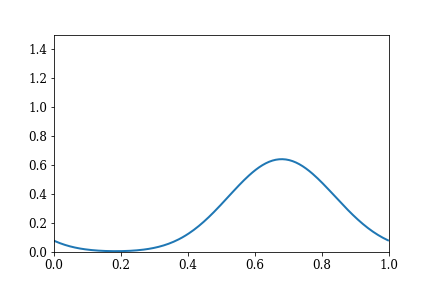
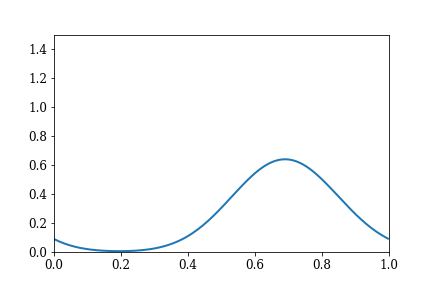
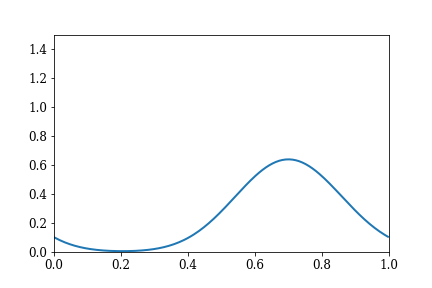
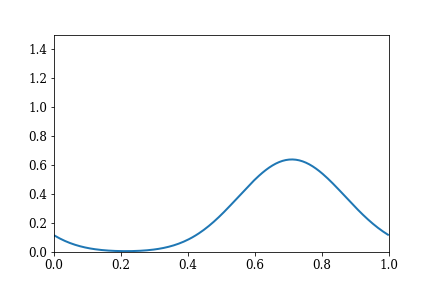
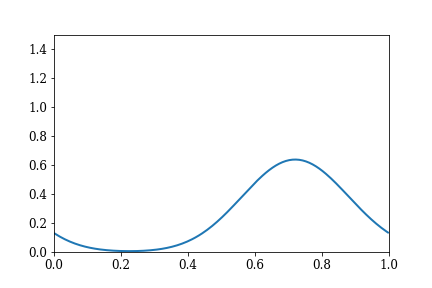
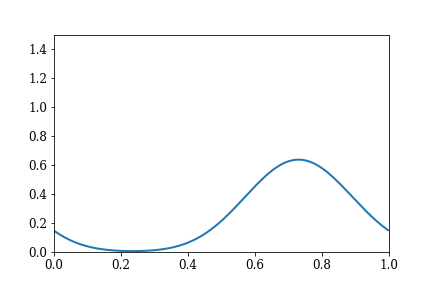
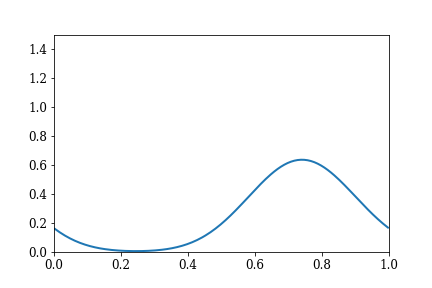
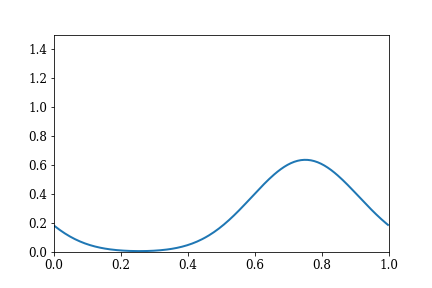
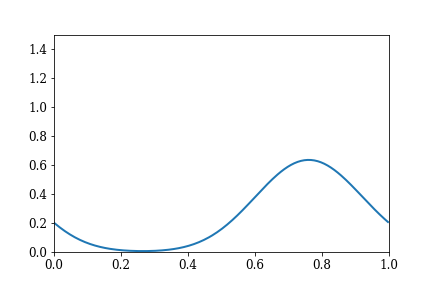
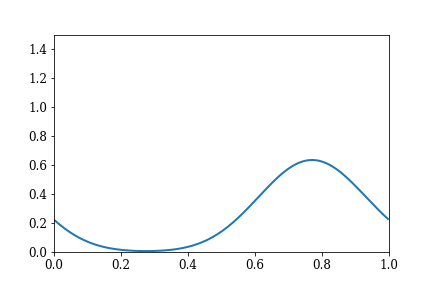
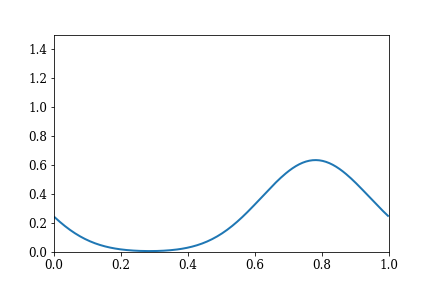
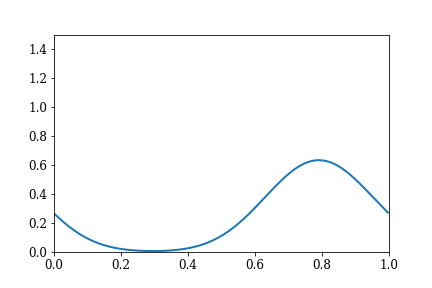
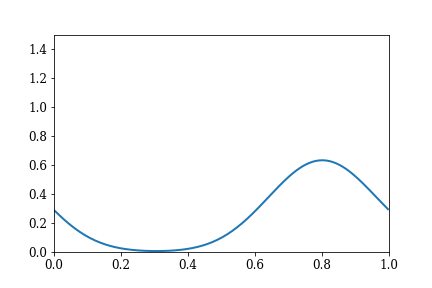
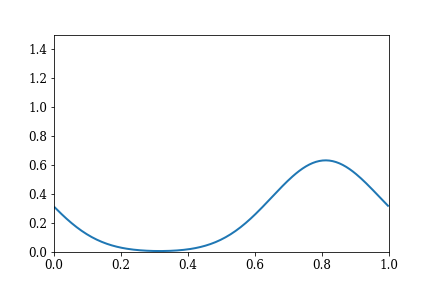
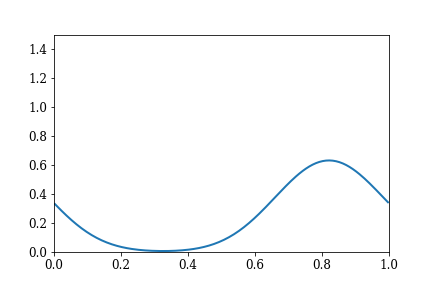
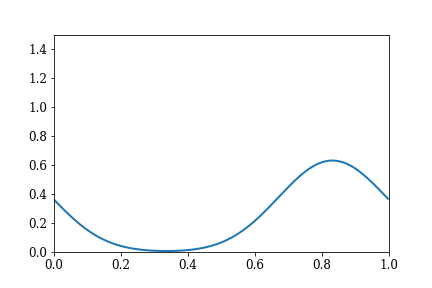
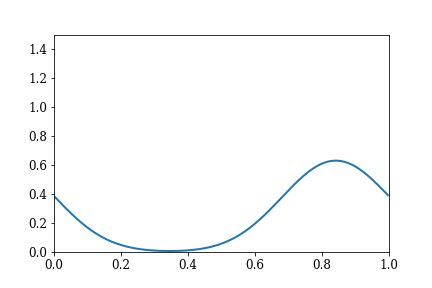
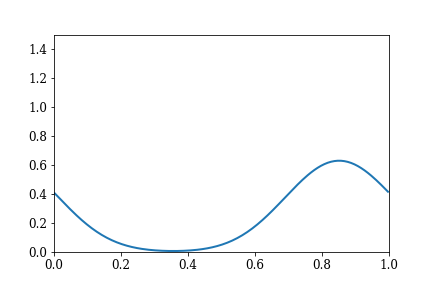
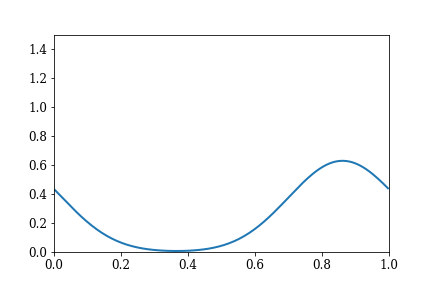
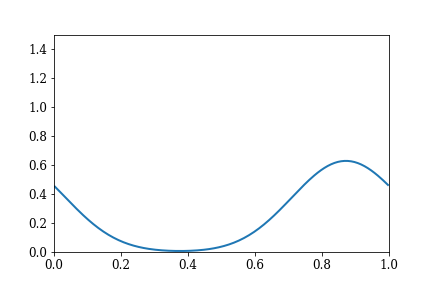
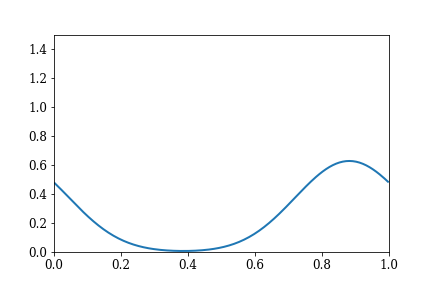
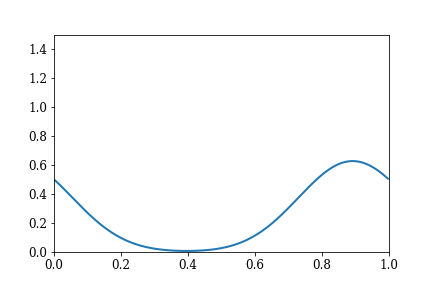
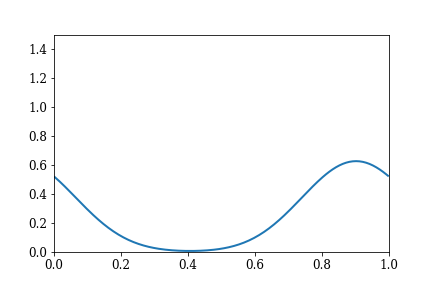
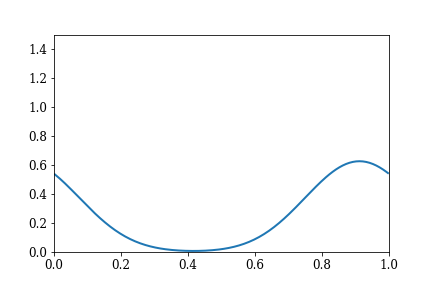
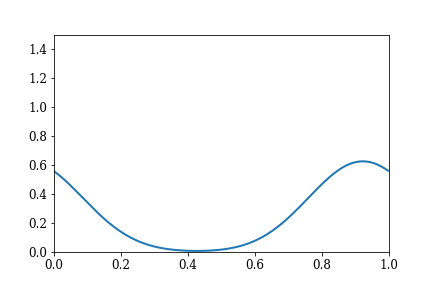
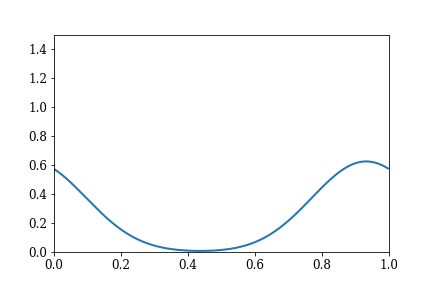
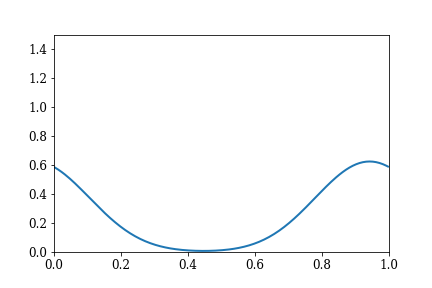
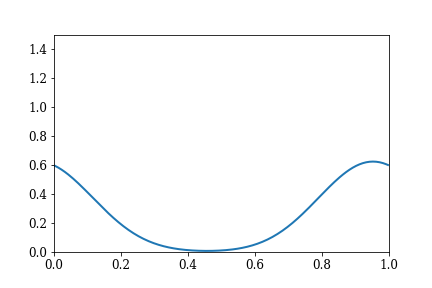
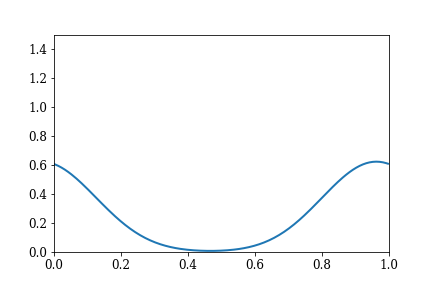
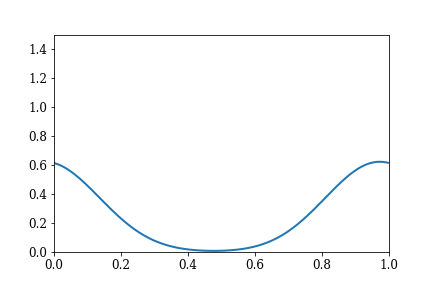
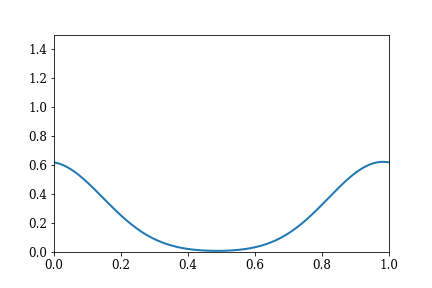
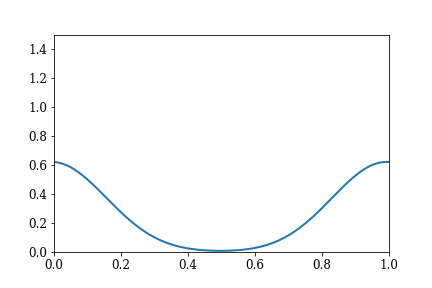
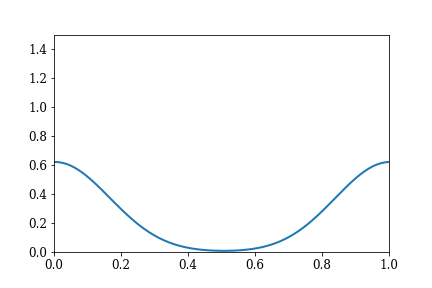
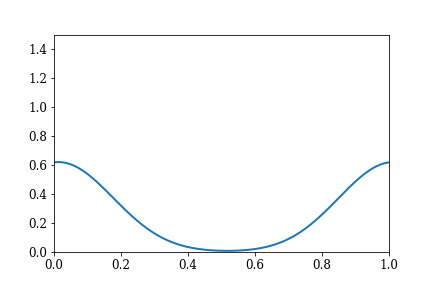
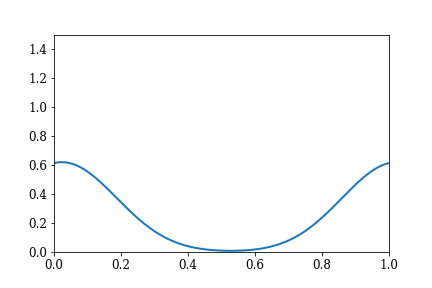
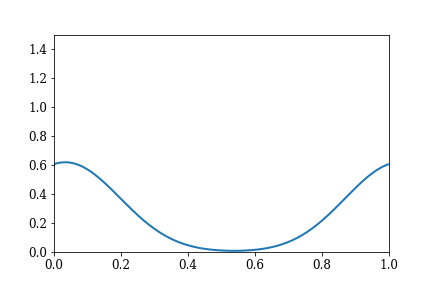
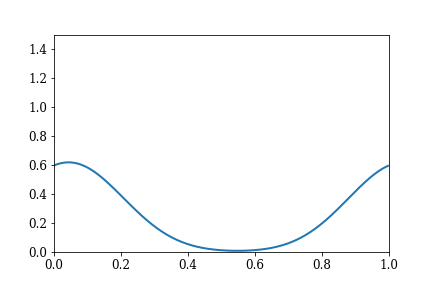
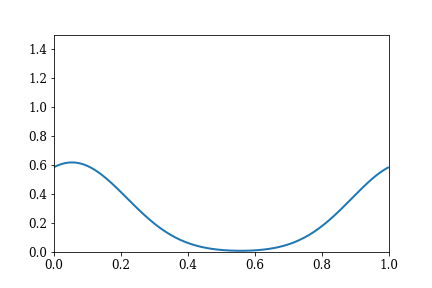
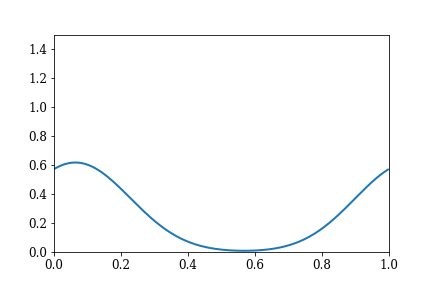
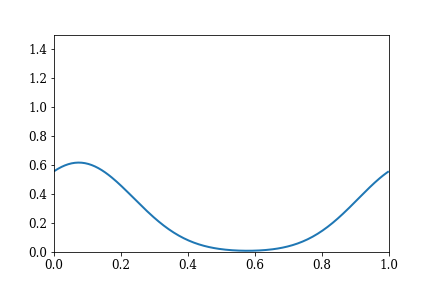
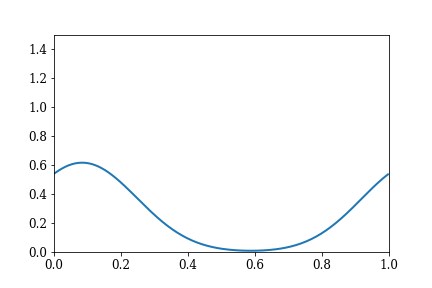
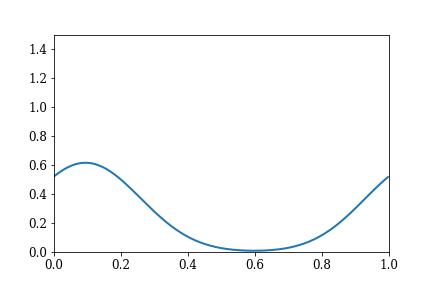
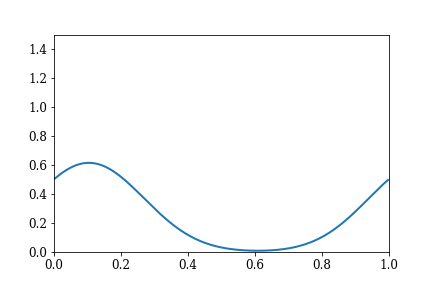
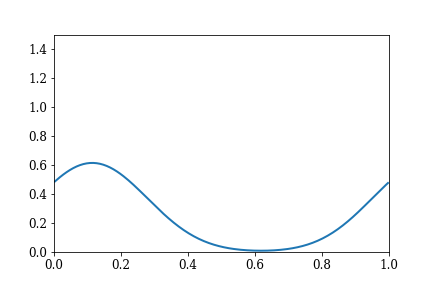
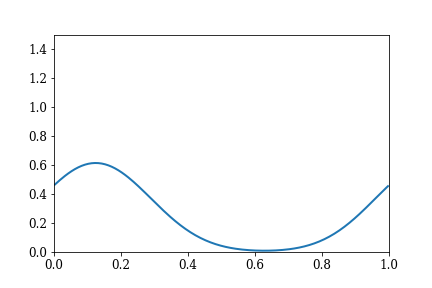
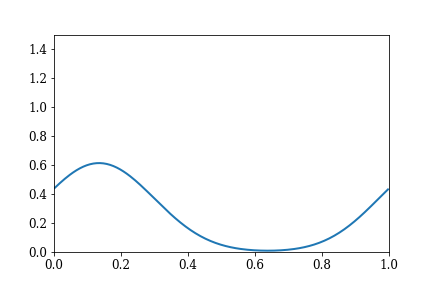
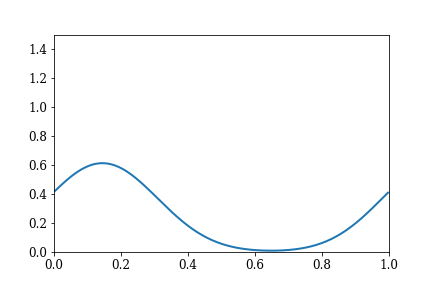
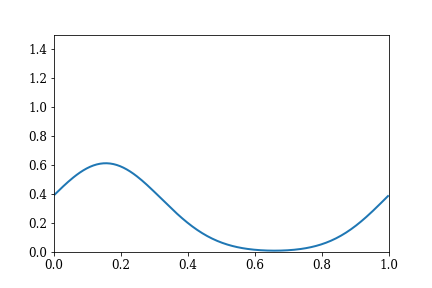
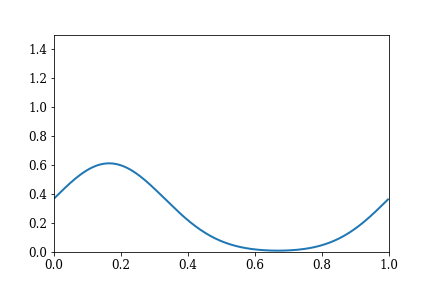
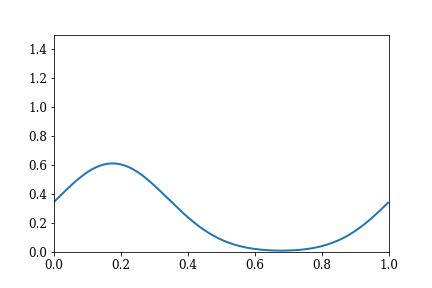
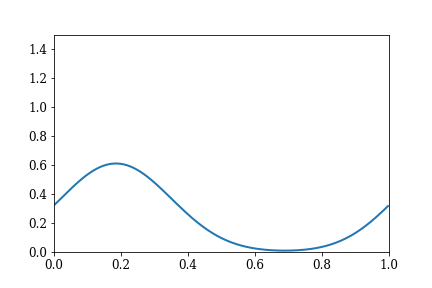
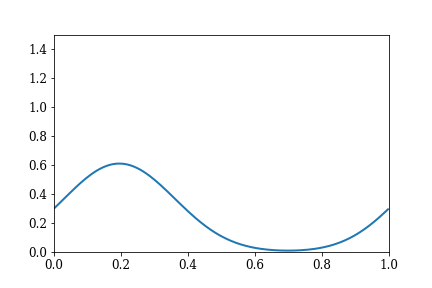
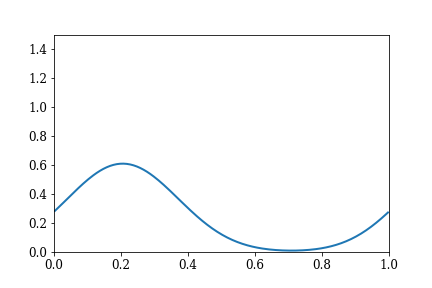
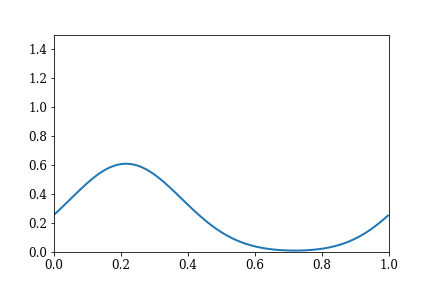
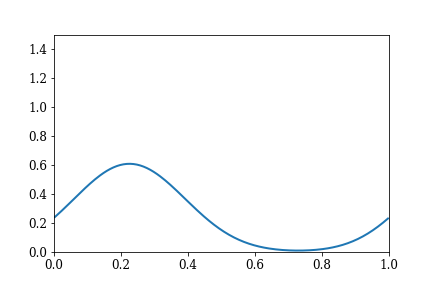
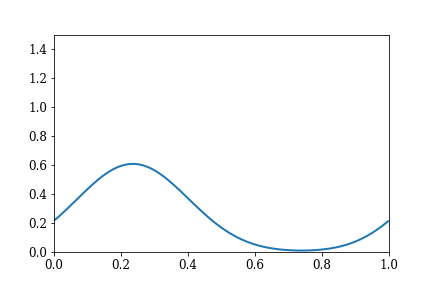
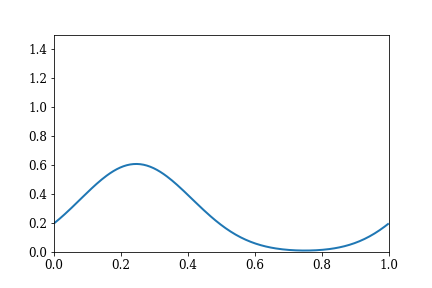
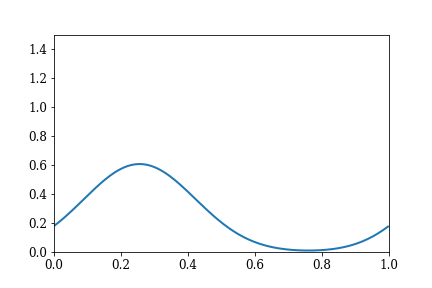
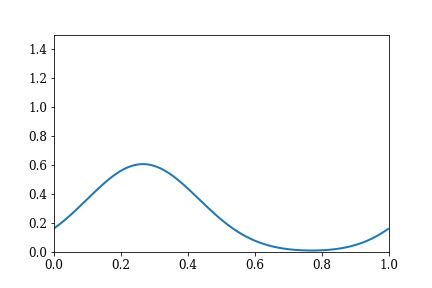
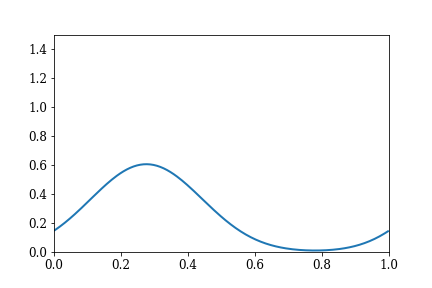
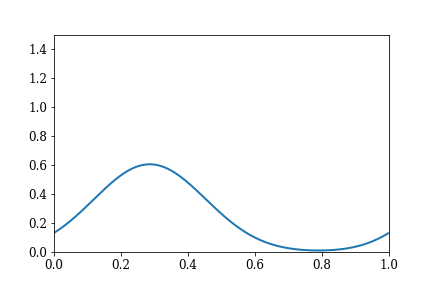
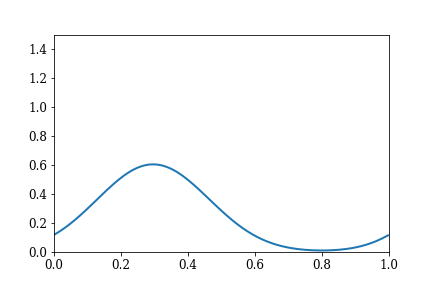
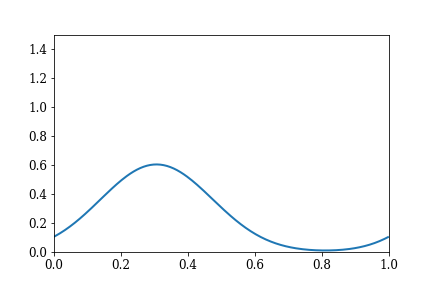
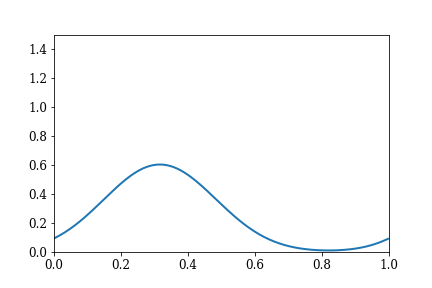
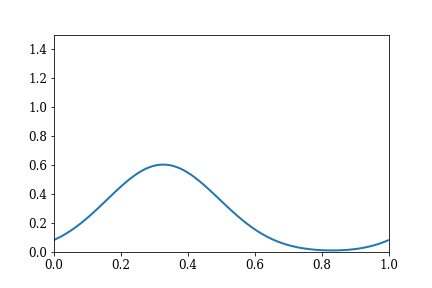
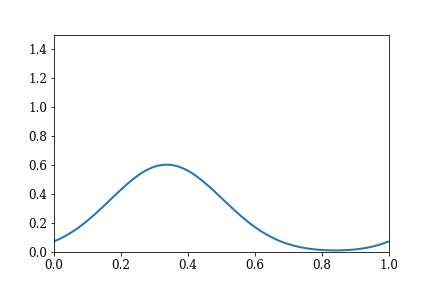
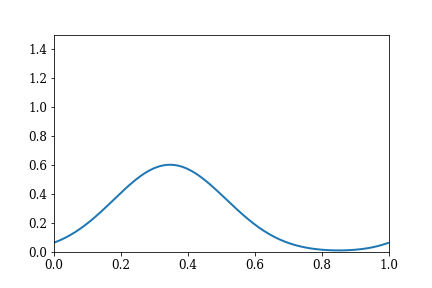
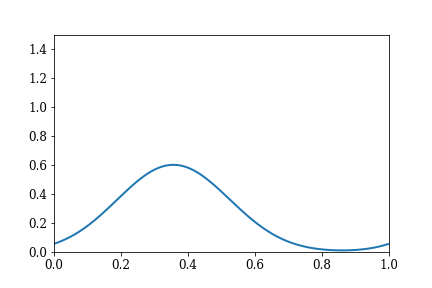
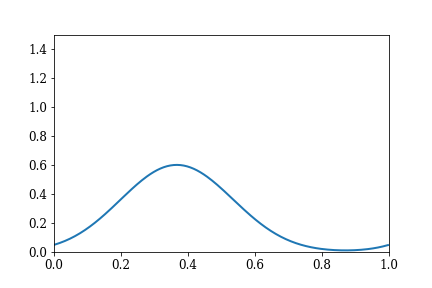
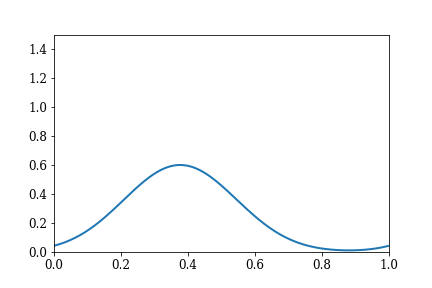
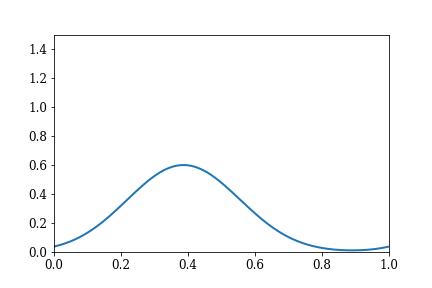
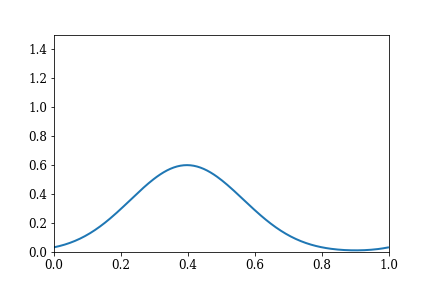
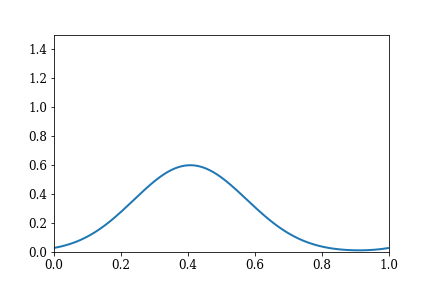
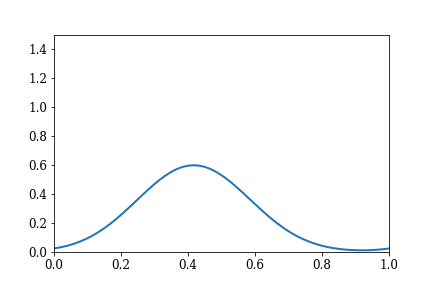
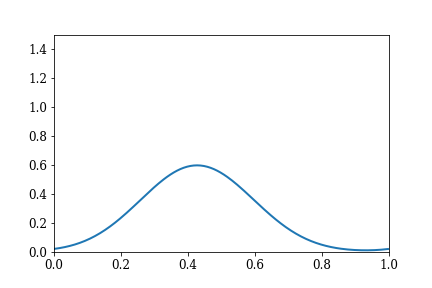
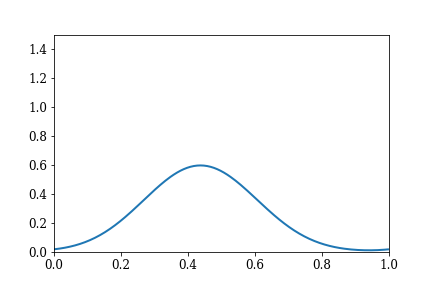
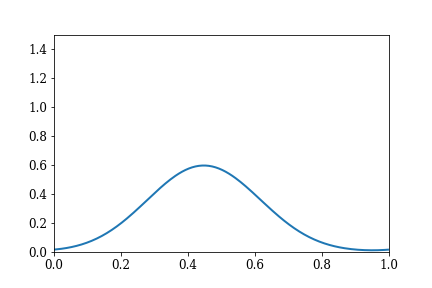
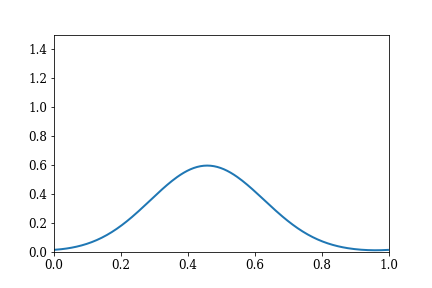
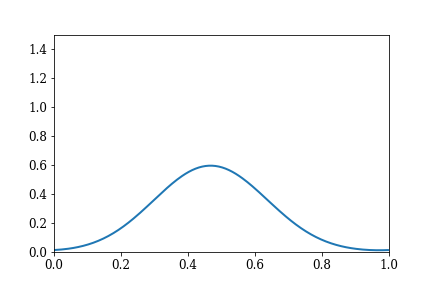
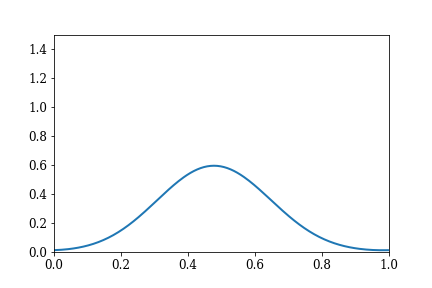
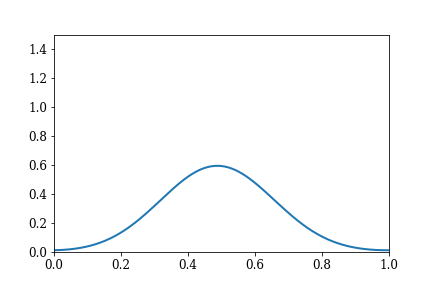
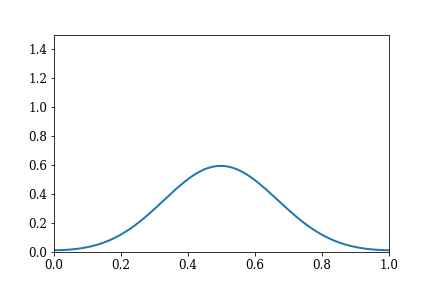
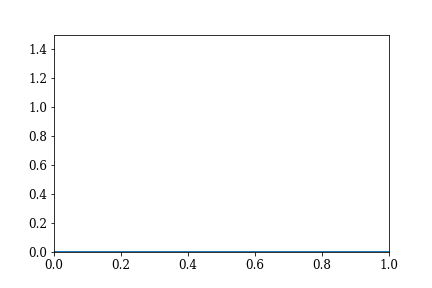
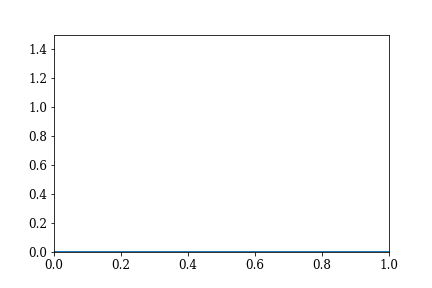
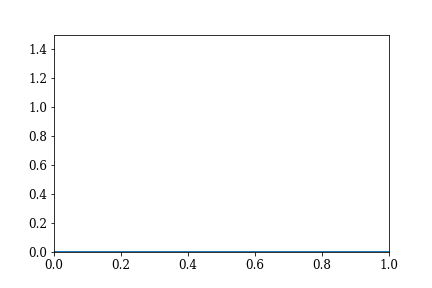
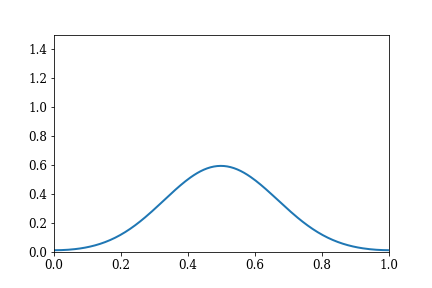

In [10]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nframes, interval=20, blit=True)

# call our new function to display the animation
display_animation(anim)

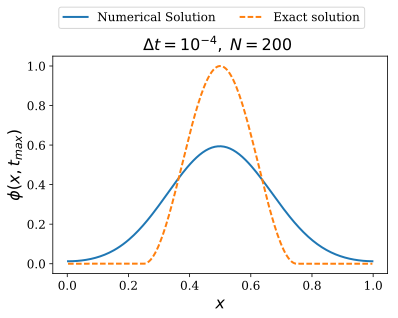

In [11]:
plt.plot(x_phi,phi,lw = 2, label = r"Numerical Solution")
plt.plot(x_phi,exact_solution(tmax), '--', lw = 2, label = r"Exact solution")
plt.xlabel(r"$x$", fontdict = fontlabel)
plt.ylabel(r"$\phi(x,t_{max})$", fontdict = fontlabel)
plt.legend(loc=3, bbox_to_anchor=[0, 1.1],
                   ncol=2, shadow=False, fancybox=True)
plt.title(r"$\Delta t=10^{-4},\;N=200$ ", fontdict = fontlabel)
plt.savefig("U1N200dt1e-4.pdf",bbox_inches='tight')
plt.show()
phi_1st = np.copy(phi)

In [12]:
def second_derivative_central_2nd(phi):
    global dx,N
    d2phi = np.zeros(len(phi))
    d2phi[1:-1] = phi[0:-2] - 2*phi[1:-1] + phi[2:]
    d2phi[0] = phi[-1] - 2*phi[0] + phi[1]
    d2phi[-1] = phi[-2] - 2*phi[-1] + phi[0]
    return d2phi/dx**2
t=0.
alpha = u_0*dt*dx/2.
phi = exact_solution(0.)
f = np.zeros(N)
while t<tmax:
    t +=dt
    f = second_derivative_central_2nd(phi)
    phi += alpha*f


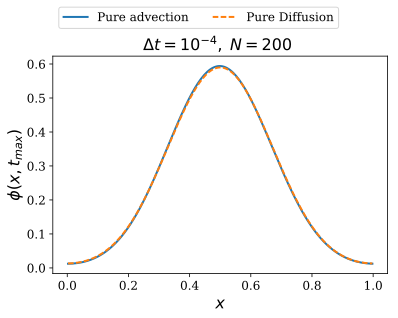

In [13]:
plt.plot(x_phi,phi_1st,lw = 2, label = r"Pure advection")
plt.plot(x_phi,phi, '--', lw = 2, label = r"Pure Diffusion")
plt.xlabel(r"$x$", fontdict = fontlabel)
plt.ylabel(r"$\phi(x,t_{max})$", fontdict = fontlabel)
plt.legend(loc=3, bbox_to_anchor=[0, 1.1],
                   ncol=2, shadow=False, fancybox=True)
plt.title(r"$\Delta t=10^{-4},\;N=200$ ", fontdict = fontlabel)
plt.savefig("diffvsadvN200dt1e-4.pdf",bbox_inches='tight')
plt.show()